# 0.0 Imports

In [1]:
import pandas                 as pd
import seaborn                as sns
import numpy                  as np
import matplotlib.pyplot      as plt
import statsmodels.api        as sm
import scikit_posthocs        as sp
import re


from statsmodels.stats.diagnostic         import het_breuschpagan
from statsmodels.stats.stattools          import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib                           import gridspec
from IPython.display                      import Image
from IPython.core.display                 import HTML
from scipy                                import stats

from scipy.stats                          import chi2_contingency, pointbiserialr,pearsonr,kruskal,kendalltau
from IPython.display                      import HTML, Image

from sklearn.preprocessing                import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics                      import r2_score, mean_squared_error, mean_absolute_error

## 0.1 Funções de Apoio

In [2]:
def run_breuschpagan_test(model_name, model_obj, X_data):
    """
    Executa o teste de Breusch-Pagan para verificar homocedasticidade.
    H0: Homocedasticidade (variância dos resíduos é constante)
    H1: Heterocedasticidade (variância dos resíduos não é constante)
    """
    # Adicionar uma constante à variável independente para o teste (se ainda não tiver)
    X_test = sm.add_constant(X_data) if X_data.shape[1] == 1 else X_data
    estatistica, p_valor, f_estatistica, f_p_valor = het_breuschpagan(model_obj.resid, X_test)
    print(f"\n--- Teste de Breusch-Pagan para {model_name} ---")
    print(f"Estatística de Teste: {estatistica:.4f}")
    print(f"P-valor: {p_valor:.4f}")
    print('')
    print(f"F-Estatística: {f_estatistica:.4f}")
    print(f"P-valor F: {f_p_valor:.4f}")
    print('')

    if p_valor < 0.05:
        print(f"Conclusão: Rejeitamos H0. Há evidências de heterocedasticidade no modelo {model_name}.")
    else:
        print(f"Conclusão: Não rejeitamos H0. Há evidências de homocedasticidade no modelo {model_name}.")


def run_shapiro_wilk_variavel(model_name, residuals):
    """
    Executa o teste de Shapiro-Wilk para verificar se a distribuição de uma variável segue a distribuição normal.
    H0: A distribuição da variável segue uma distribuição normal.
    H1: A distribuição da variável não seguem uma distribuição normal.
    """
    estatistica_shapiro, p_shapiro = stats.shapiro(residuals)
    print(f"\n--- Teste de Shapiro-Wilk para a variável {model_name} ---")
    print(f"Estatística de Teste: {estatistica_shapiro:.4f}")
    print(f"P-valor: {p_shapiro:.4f}")

    if p_shapiro < 0.05:
        print(f"Conclusão: Rejeitamos H0. A dsitribuição da variável {model_name} não segue uma distribuição normal.")
    else:
        print(f"Conclusão: Não rejeitamos H0. A distribuição da variável {model_name} segue uma distribuição normal.")




def run_shapiro_wilk_test(model_name, residuals):
    """
    Executa o teste de Shapiro-Wilk para verificar a normalidade dos resíduos.
    H0: Os resíduos seguem uma distribuição normal.
    H1: Os resíduos não seguem uma distribuição normal.
    """
    estatistica_shapiro, p_shapiro = stats.shapiro(residuals)
    print(f"\n--- Teste de Shapiro-Wilk para {model_name} ---")
    print(f"Estatística de Teste: {estatistica_shapiro:.4f}")
    print(f"P-valor: {p_shapiro:.4f}")

    if p_shapiro < 0.05:
        print(f"Conclusão: Rejeitamos H0. Os resíduos do modelo {model_name} não seguem uma distribuição normal.")
    else:
        print(f"Conclusão: Não rejeitamos H0. Os resíduos do modelo {model_name} seguem uma distribuição normal.")


def plot_qq(model_name, residuals):
    """
    Gera um QQ-plot para verificar a normalidade dos resíduos.
    """
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot - {model_name} (Normalidade dos Resíduos)", fontsize=14)
    plt.xlabel('Quantis Teóricos', fontsize=12)
    plt.ylabel('Quantis Amostrais dos Resíduos', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_standardized_residuals(model_name, model_obj, X_data):
    """
    Gera um gráfico de resíduos padronizados para identificar outliers.
    """
    residuos_padronizados = model_obj.get_influence().resid_studentized_internal

    plt.figure(figsize=(8, 6))
    plt.scatter(X_data, residuos_padronizados)
    plt.axhline(y=3, color='r', linestyle='--', label='Limite Superior (+3)')
    plt.axhline(y=-3, color='r', linestyle='--', label='Limite Inferior (-3)')
    plt.title(f'Gráfico de Resíduos Padronizados para {model_name} (Identificação de Outliers)', fontsize=14)
    plt.xlabel(f'Investimento em {model_name}', fontsize=12)
    plt.ylabel('Resíduos Padronizados', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# 2. Cálculo do VIF
def calculate_vif(dataframe, target_col=None):
    """Calcula VIF para todas as variáveis num DataFrame"""
    if target_col is not None:
        X = dataframe.drop(columns=[target_col])
    else:
        X = dataframe.copy()
    
    X = sm.add_constant(X)  # Adiciona intercepto
    
    vif_data = pd.DataFrame()
    vif_data["Variável"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                       for i in range(len(X.columns))]
    
    # Remove o VIF da constante (geralmente é alto e não interpretável)
    vif_data = vif_data[vif_data['Variável'] != 'const']
    
    return vif_data.sort_values('VIF', ascending=False)


# localiza o estado EUA no endereço
def extract_state(address: str) -> str:
    match = re.search(r",\s([A-Z]{2})\b", address)
    return match.group(1) if match else "Na"




def composicao_histograma_boxplot(dataframe, coluna, 
                                 titulo=None, label_x=None, label_y_hist='Frequência',
                                 fonte_titulo=16, fonte_eixos=14, fonte_ticks=12,
                                 num_bins='auto', range_bins=None, largura_bin=None,
                                 tamanho_figura=(12, 8), proporcoes=(0.15, 0.85), 
                                 espacamento=0.02, mostrar_kde=True,
                                 cor_hist='skyblue', alpha_hist=0.7,
                                 cor_boxplot='lightblue', mostrar_medias_boxplot=True,
                                 mostrar_linhas_estatisticas=True, mostrar_grid=True,
                                 estilo_grid='--', alpha_grid=0.5):
    """
    Cria composição de boxplot e histograma com múltiplas opções de customização
    
    Parâmetros:
    -----------
    dataframe : DataFrame
        DataFrame com os dados
    coluna : str
        Nome da coluna numérica para análise
    titulo : str
        Título do gráfico (se None, usa nome da coluna)
    label_x : str
        Label do eixo X (se None, usa nome da coluna)
    label_y_hist : str
        Label do eixo Y do histograma
    fonte_titulo : int
        Tamanho da fonte do título
    fonte_eixos : int
        Tamanho da fonte dos eixos
    fonte_ticks : int
        Tamanho da fonte dos ticks
    num_bins : int ou str
        Número de bins ou 'auto', 'fd', 'doane', etc.
    range_bins : tuple
        Intervalo dos bins (min, max)
    largura_bin : float
        Largura fixa dos bins (sobrescreve num_bins se especificado)
    tamanho_figura : tuple
        Tamanho da figura (largura, altura)
    proporcoes : tuple
        Proporções dos subplots (boxplot, histograma)
    espacamento : float
        Espaçamento entre subplots
    mostrar_kde : bool
        Se True, mostra linha de densidade (KDE)
    cor_hist : str
        Cor do histograma
    alpha_hist : float
        Transparência do histograma
    cor_boxplot : str
        Cor do boxplot
    mostrar_medias_boxplot : bool
        Se True, mostra média no boxplot
    mostrar_linhas_estatisticas : bool
        Se True, mostra linhas de média, mediana e moda
    mostrar_grid : bool
        Se True, mostra grid
    estilo_grid : str
        Estilo da linha do grid
    alpha_grid : float
        Transparência do grid
    """
    
    # Valores padrão
    if titulo is None:
        titulo = f'Distribuição de {coluna}'
    
    if label_x is None:
        label_x = coluna
    
    # Configurar figura e subplots
    fig, (ax1, ax2) = plt.subplots(
        nrows=2,
        ncols=1,
        sharex=True,
        figsize=tamanho_figura,
        gridspec_kw={
            "height_ratios": proporcoes,
            "hspace": espacamento
        }
    )
    
    # ========== BOXPLOT (PARTE SUPERIOR) ==========
    boxplot_props = {
        'color': cor_boxplot,
        'showfliers': True,
        'whis': 1.5
    }
    
    if mostrar_medias_boxplot:
        boxplot_props.update({
            'showmeans': True,
            'meanline': True,
            'meanprops': {
                "color": "red", 
                "linewidth": 1.5, 
                "linestyle": "--",
                "label": "Média"
            },
            'medianprops': {
                "color": "green", 
                "linewidth": 1.5, 
                "linestyle": "-",
                "label": "Mediana"
            }
        })
    
    # Criar boxplot
    sns.boxplot(
        data=dataframe,
        x=coluna,
        ax=ax1,
        **boxplot_props
    )
    
    # Configurar boxplot
    ax1.set_ylabel('Boxplot', fontsize=fonte_eixos-2)
    ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    
    # ========== HISTOGRAMA (PARTE INFERIOR) ==========
    histplot_kwargs = {
        'data': dataframe,
        'x': coluna,
        'kde': mostrar_kde,
        'color': cor_hist,
        'alpha': alpha_hist,
        'ax': ax2
    }
    
    # Configurar bins
    if largura_bin is not None:
        bins_array = np.arange(
            dataframe[coluna].min() if range_bins is None else range_bins[0],
            dataframe[coluna].max() if range_bins is None else range_bins[1] + largura_bin,
            largura_bin
        )
        histplot_kwargs['bins'] = bins_array
    else:
        histplot_kwargs['bins'] = num_bins
        if range_bins is not None:
            histplot_kwargs['binrange'] = range_bins
    
    # Criar histograma
    sns.histplot(**histplot_kwargs)
    
    # Configurar histograma
    ax2.set_xlabel(label_x, fontsize=fonte_eixos)
    ax2.set_ylabel(label_y_hist, fontsize=fonte_eixos)
    
    # ========== CONFIGURAÇÕES GERAIS ==========
    # Adicionar linhas estatísticas no histograma
    if mostrar_linhas_estatisticas:
        media = dataframe[coluna].mean()
        mediana = dataframe[coluna].median()
        
        ax2.axvline(media, color="red", linestyle="--", linewidth=2, label=f"Média: {media:.2f}")
        ax2.axvline(mediana, color="green", linestyle="-", linewidth=2, label=f"Mediana: {mediana:.2f}")
        
        # Moda (pode haver múltiplas modas)
        try:
            moda = dataframe[coluna].mode()[0]
            ax2.axvline(moda, color="orange", linestyle=":", linewidth=2, label=f"Moda: {moda:.2f}")
        except:
            pass
        
        ax2.legend(fontsize=fonte_ticks-2)
    
    # Adicionar grid
    if mostrar_grid:
        for ax in (ax1, ax2):
            ax.grid(True, linestyle=estilo_grid, color="gray", alpha=alpha_grid)
            ax.set_axisbelow(True)
    
    # Configurar fontes dos ticks
    for ax in (ax1, ax2):
        ax.tick_params(axis='both', which='major', labelsize=fonte_ticks)
    
    # Título geral
    fig.suptitle(titulo, fontsize=fonte_titulo, fontweight='bold', y=0.95)
    
    #plt.tight_layout()
    plt.show()
    
    return fig, (ax1, ax2)


## 0.2 Carregando os dados

In [3]:
data = pd.read_csv('./data/ecommerce_customers.csv')
data.shape

(500, 8)

# 1.0 Base de dados selecionada

A base de dados selecionada corresponde ao dataset "Ecommerce Custormers" que pode ser encontrado no endereço:

https://www.kaggle.com/datasets/srolka/ecommerce-customers

**Informações dataset**

Este conjunto de dados possui informações do cliente, como Email, Endereço e sua cor Avatar, bem como apresenta colunas de valores numéricos.

# 2.0 Contextualizar o problema a ser resolvido

<font color = 'red'>**Contexto de negócio**</f>

Fui contratado como cientista de dados em uma empresa de comércio eletrônico com sede na cidade de Nova York que vende roupas online, mas que também tem sessões de consultoria em estilo e vestuário nas lojas físicas. 

Os clientes entram na loja, têm sessões / reuniões com um estilista pessoal, então podem ir para casa e encomendarem em um aplicativo mobile ou site para a roupa que desejam. 

A empresa está tentando decidir se deve concentrar seus esforços em aplicativos móveis, no seu site, nas consultorias personalizadas ou em um programa de fidelidade.

<font color = 'red'>**Objetivo do trabalho**</f>

O objetivo principal deste trabalho é desenvolver uma **Análise Exploratória de Dados (EDA)** e construir um **modelo de regressão linear múltipla** utilizando um dataset público de clientes de um e-commerce de moda, com o intuito de compreender os fatores que influenciam o valor gasto pelos clientes e apoiar a tomada de decisão estratégica da empresa.

De forma específica, os objetivos são:

- Compreender a estrutura e as características do dataset, identificando tipos de variáveis, distribuições, possíveis outliers e padrões iniciais por meio da Análise Exploratória de Dados (EDA).

- Analisar estatisticamente a relação entre as variáveis independentes (*tempo médio de sessão de consultoria*, *tempo no aplicativo*, *tempo no website* e *tempo de associação como membro*) e a variável dependente (*valor gasto pelo cliente*).

- Construir um modelo de regressão linear múltipla, aplicando conceitos estatísticos como correlação, multicolinearidade, significância dos coeficientes e avaliação dos resíduos.

- Avaliar o desempenho do modelo utilizando métricas estatísticas adequadas, como \( R^2 \), \( R^2 \) ajustado, análise dos resíduos e validação das premissas do modelo linear.

- Interpretar os resultados do modelo sob a ótica do negócio, identificando se o uso do aplicativo móvel, o tempo de consultoria com o estilista, o uso do website ou o programa de fidelidade possuem impacto no valor gasto pelos clientes.

- Demonstrar a aplicação prática da ciência de dados, integrando estatística, programação em Python e análise de negócio em um problema realista.

<font color = 'red'>**Justificativas**</f>

A escolha do dataset **“Ecommerce Customers”** é justificada por diversos fatores relevantes do ponto de vista acadêmico, estatístico e de negócio.

Primeiramente, trata-se de um **dataset público**, bem estruturado e amplamente utilizado em estudos introdutórios e intermediários de ciência de dados, o que garante **transparência, reprodutibilidade e confiabilidade** para fins educacionais.

Em segundo lugar, o conjunto de dados apresenta **variáveis numéricas contínuas**, o que o torna especialmente adequado para a aplicação de **modelos de regressão linear múltipla**, permitindo explorar conceitos fundamentais como:

- Relação linear entre variáveis  
- Interpretação dos coeficientes  
- Impacto marginal de cada variável explicativa  
- Avaliação estatística de significância  

Além disso, o **contexto de negócio é claro e realista**, refletindo um problema comum enfrentado por empresas de e-commerce: **decidir onde concentrar investimentos — em múltiplos cenários**. Esse tipo de decisão estratégica é frequentemente embasado em **análises quantitativas**, o que reforça a relevância do uso de modelos preditivos.



# 3.0 Processamentos dos dados

In [4]:
df1 = data.copy()

## 3.1 Dimensão dos dados

In [5]:
print(f'Número de linhas: {data.shape[0]}')
print(f'Número de colunas: {data.shape[1]}')

Número de linhas: 500
Número de colunas: 8


## 3.2 Nome das colunas

### 3.2.1 Significado das variáveis

In [6]:
# Colunas
df1.columns

Index(['Email', 'Address', 'Avatar', 'Avg. Session Length', 'Time on App',
       'Time on Website', 'Length of Membership', 'Yearly Amount Spent'],
      dtype='object')

* Email: e-mail do cliente
* Address: endereço do cliente
* Avatar: cor do avatar
* Avg. Session Length: Tempo médio das sessões de consultoria de estilo na loja.
* Time on App: tempo médio gasto no app em minutos.
* Time on Website: tempo médio gasto no site em minutos.
* Lenght of Membership: Há quantos anos o cliente é membro.
* Yearly Amount Spent: Valor gasto anualmente em compras **--> variável resposta**

## 3.2.2 Renomeando as colunas

In [7]:
df1.columns

Index(['Email', 'Address', 'Avatar', 'Avg. Session Length', 'Time on App',
       'Time on Website', 'Length of Membership', 'Yearly Amount Spent'],
      dtype='object')

In [8]:
df1.columns = [ 'email', 'address', 'avatar', 'tempo_consultoria', 'tempo_app',
                'tempo_website', 'tempo_membro', 'gasto_anual']

## 3.3 Tipo de dados

In [9]:
df1.dtypes

email                 object
address               object
avatar                object
tempo_consultoria    float64
tempo_app            float64
tempo_website        float64
tempo_membro         float64
gasto_anual          float64
dtype: object

## 3.4 Verificação de NA's

In [10]:
df1.isna().sum()

email                0
address              0
avatar               0
tempo_consultoria    0
tempo_app            0
tempo_website        0
tempo_membro         0
gasto_anual          0
dtype: int64

## 3.5 Alteração de tipo das variáveis

In [11]:
df1['email']     = df1['email'].astype('category')
df1['address']   = df1['address'].astype('category')
df1['avatar']    = df1['avatar'].astype('category')

In [12]:
df1.dtypes

email                category
address              category
avatar               category
tempo_consultoria     float64
tempo_app             float64
tempo_website         float64
tempo_membro          float64
gasto_anual           float64
dtype: object

# 4.0 Filtragem de variáveis

In [13]:
df2 = df1.copy()

## 4.1 Filtragem de linhas

In [14]:
# verificação de duplicados
df2.duplicated().sum()

np.int64(0)

In [15]:
aux1 = df2[['tempo_consultoria', 'tempo_app','tempo_website', 'tempo_membro', 'gasto_anual']].copy()

In [16]:
# verificação de duplicados valores numericos
aux1.duplicated().sum()

np.int64(0)

In [17]:
df2.columns

Index(['email', 'address', 'avatar', 'tempo_consultoria', 'tempo_app',
       'tempo_website', 'tempo_membro', 'gasto_anual'],
      dtype='object')

**Não há valores duplicados na base de dados**

## 4.2 Filtragem de colunas

### 4.2.1 e-mail

**A variável categorica  "e-mail" pode ser considerada como o identificador do cliente.** Portanto será removida, pois não faz sentido do ponto de vista da modelagem.

In [18]:
# quantidade de clientes unicos
df2['email'].unique().shape[0]

500

In [19]:
df2.shape[0]

500

Não há clientes duplicados

### 4.2.2 Adress

In [20]:
# valores unicos
df2['address'].unique().shape[0]

500

In [21]:
# verificando estados nos endereços via função regex
aux1 = df2.copy()
aux1["state"] = aux1["address"].apply(lambda x: extract_state(x))

In [22]:
# DICIONÁRIO 1: Abreviação → Nome Completo (Padrão ANSI)
abreviacao = {
    # Estados Continentais (48)
    'Na': 'Não encontrado',
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'DC': 'District of Columbia',  # Não é estado, mas frequentemente incluído
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming',
    
    # Territórios dos EUA
    'AS': 'American Samoa',
    'GU': 'Guam',
    'MP': 'Northern Mariana Islands',
    'PR': 'Puerto Rico',
    'VI': 'U.S. Virgin Islands',
    'UM': 'U.S. Minor Outlying Islands',
    
    # Códigos Militares (APO/FPO/DPO)
    'AA': 'Armed Forces Americas',
    'AE': 'Armed Forces Europe',
    'AP': 'Armed Forces Pacific',
    
    # Territórios Livre Associados
    'FM': 'Federated States of Micronesia',
    'MH': 'Marshall Islands',
    'PW': 'Palau',
}

In [23]:
aux1['state'] = aux1['state'].map(abreviacao)

In [24]:
# 15 valores mais frequentes
aux1["state"].value_counts(normalize=True)[:15]

state
Não encontrado    0.092
Missouri          0.026
South Carolina    0.026
Delaware          0.026
Oregon            0.024
Vermont           0.024
Mississippi       0.022
Florida           0.022
Kansas            0.022
Minnesota         0.022
North Carolina    0.020
New Jersey        0.020
Hawaii            0.018
Alabama           0.018
West Virginia     0.018
Name: proportion, dtype: float64

**Consideração**

A variável endereço será removida do dataset, pois os endereços estadunidenses não existem na prática. Além disso, foi realizada a extração dos estados estadunidenses via regex nessa variável e o valor mais frequentes (9.2%) foram os endereço sem estado (na). 

Sendo assim, será adotada a premissa que nesse ciclo não será utilizada essa variável.

### 4.2.3 Avatar

In [25]:
df1["avatar"].unique().shape[0]

138

In [26]:
df1["avatar"].value_counts(normalize=True)

avatar
Cyan             0.014
CadetBlue        0.014
SlateBlue        0.014
GreenYellow      0.014
Teal             0.014
                 ...  
PaleGoldenRod    0.002
NavajoWhite      0.002
Red              0.002
PowderBlue       0.002
Yellow           0.002
Name: proportion, Length: 138, dtype: float64

**Considerações**

Há 138 cores distintas para os avatares no dataset e as mais frequentes correspondem a 1.4 %. Sendo assim, será adotada a premissa que nesse ciclo não será utilizada essa variável.

### 4.2.4 Filtrando as colunas

In [27]:
# filtrando as colunas

df2 = df2[['tempo_consultoria', 'tempo_app','tempo_website', 'tempo_membro', 'gasto_anual']].copy()

In [28]:
df2.columns

Index(['tempo_consultoria', 'tempo_app', 'tempo_website', 'tempo_membro',
       'gasto_anual'],
      dtype='object')

# 5.0 Análise descritiva

In [29]:
df4 = df2.copy()
df4.shape

(500, 5)

## 5.1 Análise Univariada

### 5.1.1 Calcular estatísticas

In [30]:
#dataset variaveis numericas
num_attributes = df4.select_dtypes(include = ['int64','float64'])

# Medidas de tendencia central - media
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T

# Medidas de tendencia central - mediana
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersao

# desvio padrao
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T

# minimo
d2 = pd.DataFrame( num_attributes.apply( min ) ).T

#maximo
d3 = pd.DataFrame( num_attributes.apply( max ) ).T

#range
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T

#assimetria - Skew
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T

#Curtose - Kurtosis
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#Tabela
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

### 5.1.2 Variável Dependente - Gasto Anual do Cliente

In [31]:
m.iloc[4]

attributes    gasto_anual
min            256.670582
max            765.518462
range           508.84788
mean           499.314038
median         498.887875
std             79.235427
skew              0.03479
kurtosis         0.463976
Name: 4, dtype: object

In [32]:
# Quantidade de valores unicos
df4['gasto_anual'].unique().shape[0]

500

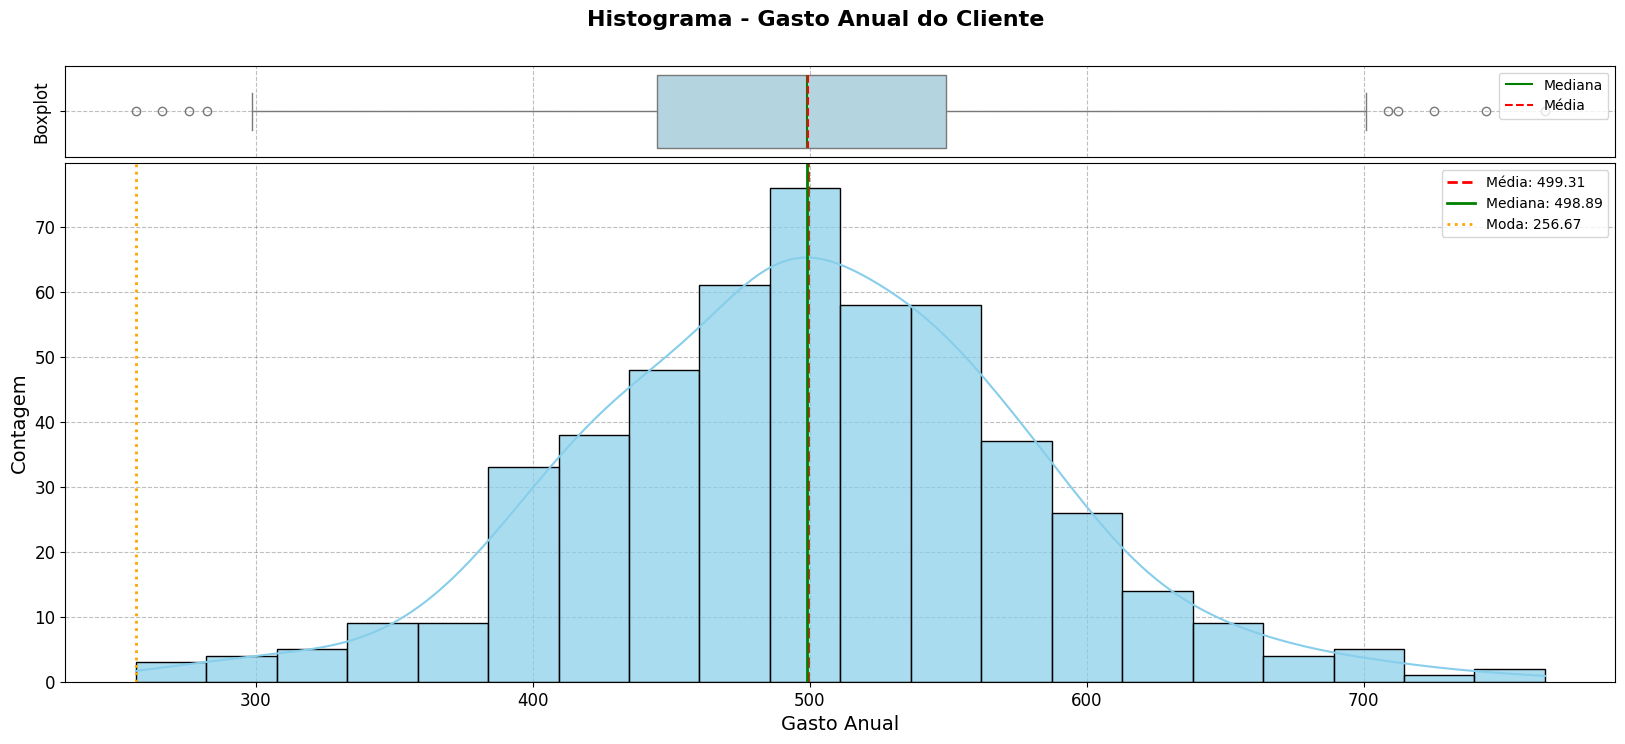

In [33]:
composicao_histograma_boxplot(df4, 'gasto_anual', 
                              titulo='Histograma - Gasto Anual do Cliente', label_x='Gasto Anual', label_y_hist='Contagem',
                              fonte_titulo=16, fonte_eixos=14, fonte_ticks=12,
                              num_bins='auto', range_bins=None, largura_bin=None,
                              tamanho_figura=(20, 8), proporcoes=(0.15, 0.85), espacamento=0.02, mostrar_kde=True, 
                              cor_hist='skyblue', alpha_hist=0.7, cor_boxplot='lightblue',
                              mostrar_medias_boxplot=True, mostrar_linhas_estatisticas=True,
                              mostrar_grid=True,estilo_grid='--', alpha_grid=0.5);

In [34]:
# Teste de normalidade
run_shapiro_wilk_variavel('Gasto Anual do Cliente', df4['gasto_anual'])


--- Teste de Shapiro-Wilk para a variável Gasto Anual do Cliente ---
Estatística de Teste: 0.9961
P-valor: 0.2642
Conclusão: Não rejeitamos H0. A distribuição da variável Gasto Anual do Cliente segue uma distribuição normal.


### 5.1.3 Variável - Tempo de Consultoria de estilo na loja

In [35]:
m.iloc[0]

attributes    tempo_consultoria
min                   29.532429
max                   36.139662
range                  6.607234
mean                  33.053194
median                33.082008
std                     0.99157
skew                  -0.032175
kurtosis               0.011862
Name: 0, dtype: object

In [36]:
# Quantidade de valores unicos
df4['tempo_consultoria'].unique().shape[0]

500

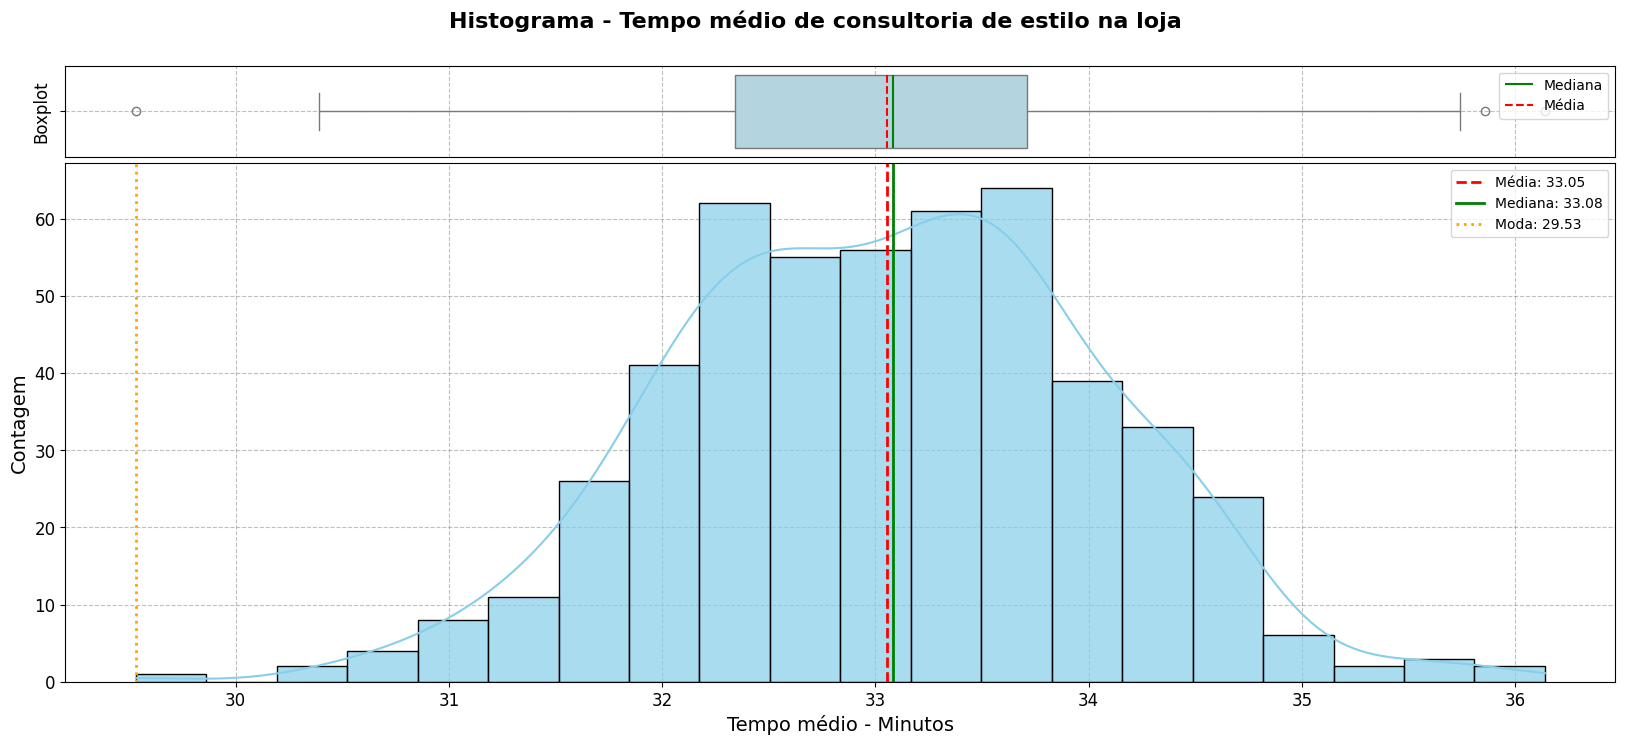

In [37]:
composicao_histograma_boxplot(df4, 'tempo_consultoria', 
                              titulo='Histograma - Tempo médio de consultoria de estilo na loja', label_x='Tempo médio - Minutos', label_y_hist='Contagem',
                              fonte_titulo=16, fonte_eixos=14, fonte_ticks=12,
                              num_bins='auto', range_bins=None, largura_bin=None,
                              tamanho_figura=(20, 8), proporcoes=(0.15, 0.85), espacamento=0.02, mostrar_kde=True, 
                              cor_hist='skyblue', alpha_hist=0.7, cor_boxplot='lightblue',
                              mostrar_medias_boxplot=True, mostrar_linhas_estatisticas=True,
                              mostrar_grid=True,estilo_grid='--', alpha_grid=0.5);

In [38]:
# Teste de normalidade
run_shapiro_wilk_variavel('Tempo de Consultoria', df4['tempo_consultoria'])


--- Teste de Shapiro-Wilk para a variável Tempo de Consultoria ---
Estatística de Teste: 0.9977
P-valor: 0.7163
Conclusão: Não rejeitamos H0. A distribuição da variável Tempo de Consultoria segue uma distribuição normal.


### 5.1.4 Variável - Tempo médio gasto no aplicativo

In [39]:
m.iloc[1]

attributes    tempo_app
min            8.508152
max           15.126994
range          6.618842
mean          12.052488
median        11.983231
std            0.993221
skew          -0.089121
kurtosis       0.125081
Name: 1, dtype: object

In [40]:
# Quantidade de valores unicos
df4['tempo_app'].unique().shape[0]

500

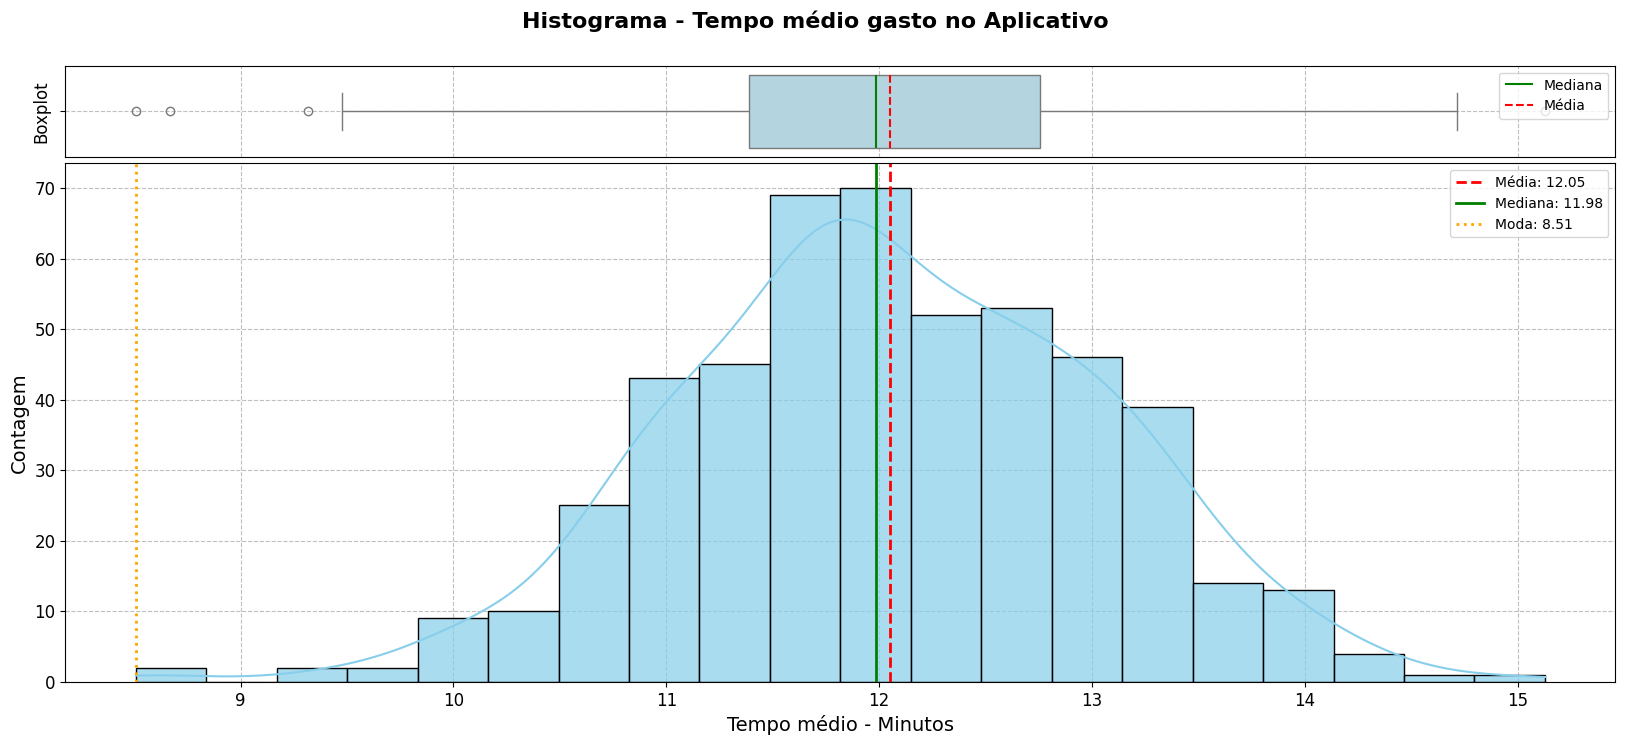

In [41]:
composicao_histograma_boxplot(df4, 'tempo_app', 
                              titulo='Histograma - Tempo médio gasto no Aplicativo', label_x='Tempo médio - Minutos', label_y_hist='Contagem',
                              fonte_titulo=16, fonte_eixos=14, fonte_ticks=12,
                              num_bins='auto', range_bins=None, largura_bin=None,
                              tamanho_figura=(20, 8), proporcoes=(0.15, 0.85), espacamento=0.02, mostrar_kde=True, 
                              cor_hist='skyblue', alpha_hist=0.7, cor_boxplot='lightblue',
                              mostrar_medias_boxplot=True, mostrar_linhas_estatisticas=True,
                              mostrar_grid=True,estilo_grid='--', alpha_grid=0.5);

In [42]:
# Teste de normalidade
run_shapiro_wilk_variavel('Tempo no APP', df4['tempo_app'])


--- Teste de Shapiro-Wilk para a variável Tempo no APP ---
Estatística de Teste: 0.9972
P-valor: 0.5547
Conclusão: Não rejeitamos H0. A distribuição da variável Tempo no APP segue uma distribuição normal.


### 5.1.5 Variável - Tempo médio gasto no website

In [43]:
m.iloc[2]

attributes    tempo_website
min               33.913847
max               40.005182
range              6.091334
mean              37.060445
median            37.069367
std                1.009478
skew               0.012142
kurtosis          -0.098287
Name: 2, dtype: object

In [44]:
# Quantidade de valores unicos
df4['tempo_website'].unique().shape[0]

500

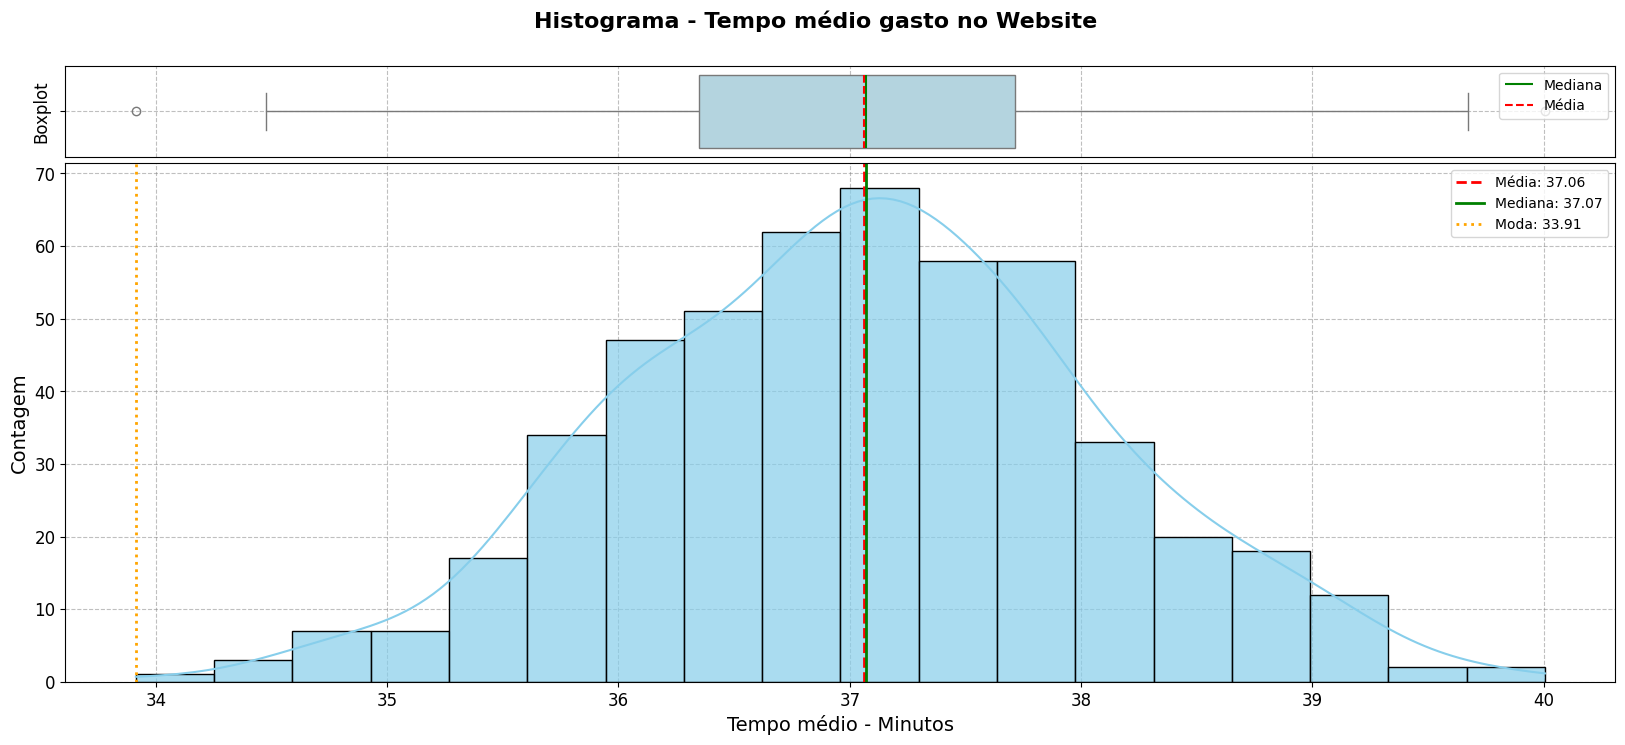

In [45]:
composicao_histograma_boxplot(df4, 'tempo_website', 
                              titulo='Histograma - Tempo médio gasto no Website', label_x='Tempo médio - Minutos', label_y_hist='Contagem',
                              fonte_titulo=16, fonte_eixos=14, fonte_ticks=12,
                              num_bins='auto', range_bins=None, largura_bin=None,
                              tamanho_figura=(20, 8), proporcoes=(0.15, 0.85), espacamento=0.02, mostrar_kde=True, 
                              cor_hist='skyblue', alpha_hist=0.7, cor_boxplot='lightblue',
                              mostrar_medias_boxplot=True, mostrar_linhas_estatisticas=True,
                              mostrar_grid=True,estilo_grid='--', alpha_grid=0.5);

In [46]:
# Teste de normalidade
run_shapiro_wilk_variavel('Tempo no Website', df4['tempo_website'])


--- Teste de Shapiro-Wilk para a variável Tempo no Website ---
Estatística de Teste: 0.9984
P-valor: 0.9364
Conclusão: Não rejeitamos H0. A distribuição da variável Tempo no Website segue uma distribuição normal.


### 5.1.6 Variável - Tempo de membro (Há quantos anos o cliente é membro) 

In [47]:
m.iloc[3]

attributes    tempo_membro
min               0.269901
max               6.922689
range             6.652788
mean              3.533462
median            3.533975
std               0.998278
skew             -0.106608
kurtosis           0.34901
Name: 3, dtype: object

In [48]:
# Quantidade de valores unicos
df4['tempo_membro'].unique().shape[0]

500

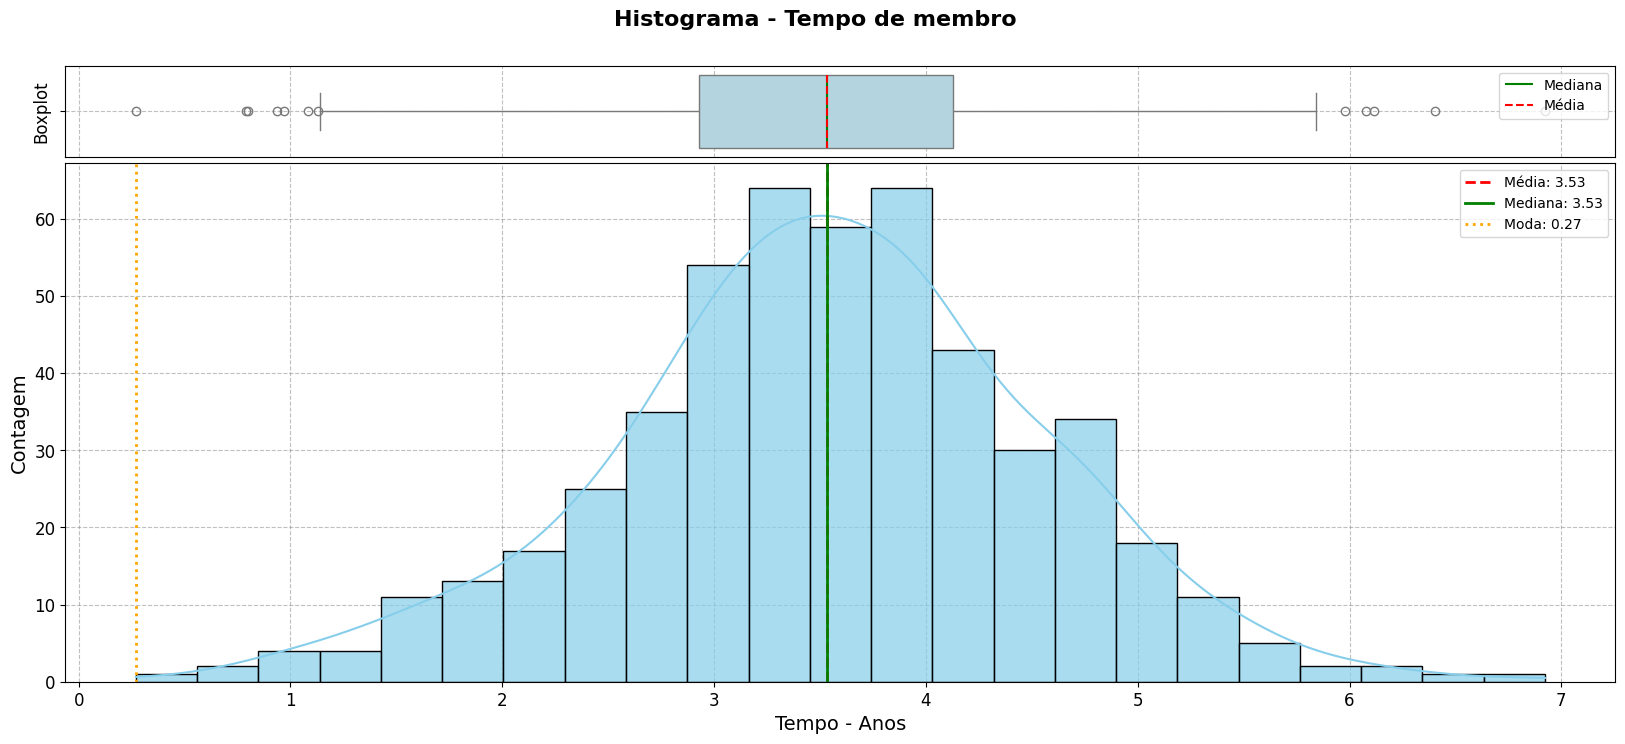

In [49]:
composicao_histograma_boxplot(df4, 'tempo_membro', 
                              titulo='Histograma - Tempo de membro', label_x='Tempo - Anos', label_y_hist='Contagem',
                              fonte_titulo=16, fonte_eixos=14, fonte_ticks=12,
                              num_bins='auto', range_bins=None, largura_bin=None,
                              tamanho_figura=(20, 8), proporcoes=(0.15, 0.85), espacamento=0.02, mostrar_kde=True, 
                              cor_hist='skyblue', alpha_hist=0.7, cor_boxplot='lightblue',
                              mostrar_medias_boxplot=True, mostrar_linhas_estatisticas=True,
                              mostrar_grid=True,estilo_grid='--', alpha_grid=0.5);

In [50]:
# Teste de normalidade
run_shapiro_wilk_variavel('Tempo como membro', df4['tempo_membro'])


--- Teste de Shapiro-Wilk para a variável Tempo como membro ---
Estatística de Teste: 0.9962
P-valor: 0.2745
Conclusão: Não rejeitamos H0. A distribuição da variável Tempo como membro segue uma distribuição normal.


## 5.2 Análise Bivariada

**Considerações sobre a análise:**

A análise Bivariada será realizada com todas as variáveis para a par com a variável resposta "tempo_gasto" que corresponde ao valor gasto anualmente em compras.


### 5.2.1 Tempo Consultoria de estilo x Gasto Anual do Cliente

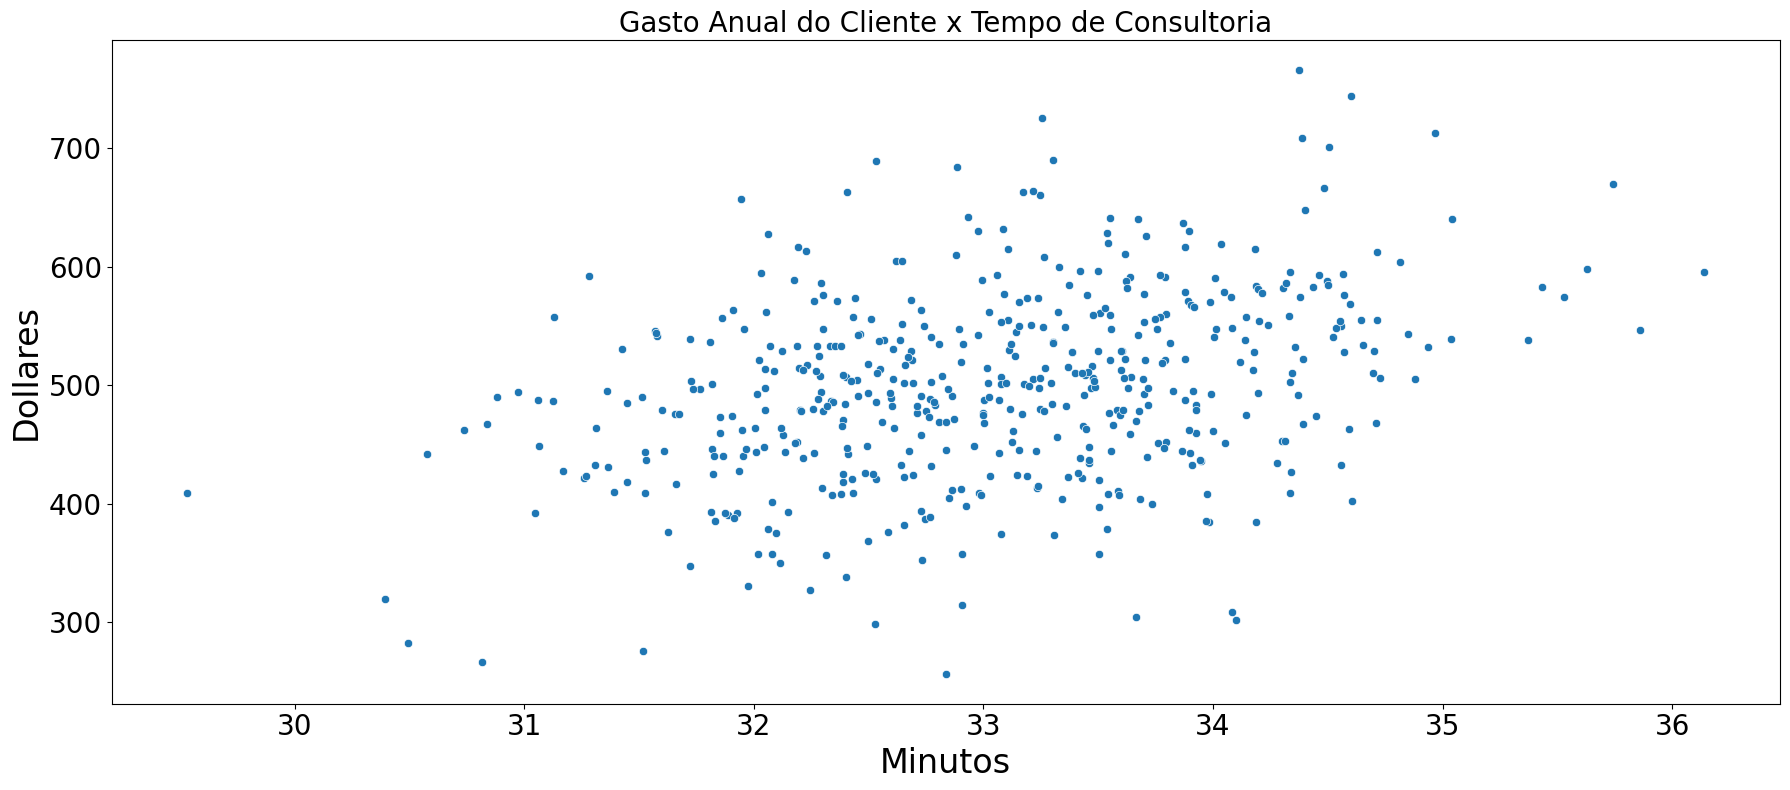

In [51]:
# Gráfico de dispersão
fig = plt.figure( figsize = (18,8) )
sns.scatterplot(data =df4, x='tempo_consultoria',y='gasto_anual');

plt.title("Gasto Anual do Cliente x Tempo de Consultoria", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Dollares',fontsize=24)
plt.xlabel("Minutos",fontsize=24)
plt.tight_layout()
plt.show();

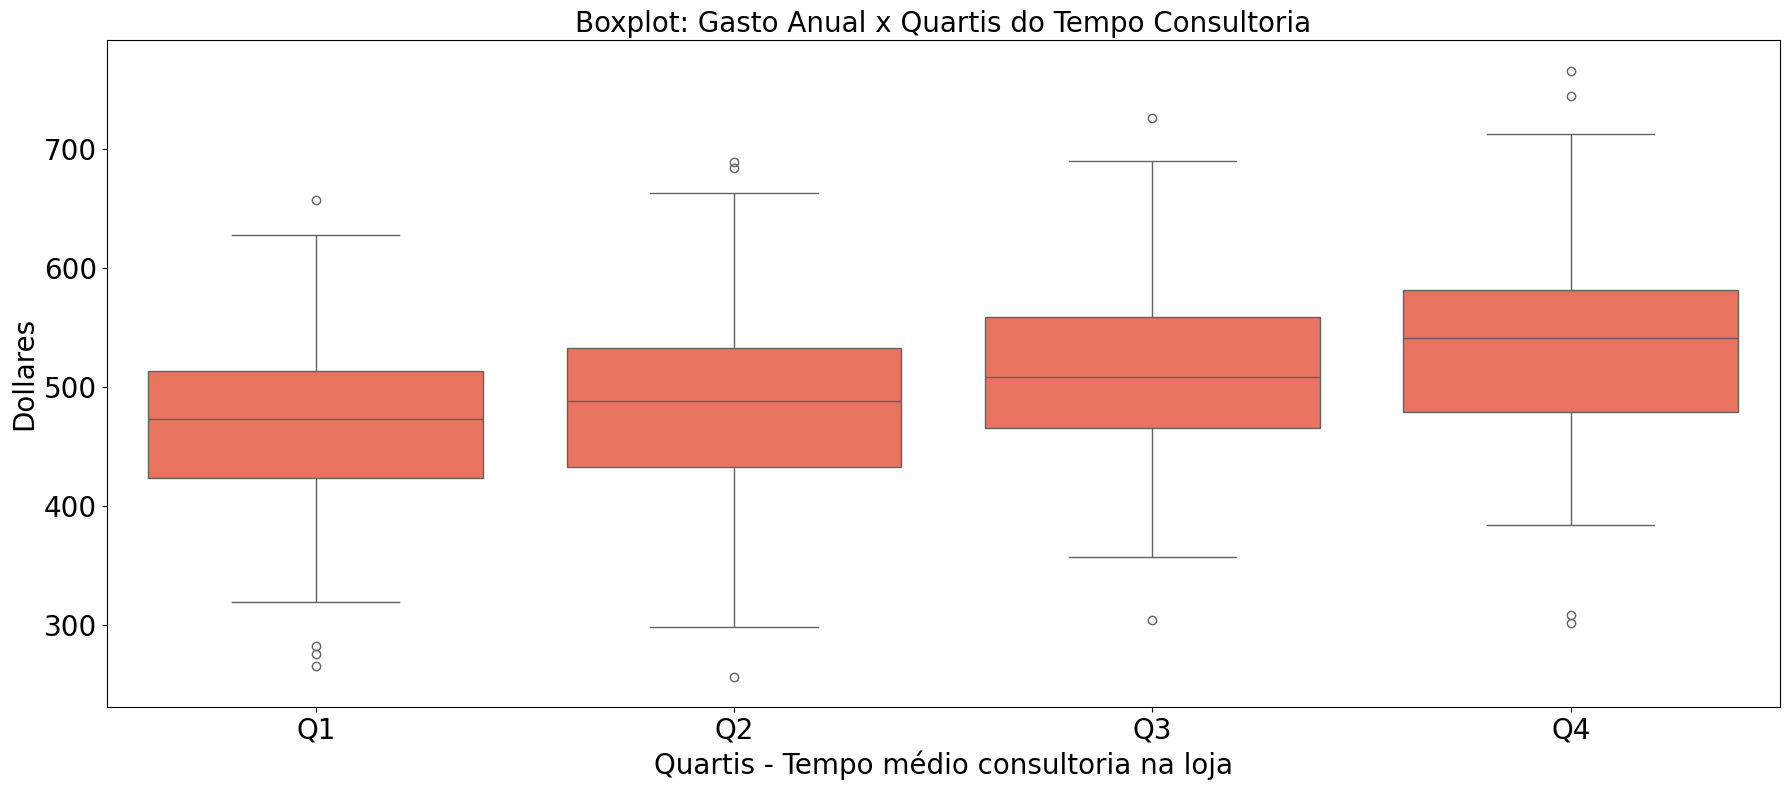

In [52]:
# Análise por quartis da variável tempo médio de consultoria
aux1 = df4.copy()
fig = plt.figure( figsize = (18,8) )
# ordena investimentos pelos quartis e cria o rótulo
aux1['quartil_id'] = pd.qcut(aux1['tempo_consultoria'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
cores = ['tomato','tomato','tomato','tomato']
sns.boxplot(data = aux1, x='quartil_id', y='gasto_anual',palette=cores, hue ='quartil_id', order=aux1['quartil_id'].sort_values(ascending = True).unique().tolist());

plt.title("Boxplot: Gasto Anual x Quartis do Tempo Consultoria", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Quartis - Tempo médio consultoria na loja',fontsize=20)
plt.ylabel('Dollares',fontsize=20)
plt.tight_layout()
plt.show();

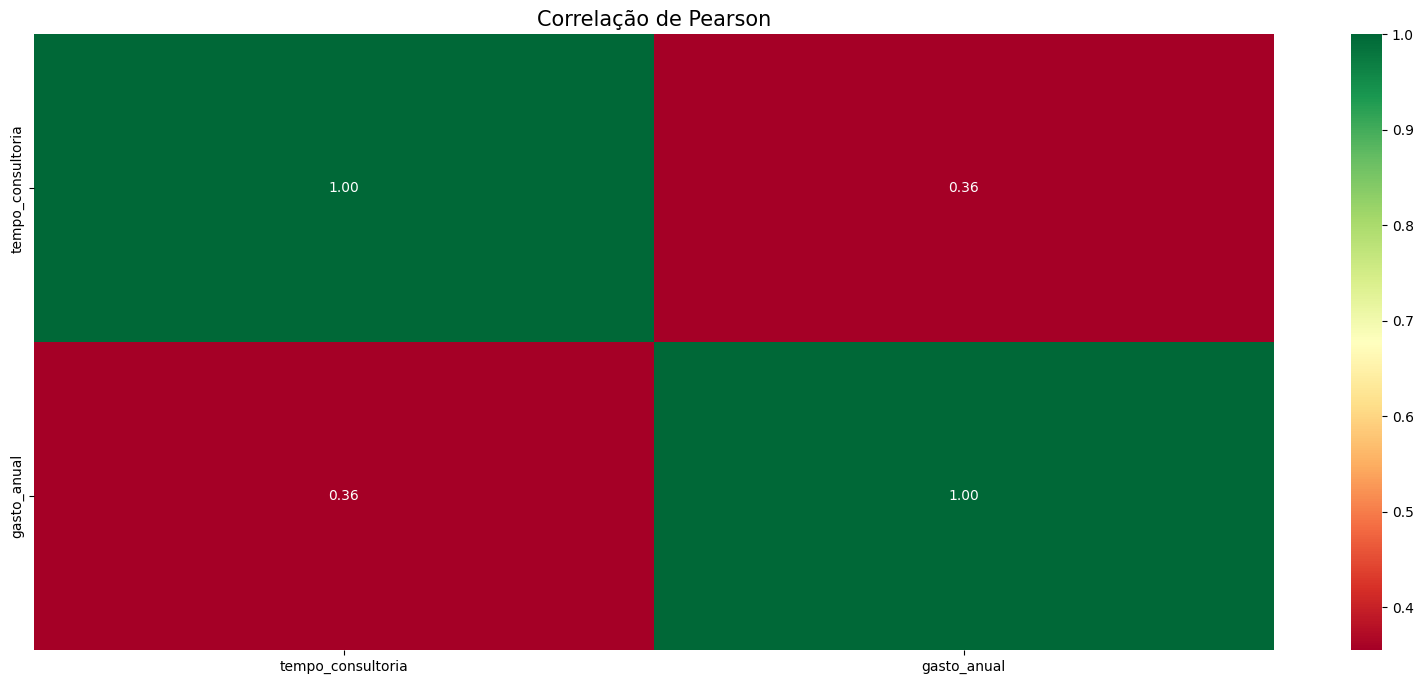

In [53]:
plt.figure(figsize=(20,8))
matriz = df4[['tempo_consultoria', 'gasto_anual']]
sns.heatmap(matriz.corr(),annot=True, cmap="RdYlGn", fmt=".2f");
plt.title('Correlação de Pearson',size=15);

### 5.2.2 Tempo gasto no APP x Gasto Anual do Cliente

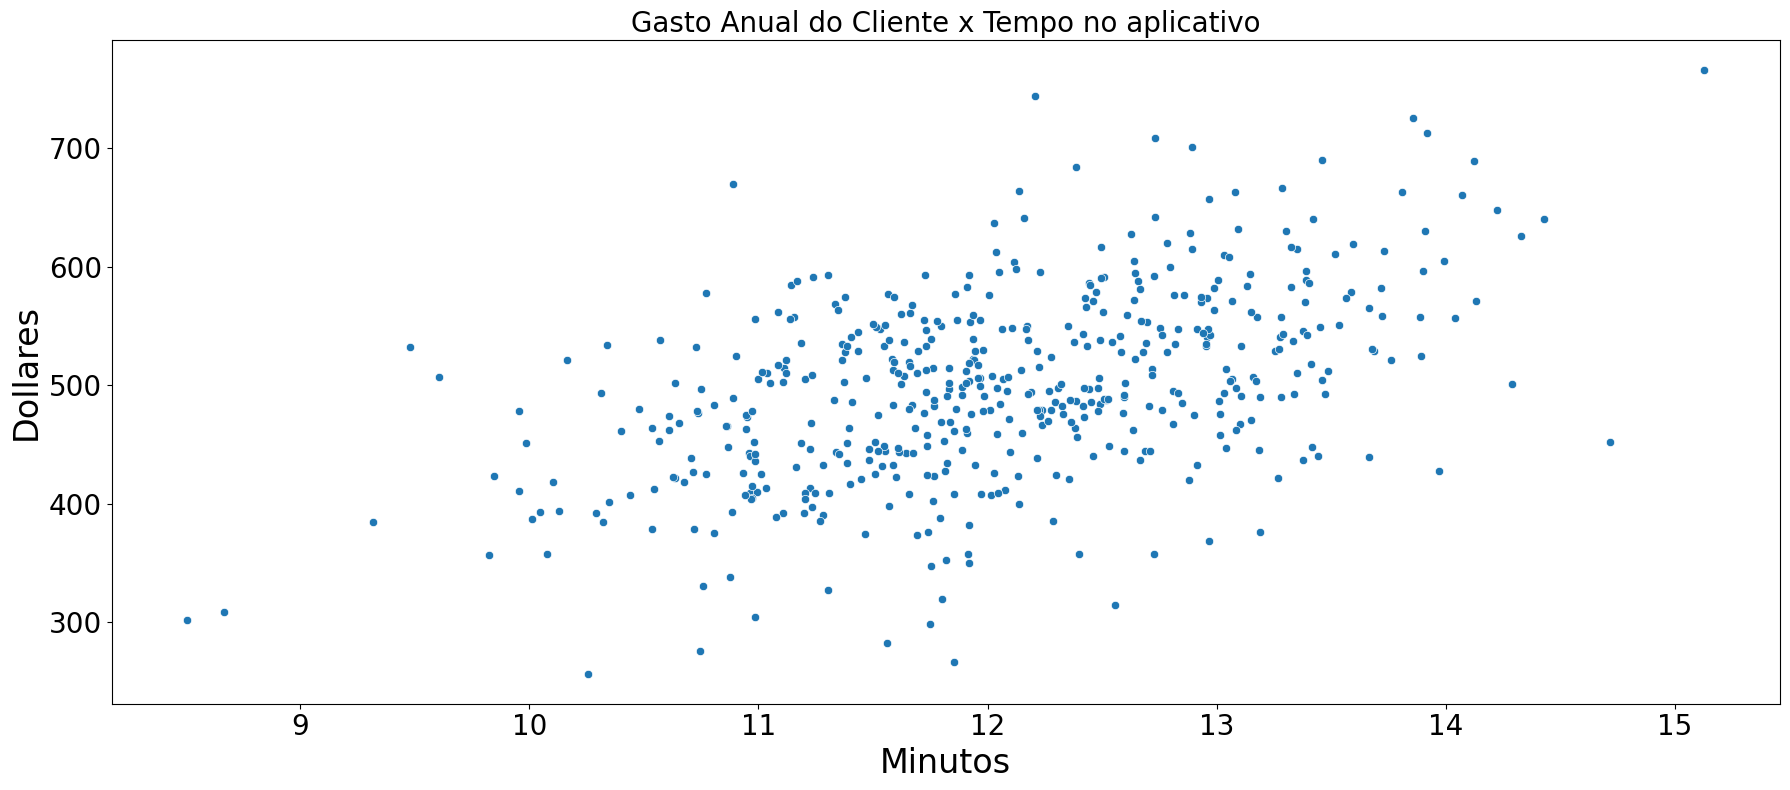

In [54]:
# Gráfico de dispersão
fig = plt.figure( figsize = (18,8) )
sns.scatterplot(data =df4, x='tempo_app',y='gasto_anual');

plt.title("Gasto Anual do Cliente x Tempo no aplicativo", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Dollares',fontsize=24)
plt.xlabel("Minutos",fontsize=24)
plt.tight_layout()
plt.show();

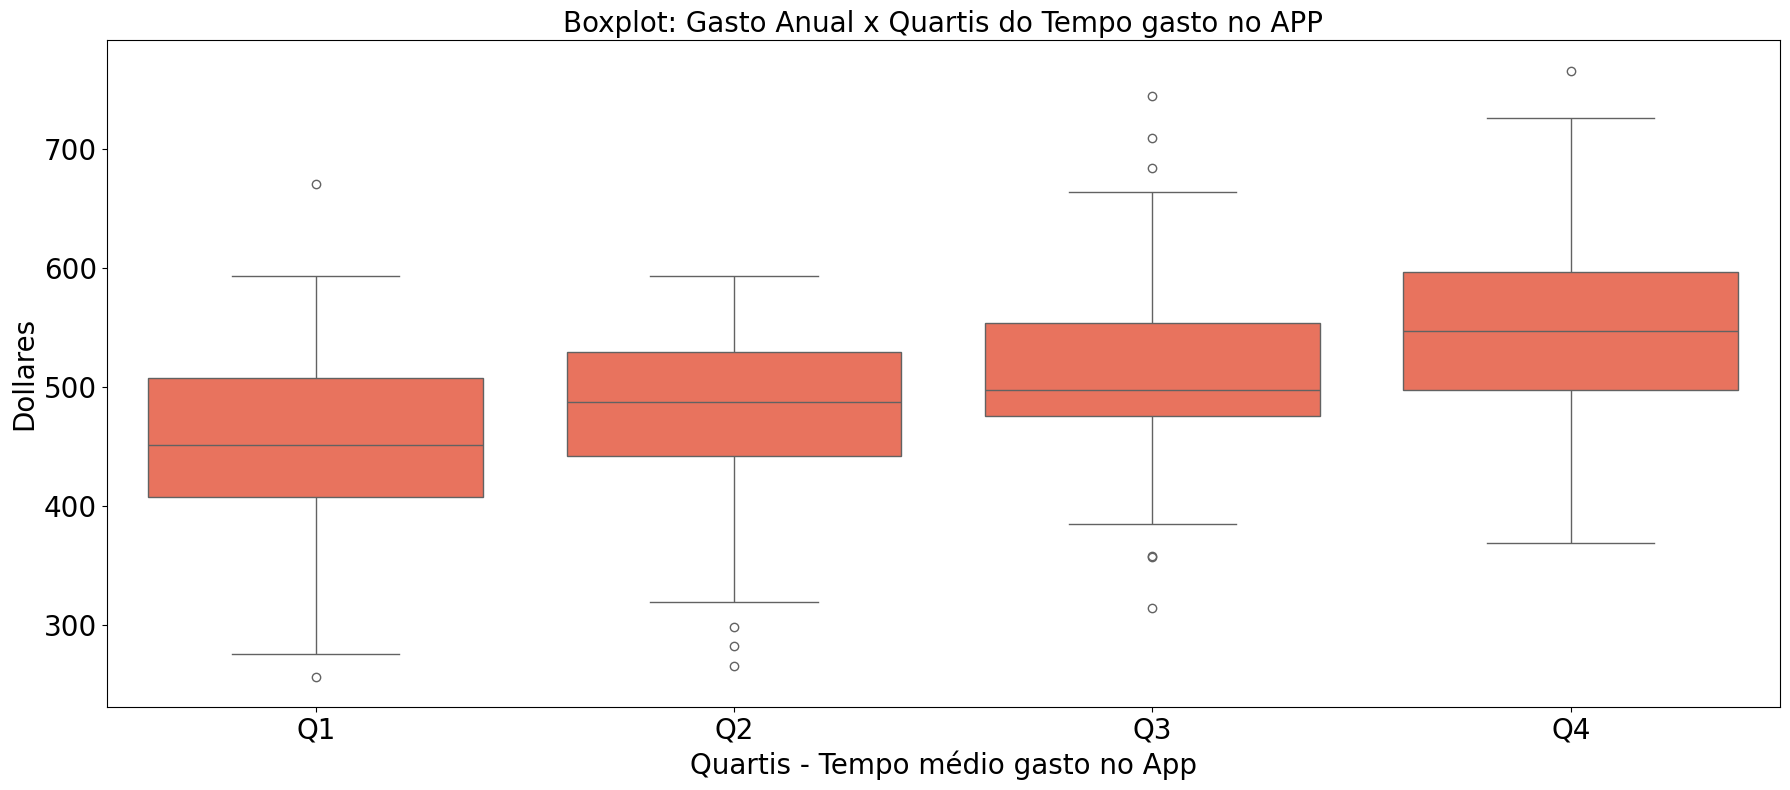

In [55]:
# Análise por quartis da variável tempo médio gasto no Aplicativo
aux1 = df4.copy()
fig = plt.figure( figsize = (18,8) )
# ordena investimentos pelos quartis e cria o rótulo
aux1['quartil_id'] = pd.qcut(aux1['tempo_app'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
cores = ['tomato','tomato','tomato','tomato']
sns.boxplot(data = aux1, x='quartil_id', y='gasto_anual',palette=cores, hue ='quartil_id', order=aux1['quartil_id'].sort_values(ascending = True).unique().tolist());

plt.title("Boxplot: Gasto Anual x Quartis do Tempo gasto no APP", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Quartis - Tempo médio gasto no App',fontsize=20)
plt.ylabel('Dollares',fontsize=20)
plt.tight_layout()
plt.show();

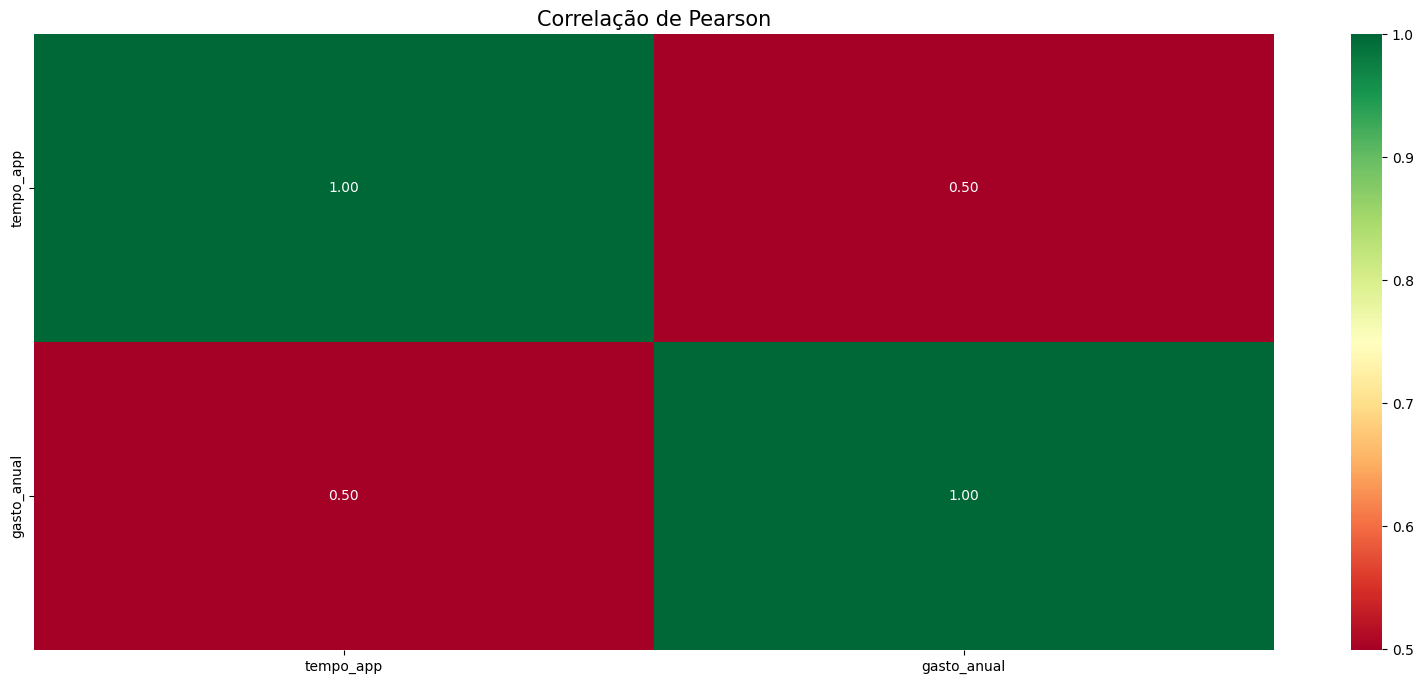

In [56]:
plt.figure(figsize=(20,8))
matriz = df4[['tempo_app', 'gasto_anual']]
sns.heatmap(matriz.corr(),annot=True, cmap="RdYlGn", fmt=".2f");
plt.title('Correlação de Pearson',size=15);

### 5.2.3 Tempo gasto no Website - Gasto Anual do Cliente

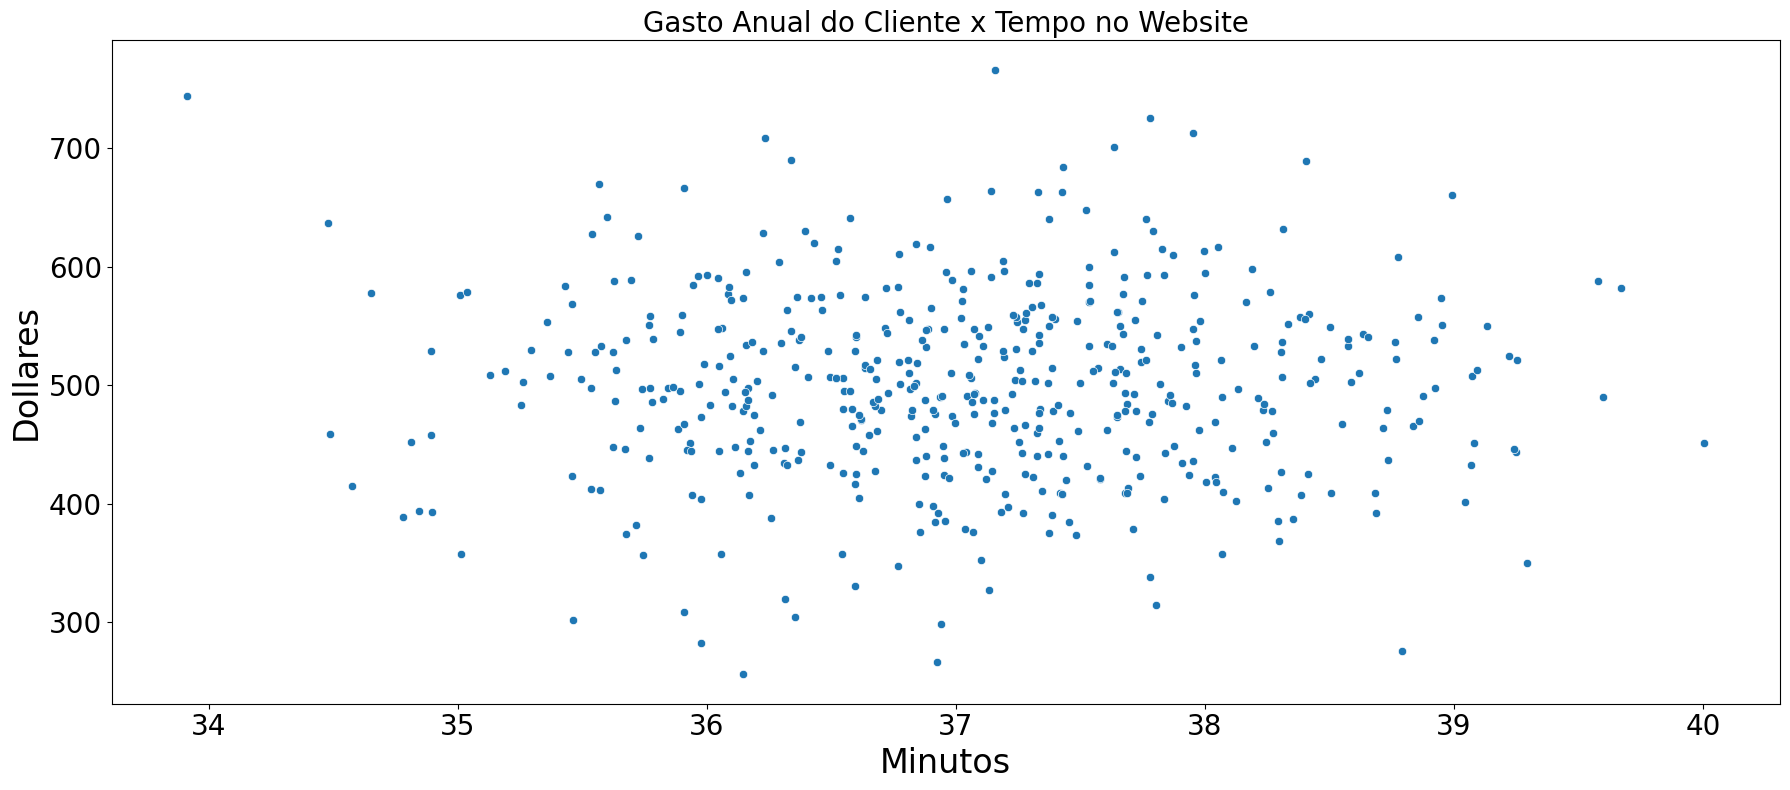

In [57]:
# Gráfico de dispersão
fig = plt.figure( figsize = (18,8) )
sns.scatterplot(data =df4, x='tempo_website',y='gasto_anual');

plt.title("Gasto Anual do Cliente x Tempo no Website", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Dollares',fontsize=24)
plt.xlabel("Minutos",fontsize=24)
plt.tight_layout()
plt.show();

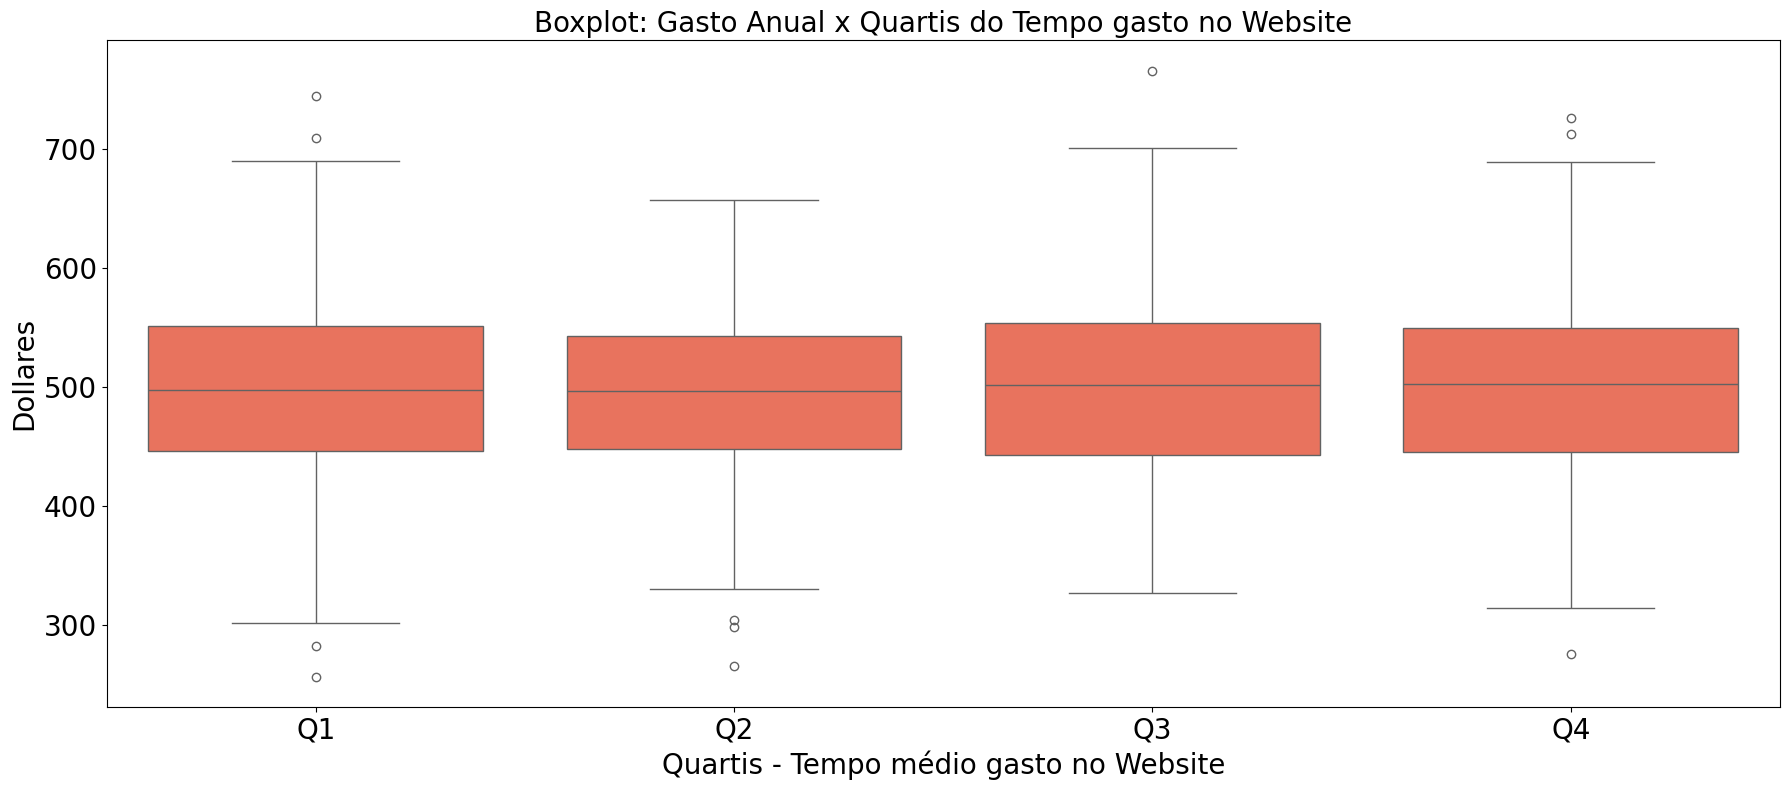

In [58]:
# Análise por quartis da variável tempo médio gasto no website
aux1 = df4.copy()
fig = plt.figure( figsize = (18,8) )
# ordena investimentos pelos quartis e cria o rótulo
aux1['quartil_id'] = pd.qcut(aux1['tempo_website'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
cores = ['tomato','tomato','tomato','tomato']
sns.boxplot(data = aux1, x='quartil_id', y='gasto_anual',palette=cores, hue ='quartil_id', order=aux1['quartil_id'].sort_values(ascending = True).unique().tolist());

plt.title("Boxplot: Gasto Anual x Quartis do Tempo gasto no Website", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Quartis - Tempo médio gasto no Website',fontsize=20)
plt.ylabel('Dollares',fontsize=20)
plt.tight_layout()
plt.show();

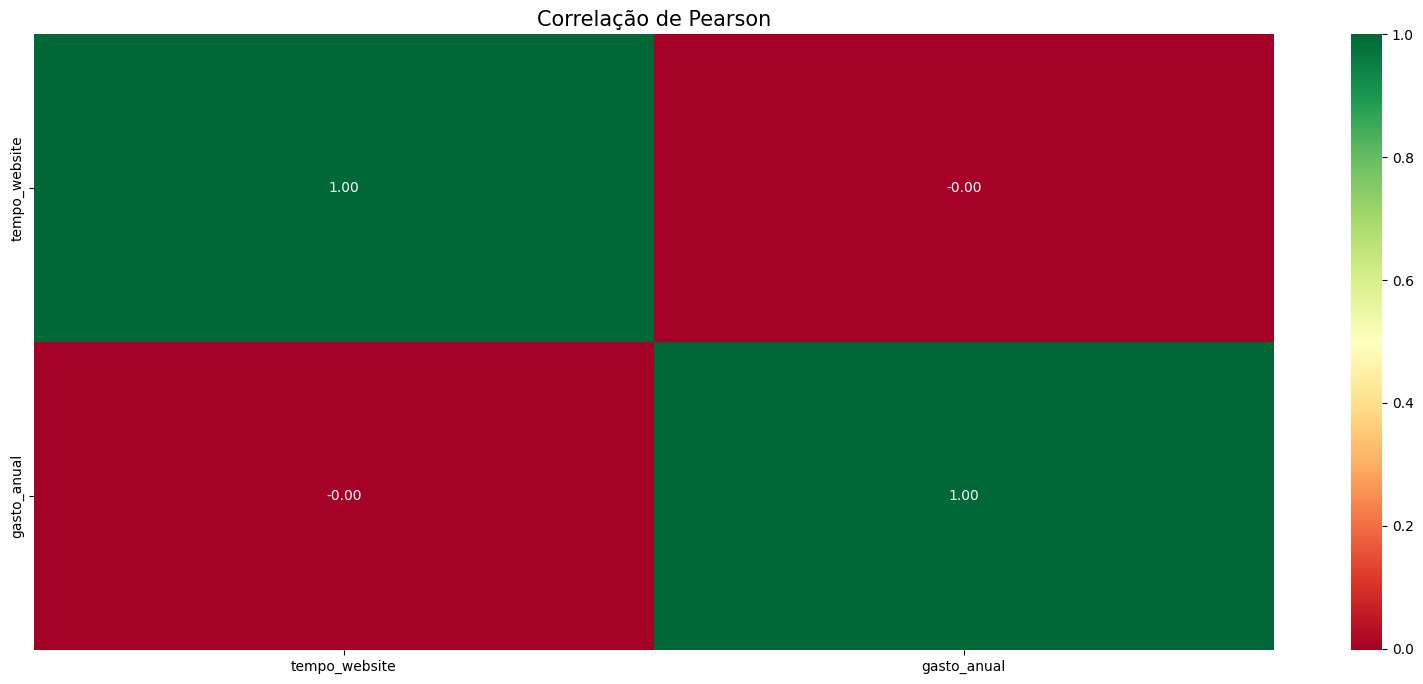

In [59]:
plt.figure(figsize=(20,8))
matriz = df4[['tempo_website', 'gasto_anual']]
sns.heatmap(matriz.corr(),annot=True, cmap="RdYlGn", fmt=".2f");
plt.title('Correlação de Pearson',size=15);

### 5.2.4 Tempo de membro - Gasto Anual do Cliente

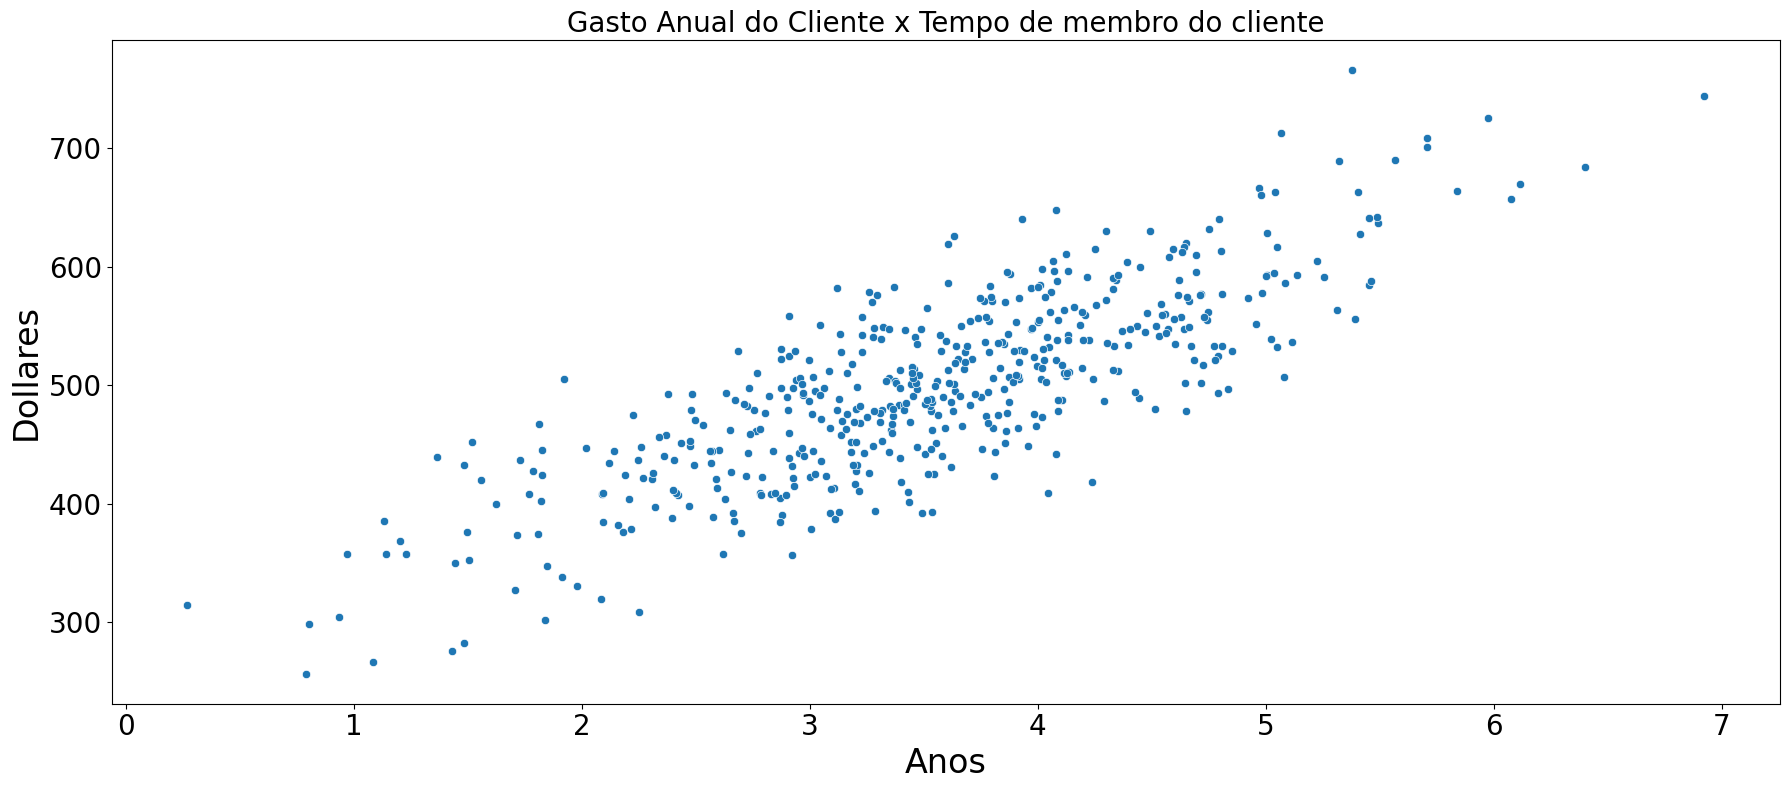

In [60]:
# Gráfico de dispersão
fig = plt.figure( figsize = (18,8) )
sns.scatterplot(data =df4, x='tempo_membro',y='gasto_anual');

plt.title("Gasto Anual do Cliente x Tempo de membro do cliente", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Dollares',fontsize=24)
plt.xlabel("Anos",fontsize=24)
plt.tight_layout()
plt.show();

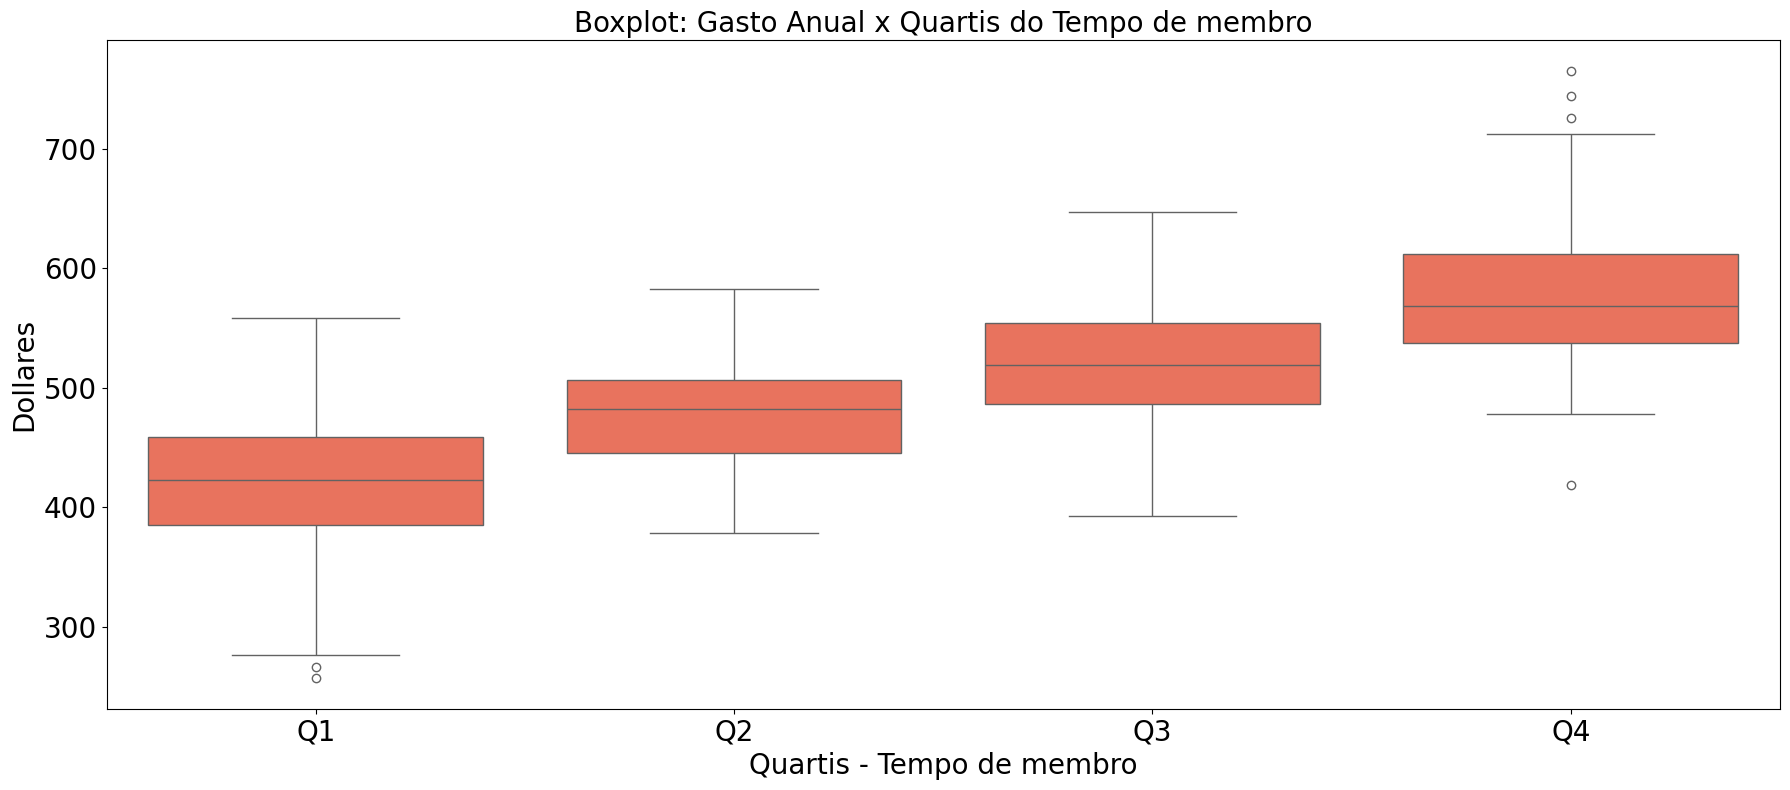

In [61]:
# Análise por quartis da variável tempo de membro na loja
aux1 = df4.copy()
fig = plt.figure( figsize = (18,8) )
# ordena investimentos pelos quartis e cria o rótulo
aux1['quartil_id'] = pd.qcut(aux1['tempo_membro'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
cores = ['tomato','tomato','tomato','tomato']
sns.boxplot(data = aux1, x='quartil_id', y='gasto_anual',palette=cores, hue ='quartil_id', order=aux1['quartil_id'].sort_values(ascending = True).unique().tolist());

plt.title("Boxplot: Gasto Anual x Quartis do Tempo de membro", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Quartis - Tempo de membro',fontsize=20)
plt.ylabel('Dollares',fontsize=20)
plt.tight_layout()
plt.show();

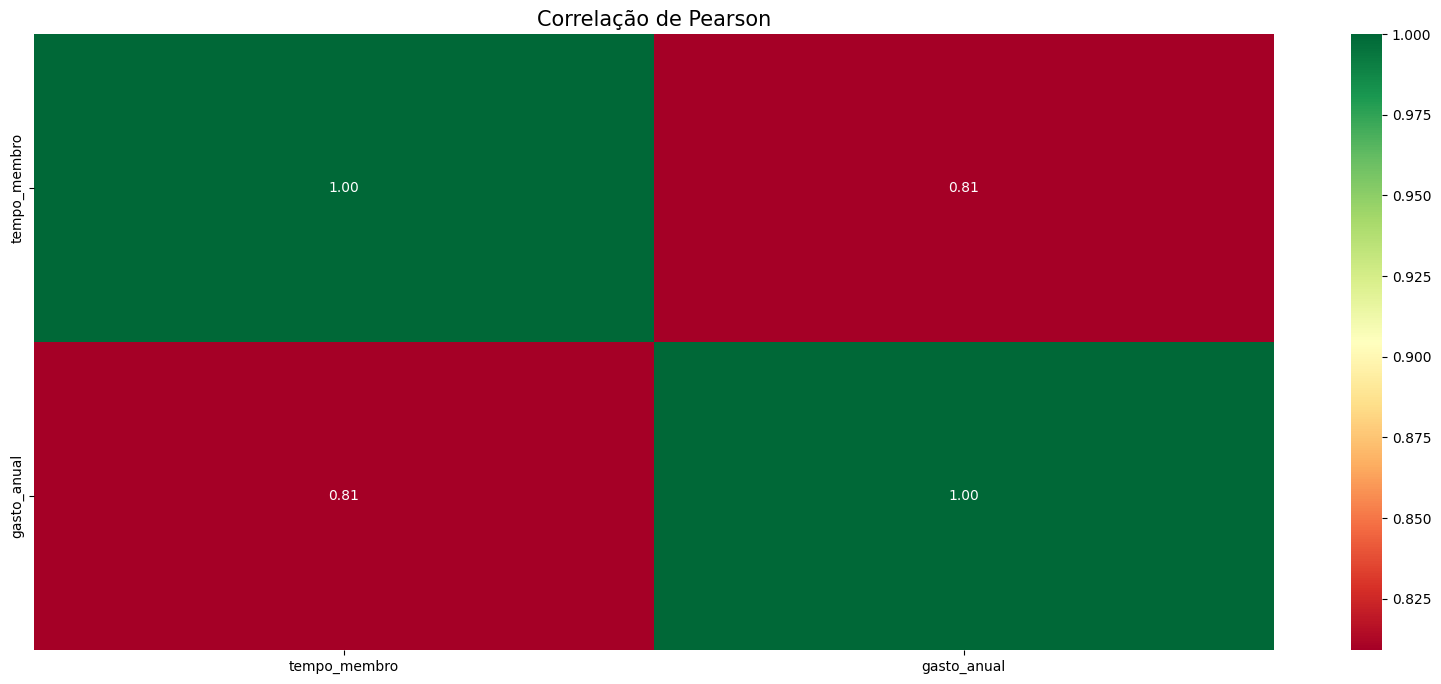

In [62]:
plt.figure(figsize=(20,8))
matriz = df4[['tempo_membro', 'gasto_anual']]
sns.heatmap(matriz.corr(),annot=True, cmap="RdYlGn", fmt=".2f");
plt.title('Correlação de Pearson',size=15);

# 6.0 Análise de correlação

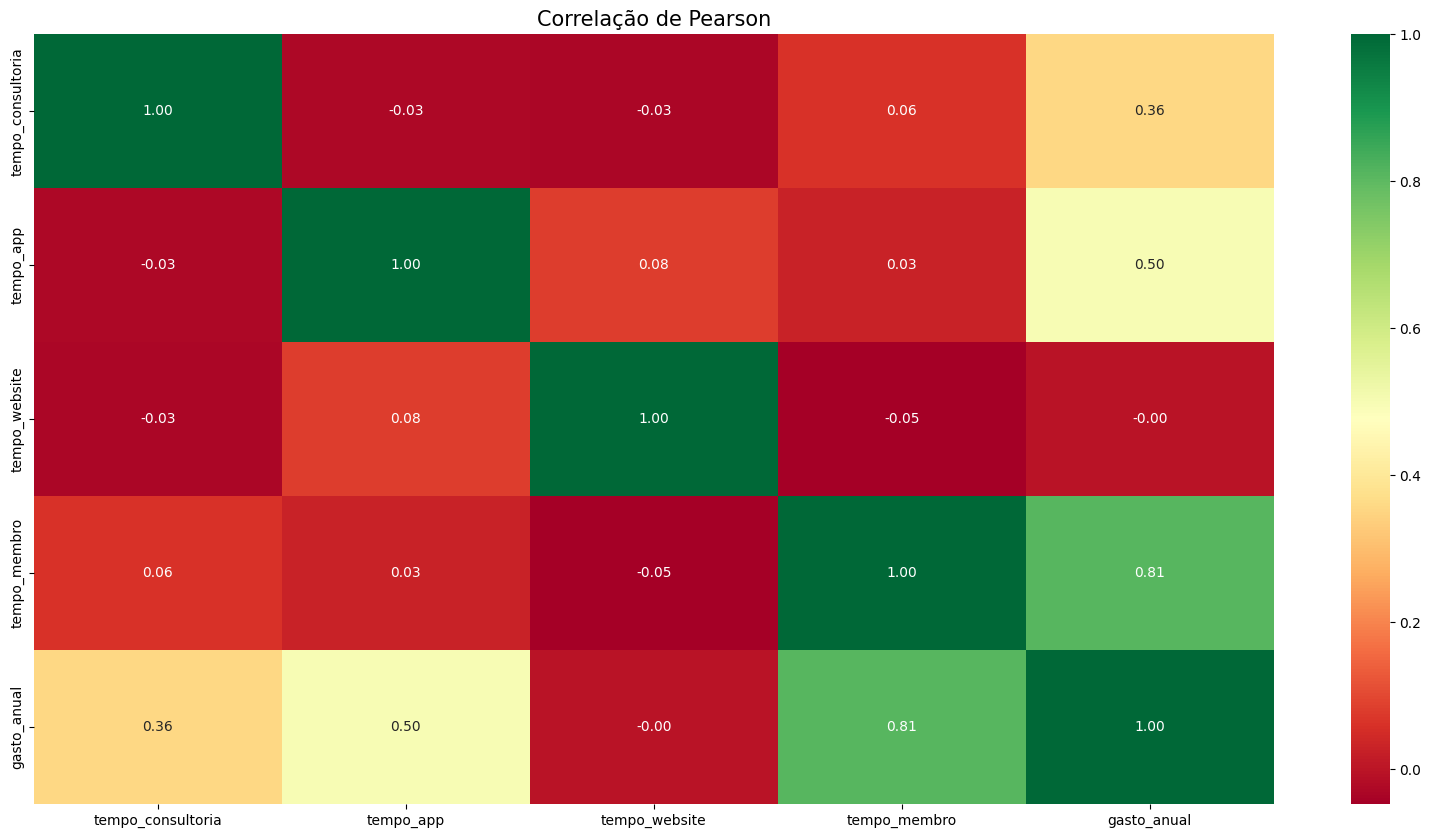

In [63]:
plt.figure(figsize=(20,10))
matriz = df4[['tempo_consultoria', 'tempo_app', 'tempo_website', 'tempo_membro','gasto_anual']].copy()
sns.heatmap(matriz.corr(),annot=True, cmap="RdYlGn", fmt=".2f");
plt.title('Correlação de Pearson',size=15);

| **Variável Independente (X)** | **Variável Dependente (Y)** | **Força da Correlação** | **Coeficiente (r)** | **Interpretação para Negócios** |
|-----------------------------|---------------------------|------------------------|-------------------|--------------------------------|
| Tempo como Membro | Gasto Anual | **Correlação Positiva Forte** | 0.81 | Clientes mais antigos gastam mais. |
| Tempo no APP | Gasto Anual | **Correlação Positiva Moderada** | 0.50 | Uso do app está relacionado com maior gasto, mas não é determinante. |
| Tempo de Consultoria | Gasto Anual | **Correlação Positiva Fraca** | 0.36 | Consultoria tem baixo impacto no gasto anual. |
| Tempo no Website | Gasto Anual | **Ausência de Correlação** | -0.00 | Nenhuma relação entre tempo no site e valor gasto. |

**Variáveis mais indicadas para o modelo**

* Tempo como membro e Tempo de APP são as mais indicadas.
* Tempo de consultoria pode não ser relevante
* Tempo no website deve ser removida

**Multicolinearidade entre Preditoras:**

* Não observamos alts correlações entre as variáveis independentes, o que indica que possivelmente não há multicolinearidade entre as variáveis. 


## 6.2 Cálculo de covariância

In [64]:
covariancia_matrix = df4[['tempo_consultoria', 'tempo_app', 'tempo_website', 'tempo_membro','gasto_anual']].cov()
covariancia_matrix

,tempo_consultoria,tempo_app,tempo_website,tempo_membro,gasto_anual
tempo_consultoria,0.985182,-0.027459,-0.035091,0.059756,27.954300
tempo_app,-0.027459,0.988465,0.082771,0.028953,39.374988
tempo_website,-0.035091,0.082771,1.021088,-0.048046,-0.211655
tempo_membro,0.059756,0.028953,-0.048046,0.998556,64.125922
gasto_anual,27.954300,39.374988,-0.211655,64.125922,6290.834572


# 7.0 Pressupostos

**Modelo**

A Regressão Linear Múltipla busca modelar a relação entre uma variável dependente (resposta) e algumas variáveis independentes (preditoras) através de uma equação linear: 

Y=β0+β1X+β2X+...+βnX+ϵ, onde:

    Y: Variável dependente (Gasto Anual do cliente na loja).
    X: Variáveis independentes (tempo médio gasto no app em minutos,tempo médio gasto no site em minutos, tempo como membro e Tempo médio das sessões de consultoria de estilo na loja).
    β0:Coeficiente de intercepto (valor de Y quando X é zero).
    β's:Coeficientes angulares (mudança em Y para cada unidade de mudança em X).
    ϵ: Termo de erro aleatório, representando a variabilidade não explicada pelo modelo.

Utilizaremos o método dos Mínimos Quadrados Ordinários (OLS) para estimar os coeficientes β0 e β's, que minimizam a soma dos quadrados dos resíduos.


**Expectativas de negócio, a priori, antes de rodar o modelo e que serão confirmadas ou não:** 

De acordo com as variáveis do problema tem-se as seguintes expectativas iniciais com relação aos gastos dos clientes na loja:

tempo_consultoria --> Se o tempo de consultoria para os clientes aumenta --> aumenta o gasto do cliente na loja

tempo_app --> Se o tempo médio utilizando o APP aumenta --> aumenta o gasto do cliente na loja

tempo_website --> Se o tempo médio utilizando o Website aumenta --> aumenta o gasto do cliente na loja

tempo_membro --> Se o tempo como membro aumenta --> aumenta o gasto do cliente na loja

**Considerações:** 

Independencia das variáveis do modelo.

Não há valores faltantes e duplicados na base do modelo.

**Coeficientes**

Após rodar o modelo será analisado a significancia estatistica dos coeficientes de forma individual e simultanea.

**Resíduos**

Após rodar o modelo é fundamental verificar se as suposições sobre os resíduos do modelo de regressão foram atendidas.

1. Homocedasticidade
2. Normalidade
3. Independência
4. Ausência de Outliers

**Multicolinearidade**

Após rodar o modelo é fundamental verificar se as variáveis independentes utilizadas no modelo apresentam multicolinearidade.

**Autocorrelação**

Após rodar o modelo é fundamental verificar se os termos de erro apresentam autocorrelação serial.



# 8.0 Padronização dos dados

In [65]:
df5 = df4.copy()

## 8.1 Padronização dos dados

**Considerações**

Na análise univarida foi observado que todas as variáveis seguem a distribuição normal. Portanto, é adequado a padronização dessas variáveis antes de rodar o modelo de regressão linear múltipla.

In [66]:
scaler = StandardScaler()

df5['tempo_consultoria'] = scaler.fit_transform(df5[['tempo_consultoria']].values)
df5['tempo_app'] = scaler.fit_transform(df5[['tempo_app']].values)
df5['tempo_website'] = scaler.fit_transform(df5[['tempo_website']].values)
df5['tempo_membro'] = scaler.fit_transform(df5[['tempo_membro']].values)
df5['gasto_anual'] = scaler.fit_transform(df5[['gasto_anual']].values)


In [67]:
df5.head()

,tempo_consultoria,tempo_app,tempo_website,tempo_membro,gasto_anual
0,1.456351,0.607280,2.493589,0.550107,1.118654
1,-1.136502,-0.949464,0.206556,-0.870927,-1.351783
2,-0.052723,-0.727139,0.049681,0.572067,-0.148501
3,1.263010,1.676390,-0.335978,-0.413996,1.041684
4,0.279838,0.747770,0.471737,0.914422,1.263224


# 9.0 Modelos

In [68]:
df6 = df5.copy()

## 9.1 Modelo com todas as variáveis

### 9.1.1 Modelagem

In [69]:
y = df6[['gasto_anual']].copy()
x = df6[['tempo_consultoria', 'tempo_app', 'tempo_website', 'tempo_membro']].copy()
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            gasto_anual   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     7766.
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:21:20   Log-Likelihood:                 329.30
No. Observations:                 500   AIC:                            -648.6
Df Residuals:                     495   BIC:                            -627.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -1.18e-16      0.00

In [70]:
# valores preditos e residuos e métricas
df6['valor_predito'] = model.fittedvalues
df6['residuo']= model.resid
mae = mean_absolute_error(df6['gasto_anual'], df6['valor_predito'])
mse = mean_squared_error(df6['gasto_anual'], df6['valor_predito'])
rmse = np.sqrt(mse)

In [71]:
# Criar DataFrame com Métricas
resultados_df_4 = pd.DataFrame({
    'modelo': ['modelo_todas_variáveis'],
    'Quantidade_de_variaveis_independentes': [x.shape[1] - 1],  # Excluindo a constante
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'AIC': [model.aic],
    'BIC': [model.bic],
    'R²':  [model.rsquared]
})

#### **Considerações sobre os coeficientes de determinação**

**Coeficiente de determinação - R quadrado**

O valor do R² = 0.984,  o que indica que o modelo é capaz de explicar a variabilidade do resultado das vendas em 98.4 % a partir das variáveis independentes utilizadas.

**Coeficiente de determinação ajustado - R² Ajustado**

O valor do Adj. R-squared = 0.984,  o que indica que o modelo é capaz de explicar a variabilidade do resultado das vendas em  98.4 % a partir das variáveis independentes utilizadas.


#### **Estatística F**

Teste dos coeficientes simultaneamente iguais a zero.

F-statistic: 7766.

Prob (F-statistic): 0.00

**Hipoteses:**

H0: Todos os coeficientes são simultaneamentes iguais a zero. --> p-valor < 0.05

H1: Pelo menos um dos coeficientes é diferente de zero.

p-valor = 0.00 < 0.05

Rejeita H0: Pelo menos um dos coeficientes é diferente de zero, o **Modelo é estaisticamente significativo.**

#### **Teste t-Student dos coeficientes**

**Estatística t-student - p-valor**

Verifica a significância estatística individual de cada coeficiente. 

Hipoteses:

H0: Coeficiente angular da variável é igual a zero. --> p-valor < 0.05

H1: Coeficiente angular é diferente de zero.

==================================================================================================

const  -- > t=  -2.1e-14--> p-valor= 1.000 > 0.05 --> **coeficiente não é estatisticamente significativo**

tempo_consultoria --> t= 57.057 --> p-valor= 0.000 < 0.05 --> **coeficiente é estatisticamente significativo**.

tempo_app --> t= 85.828 --> p-valor= 0.000 < 0.05--> **coeficiente é estatisticamente significativo**

tempo_website -->  t= 0.983 -->  p-valor= 0.326 > 0.05--> <font color='red'>**coeficiente não é estatisticamente significativo**</f> --> Neste modelo a variável não tem efeito sobe a variavel resposta.

tempo_membro --> t= 137.346 --> p-valor= 0.000 < 0.05 --> **coeficiente é estatisticamente significativo**.


#### **Expectativas e pressupostos sobre os coeficientes**

**Expectativas de negócio** 

De acordo com as variáveis do problema tem-se as seguintes expectativas iniciais com relação aos gastos dos clientes na loja:

tempo_consultoria --> Se o tempo de consultoria para os clientes aumenta --> aumenta o gasto do cliente na loja.

tempo_app --> Se o tempo médio utilizando o APP aumenta --> aumenta o gasto do cliente na loja.

tempo_website --> Se o tempo médio utilizando o Website aumenta --> aumenta o gasto do cliente na loja.

tempo_membro --> Se o tempo como membro aumenta --> aumenta o gasto do cliente na loja.

===========================================================================================================

**Análise do sinal dos coeficientes do modelo.**


tempo_consultoria --> coef. = 0.322 --> Se o tempo de consultoria para os clientes aumenta --> aumenta o gasto do cliente na loja.

tempo_app --> coef. = 0.4852 --> Se o tempo médio utilizando o APP aumenta --> aumenta o gasto do cliente na loja.

tempo_website -->  coef. = 0.0056 -->  Se o tempo médio utilizando o Website aumenta --> aumenta o gasto do cliente na loja.

tempo_membro --> coef. = 0.7758 --> Se o tempo como membro aumenta --> aumenta o gasto do cliente na loja.

**Análise de explicabilidade**

A variável que mais explica as variações da variavel resposta: Tempo como membro na loja. 

A Segunda variável que mais explica as variações da variavel resposta: Tempo gasto no aplicativo.

Terceira variável que mais explica as variações da variavel resposta: Tempo de consultoria de estilo na loja. 

A variável tempo de website além de não apresentar significancia estatística também apresentou o menor coeficiente. 

### 9.1.2 Análise dos resíduos

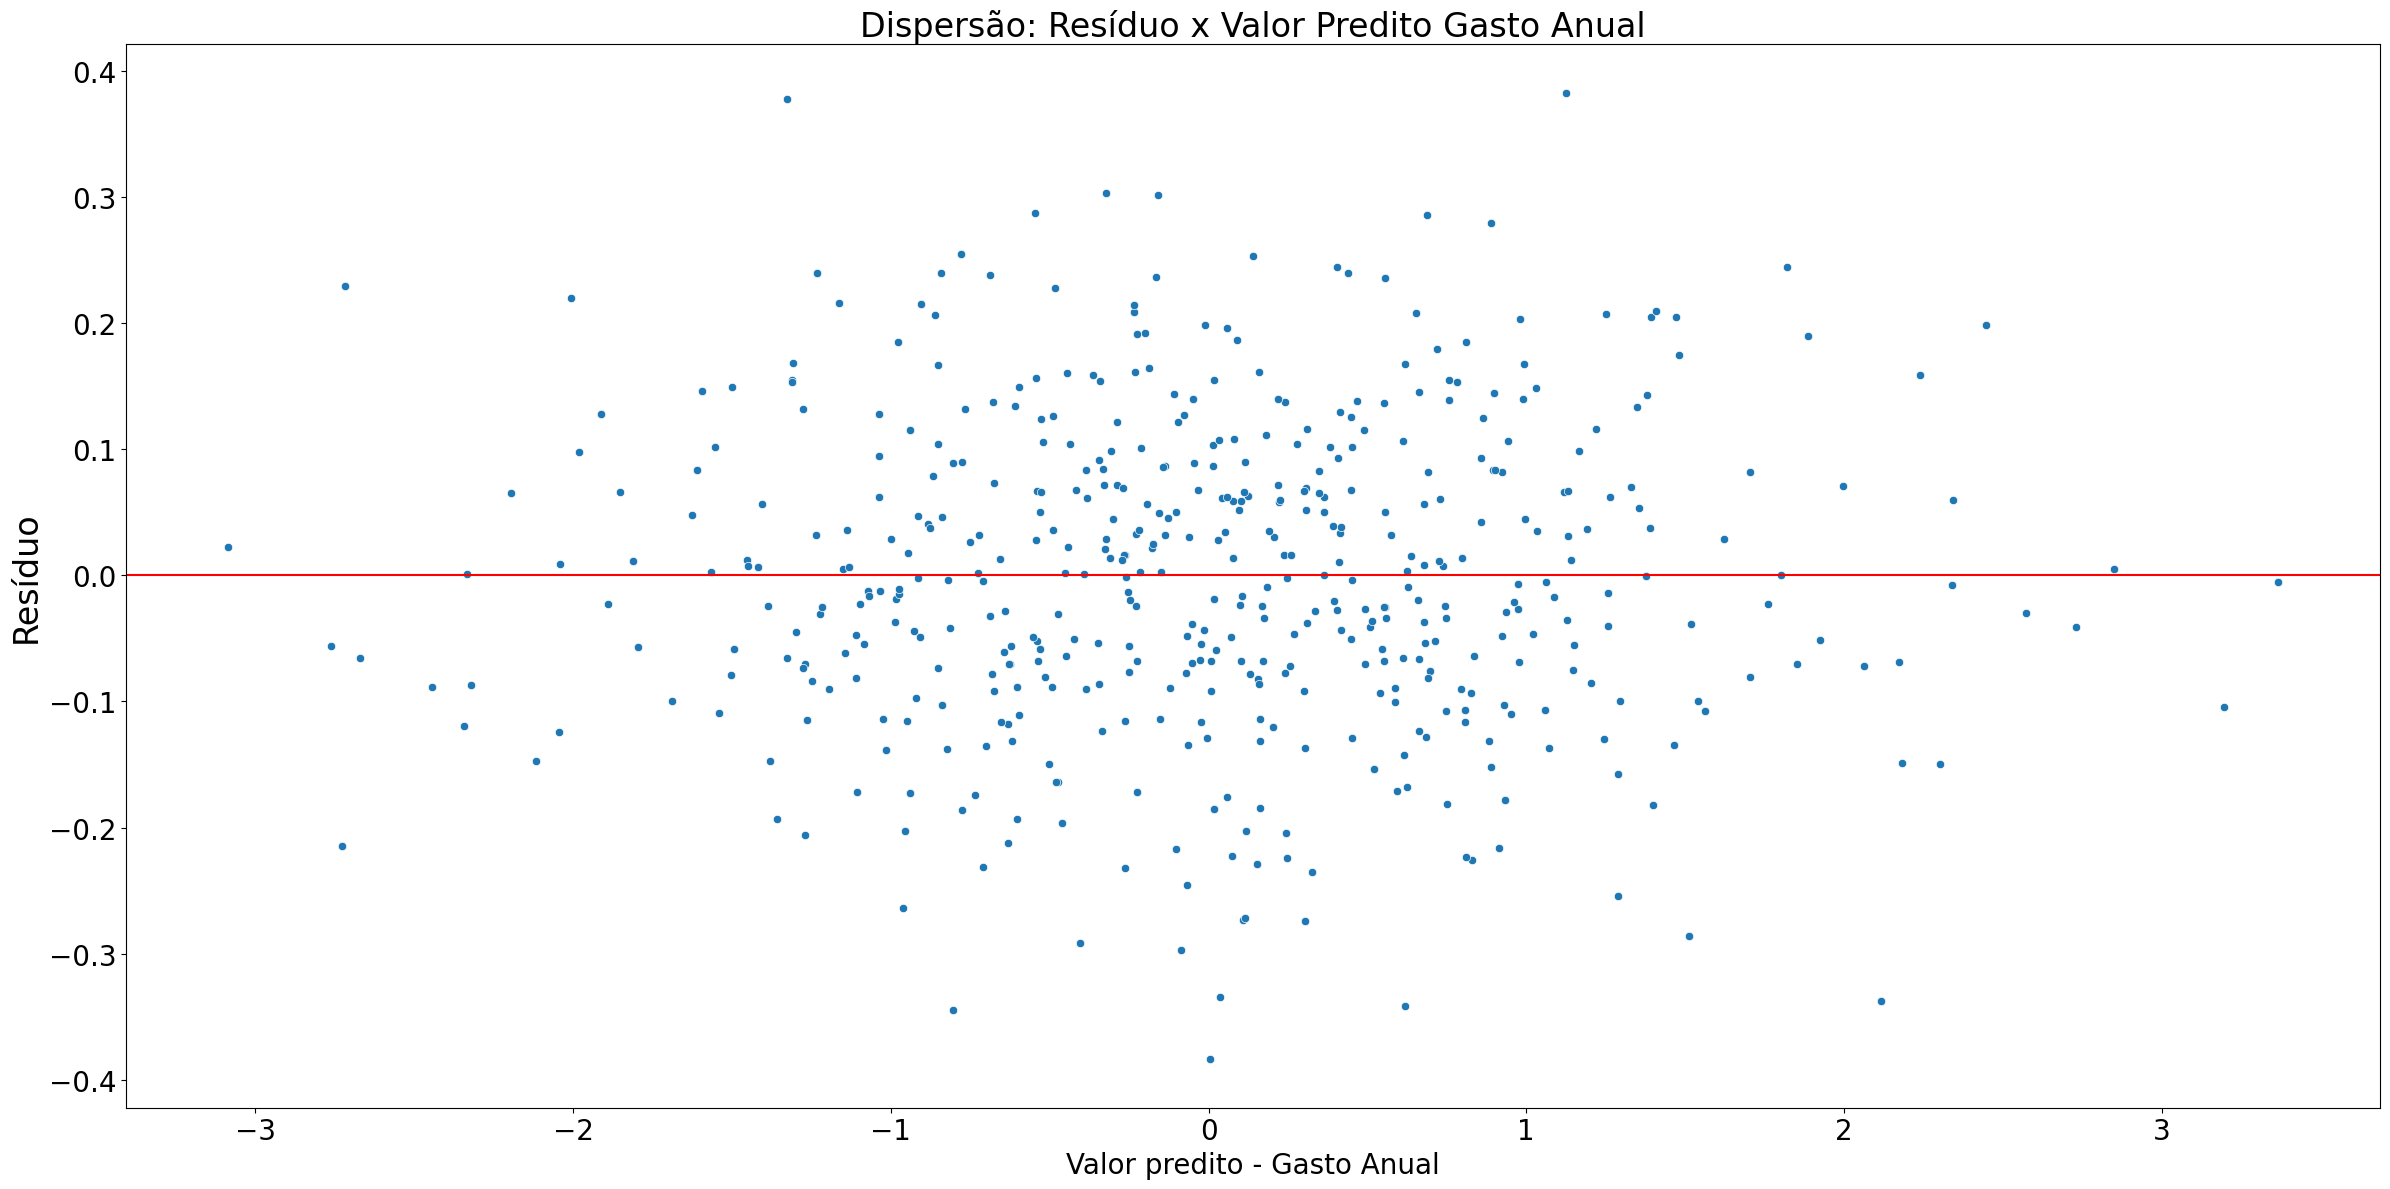

In [72]:
#Dispersao do residuo em funcao do valor predito do gasto anual do cliente
fig = plt.figure( figsize = (24,12) )
                
sns.scatterplot( x = 'valor_predito', y = 'residuo', data = df6 )
plt.axhline(y=0, color='r');

plt.title("Dispersão: Resíduo x Valor Predito Gasto Anual", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Valor predito - Gasto Anual',fontsize=20)
plt.ylabel('Resíduo',fontsize=24)
plt.tight_layout()
plt.show();

**Análise do gráfico de dispersão**

No gráfico , observa-se um padrão em forma de túnel o que indica comportamento de homocedasticidade.

### 9.1.3  Teste de Homocedasticidade - Breusch-Pagan

Testa se a variância do erro depende das variáveis explicativas e ocorre quando a variância dos erros não é constante.

Hipóteses:

H0: Homocedasticidade (variância constante dos erros) --> p-valor <0.05

H1: Heteroscedasticidade (variância não constante)

In [73]:
run_breuschpagan_test('com todas as variáveis', model, x) 


--- Teste de Breusch-Pagan para com todas as variáveis ---
Estatística de Teste: 5.9772
P-valor: 0.2009

F-Estatística: 1.4973
P-valor F: 0.2018

Conclusão: Não rejeitamos H0. Há evidências de homocedasticidade no modelo com todas as variáveis.


### 9.1.4 Histograma dos resíduos

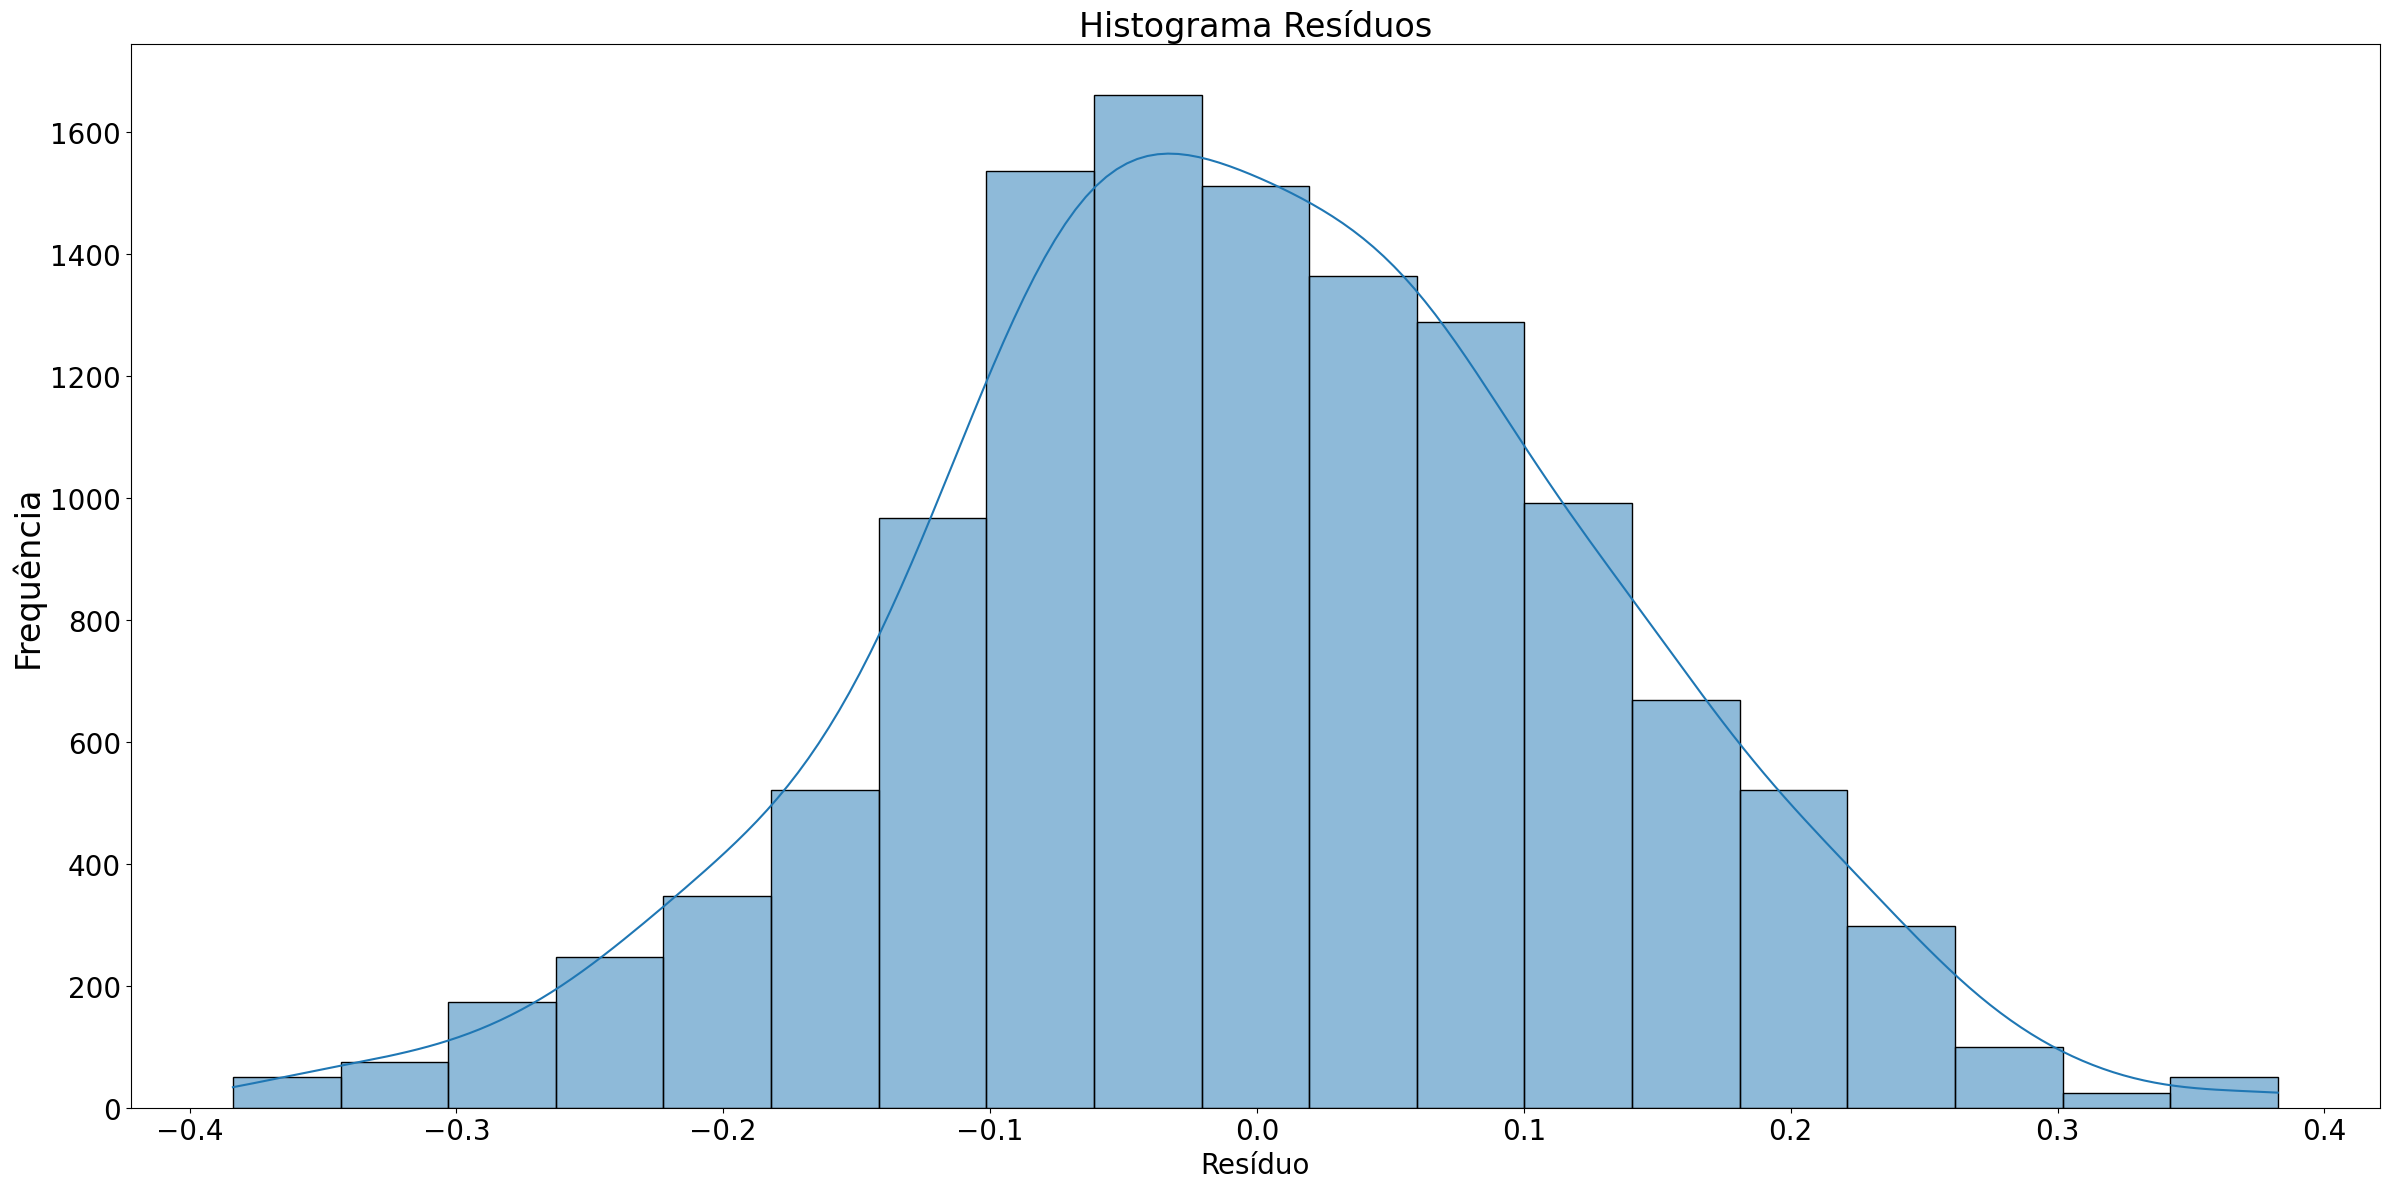

In [74]:
# histograma resíduos
fig = plt.figure( figsize = (24,12) )

sns.histplot( x = 'residuo', data = df6, stat = 'frequency', kde=True);

plt.title("Histograma Resíduos", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Resíduo',fontsize=20)
plt.ylabel('Frequência',fontsize=24)
plt.tight_layout()
plt.show();

**Após a análise do gráfico de histograma há evidencias que os resíduos do modelo seguem a distribuição normal.**

### 9.1.5 Teste de Normalidade dos Resíduos com Shapiro-Wilk

In [75]:
run_shapiro_wilk_test('com todas as variáveis', df6['residuo'])


--- Teste de Shapiro-Wilk para com todas as variáveis ---
Estatística de Teste: 0.9978
P-valor: 0.7716
Conclusão: Não rejeitamos H0. Os resíduos do modelo com todas as variáveis seguem uma distribuição normal.


**Conclusão sobre o teste de Normalidade de Shapiro-Wilk**

**Shapiro-Wilk: p-valor = 0.7716**

Hipóteses:

H0: Os dados seguem uma distribuição normal --> p-valor < 0.05

H1: Os dados não seguem uma distribuição normal

p-valor = 00.7716 > 0.05

Não Rejeitamos H0. Os resíduos do modelo Modelo seguem uma distribuição normal.

### 9.1.6 Análise de Normalidade


--- Análise Gráfica de Normalidade (Q-Q Plot) ---


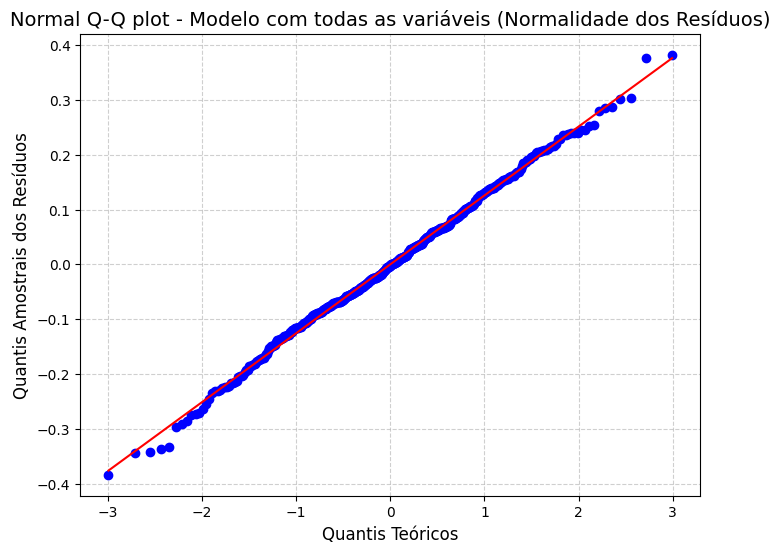

In [76]:
print("\n--- Análise Gráfica de Normalidade (Q-Q Plot) ---")
plot_qq('Modelo com todas as variáveis',  df6['residuo'].values)

**Observa-se que os Q-Q plots do modelo indicam que não há pontos que se afastam da reta, indicando a mesma conclusão do teste de normalidade.**

### 9.1.7 Análise de Outliers

In [77]:
mean_resid = np.mean(df6['residuo'] )
std_resid  = np.std(df6['residuo'] )
df6['residuos_std'] = df6['residuo'].apply( lambda x: (x - mean_resid) / std_resid )

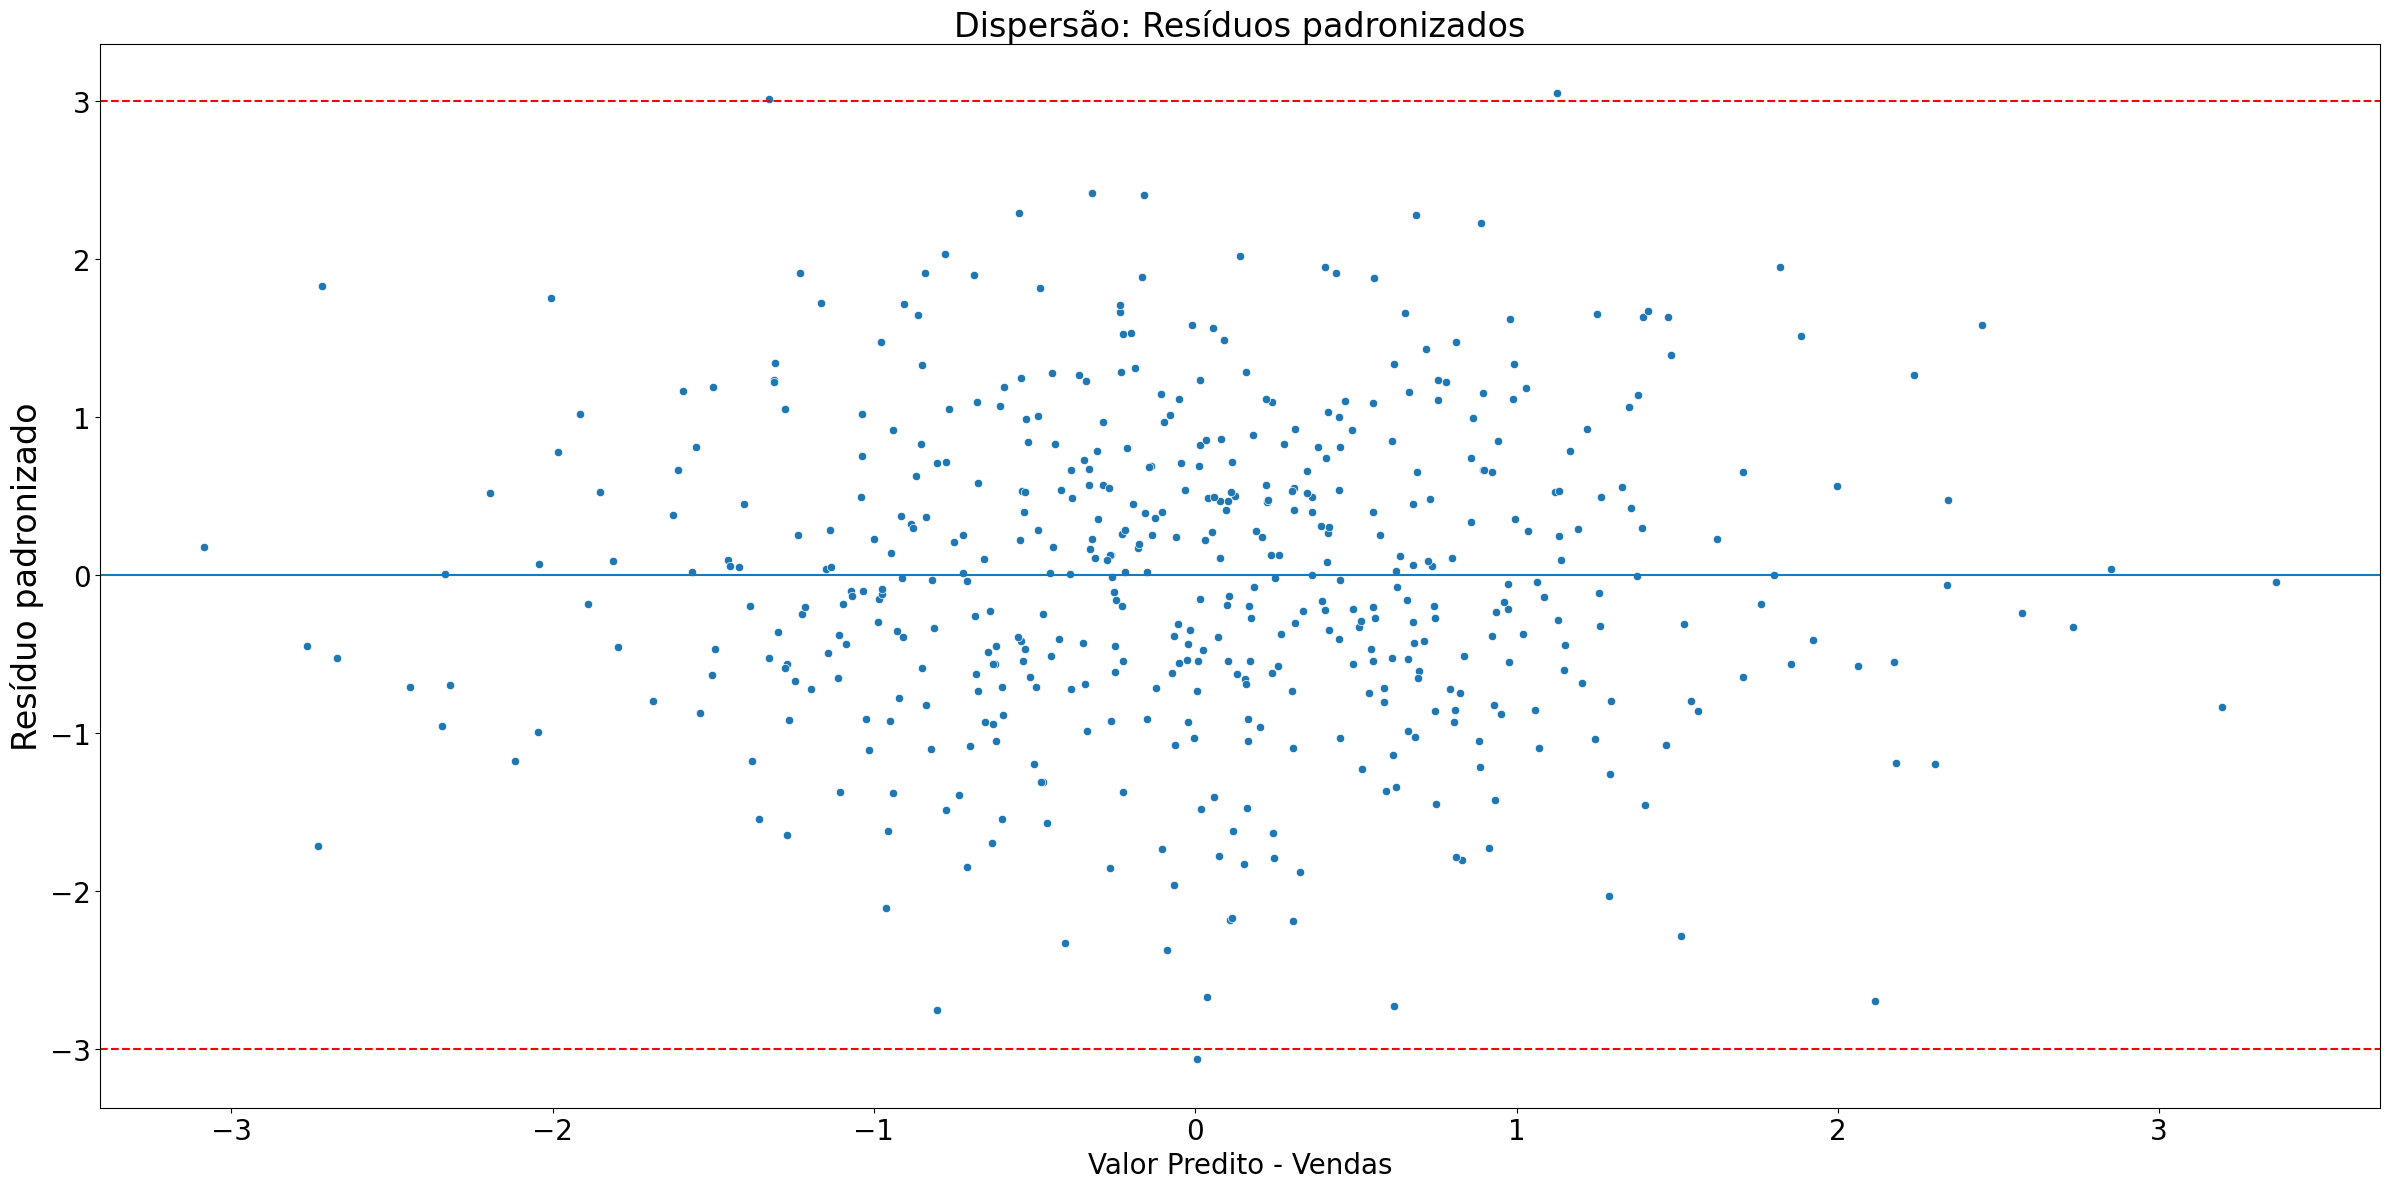

In [78]:
#Dispersao do residuo em funcao do valor predito do resultado vendas
fig = plt.figure( figsize = (24,12) )
sns.scatterplot( x = 'valor_predito', y = 'residuos_std', data = df6 )
plt.axhline(y=0);
plt.axhline(y=3,  linestyle='--', label='Limite Superior (+3)',color='r');
plt.axhline(y=-3, linestyle='--', label='Limite Inferior (-3)',color='r');

plt.title("Dispersão: Resíduos padronizados", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Valor Predito - Vendas',fontsize=20)
plt.ylabel('Resíduo padronizado',fontsize=24)
plt.tight_layout()
plt.show();


**No gráfico há indicativo de valores outliers que ultrapassam 3 desvios, porém estão bem próximos da região limite.**

### 9.1.8 Análise de Multicolinearidade

In [79]:
df7 = df6.copy()
df7.head()

,tempo_consultoria,tempo_app,tempo_website,tempo_membro,gasto_anual,valor_predito,residuo,residuos_std
0,1.456351,0.607280,2.493589,0.550107,1.118654,1.204326,-0.085672,-0.684073
1,-1.136502,-0.949464,0.206556,-0.870927,-1.351783,-1.501225,0.149442,1.193270
2,-0.052723,-0.727139,0.049681,0.572067,-0.148501,0.074286,-0.222787,-1.778915
3,1.263010,1.676390,-0.335978,-0.413996,1.041684,0.897117,0.144568,1.154348
4,0.279838,0.747770,0.471737,0.914422,1.263224,1.164992,0.098231,0.784358


In [80]:
df7.columns

Index(['tempo_consultoria', 'tempo_app', 'tempo_website', 'tempo_membro',
       'gasto_anual', 'valor_predito', 'residuo', 'residuos_std'],
      dtype='object')

In [81]:
# Selecionando as variáveis independentes
aux1 = df7[['tempo_consultoria', 'tempo_app', 'tempo_website', 'tempo_membro']].copy()

# lista das variáveis indenpendentes
features_2 = list(aux1.columns)

# variaveis auxiliares r2, tolerancia, FIV
r2  = []
tol = []
fiv=[]

# Calcule VIF para cada variável
for i in aux1.columns:
    
    y = aux1[[i]].copy()
    features_2.remove(i)
    x = aux1[features_2]
    features_2 = list(aux1.columns)

    # modelo
    x = sm.add_constant(x)
    model = sm.OLS(y,x).fit()
    predictions = model.predict(x)
                               
    # r2
    r2.append(model.rsquared)
             
    # calculo tolerância
    aux2 = 1- model.rsquared
    tol.append(aux2)
         
    # calculo FIV
    aux3=round(1/(1-model.rsquared),2)
    fiv.append(aux3)
    
tab_multicolinearidade = pd.DataFrame()
tab_multicolinearidade['var_indep'] = list(aux1.columns)
tab_multicolinearidade['r2']  = r2
tab_multicolinearidade['tol'] = tol  
tab_multicolinearidade['fiv'] = fiv  
tab_multicolinearidade

,var_indep,r2,tol,fiv
0,tempo_consultoria,0.005392,0.994608,1.01
1,tempo_app,0.008610,0.991390,1.01
2,tempo_website,0.010171,0.989829,1.01
3,tempo_membro,0.006901,0.993099,1.01


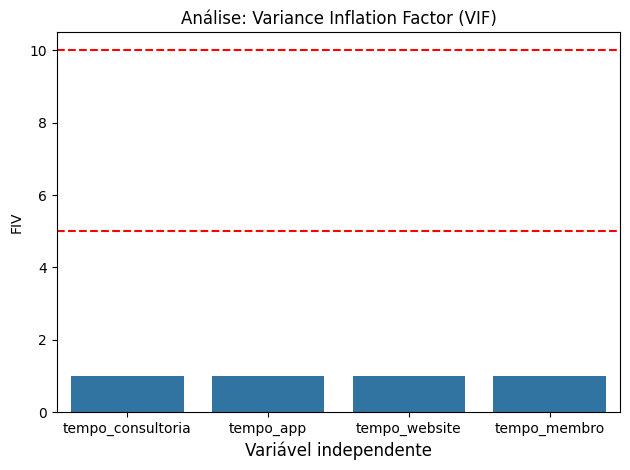

In [82]:
sns.barplot(data=tab_multicolinearidade,y='fiv',x='var_indep');

plt.axhline(y=10,  linestyle='--', label='Limite Superior (+10)',color='r');
plt.axhline(y=5, linestyle='--', label='Limite Inferior (+5)',color='r');

plt.title("Análise: Variance Inflation Factor (VIF)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Variável independente',fontsize=12)
plt.ylabel('FIV',fontsize=10)
plt.tight_layout()

plt.show();


### 9.1.9 Análise de autocorrelação dos resíduos

In [83]:
estatistica_dw = durbin_watson(df6['residuo'].values)
print('O valor calculado da estatística do teste de Durbin - Watson corresponde a: {:.4f} '.format(estatistica_dw))

O valor calculado da estatística do teste de Durbin - Watson corresponde a: 1.8866 


A estatística DW varia entre 0 e 4.

Interpretação:

1. DW ≈ 2	Sem autocorrelação (resíduos independentes)

2. DW < 2	Autocorrelação positiva (erros consecutivos tendem a ter o mesmo sinal)

3. DW > 2 Autocorrelação negativa (erros alternam sinal entre observações)

**Durbin-Watson = 1.8866 --> Baixa autocorrelação positiva, o que indica que os resíduos consecutivos tendem a ter o mesmo sinal**

### 9.1.10 Performance do modelo

In [84]:
r2_rf = r2_score(df6['gasto_anual'], df6['valor_predito'])
mse_rf = mean_squared_error(df6['gasto_anual'], df6['valor_predito'])
mae_rf = mean_absolute_error(df6['gasto_anual'], df6['valor_predito'])
rmse_rf = np.sqrt(mse_rf)

print("Regressão Linear lasso - Múltipla todas as variáveis:")
print(f"R²: {r2_rf}")
print(f"MSE: {mse_rf}")
print(f"MAE: {mae_rf}")
print(f"RMSE: {rmse_rf}")

Regressão Linear lasso - Múltipla todas as variáveis:
R²: 0.9843155370226726
MSE: 0.01568446297732738
MAE: 0.099414657712256
RMSE: 0.1252376260447609


### 9.1.11 Conclusão modelo com todas as variáveis

**O modelo com as todas variáveis independetes, não está corretamente especificado para representar a verdadeira relação com a variável resposta "gasto anual do cliente".**

1. Há uma variável estatísticamente irrelevante no modelo --> O coeficiente da variável "tempo médio gasto no Website"  não apresenta significancia estatística.
2. Após a análise de autocorrelação dos resíduos foi possível concluir que há evidencias de baixa autocorrelação positiva dos resíduos do modelo

## 9.2 Modelo variáveis com significancia estatística

### 9.2.1 Modelagem

In [85]:
y = df6[['gasto_anual']].copy()
x = df6[['tempo_consultoria', 'tempo_app', 'tempo_membro']].copy()
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            gasto_anual   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 1.036e+04
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:21:22   Log-Likelihood:                 328.81
No. Observations:                 500   AIC:                            -649.6
Df Residuals:                     496   BIC:                            -632.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -1.18e-16      0.00

In [86]:
# valores preditos e residuos e métricas
df6['valor_predito'] = model.fittedvalues
df6['residuo']= model.resid
mae = mean_absolute_error(df6['gasto_anual'], df6['valor_predito'])
mse = mean_squared_error(df6['gasto_anual'], df6['valor_predito'])
rmse = np.sqrt(mse)

In [87]:
# Criar DataFrame com Métricas
resultados_df_3 = pd.DataFrame({
    'modelo': ['modelo_variaiveis_significativas'],
    'Quantidade_de_variaveis_independentes': [x.shape[1] - 1],  # Excluindo a constante
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'AIC': [model.aic],
    'BIC': [model.bic],
    'R²':  [model.rsquared]
})

#### **Considerações sobre os coeficientes de determinação**

**Coeficiente de determinação - R quadrado**

O valor do R² = 0.984,  o que indica que o modelo é capaz de explicar a variabilidade do resultado das vendas em 98.4 % a partir das variáveis independentes utilizadas.

**Coeficiente de determinação ajustado - R² Ajustado**

O valor do Adj. R-squared = 0.984,  o que indica que o modelo é capaz de explicar a variabilidade do resultado das vendas em  98.4 % a partir das variáveis independentes utilizadas.


#### **Estatística F**

Teste dos coeficientes simultaneamente iguais a zero.

F-statistic: 1.036e+04

Prob (F-statistic): 0.00

**Hipoteses:**

H0: Todos os coeficientes são simultaneamentes iguais a zero. --> p-valor < 0.05

H1: Pelo menos um dos coeficientes é diferente de zero.

p-valor = 0.00 < 0.05

Rejeita H0: Pelo menos um dos coeficientes é diferente de zero, o **Modelo é estaisticamente significativo.**

#### **Teste t-Student dos coeficientes**

**Estatística t-student - p-valor**

Verifica a significância estatística individual de cada coeficiente. 

Hipoteses:

H0: Coeficiente angular da variável é igual a zero. --> p-valor < 0.05

H1: Coeficiente angular é diferente de zero.

==================================================================================================

const  -- > t=  -2.1e-14--> p-valor= 1.000 > 0.05 --> **coeficiente não é estatisticamente significativo**

tempo_consultoria --> t= 57.055 --> p-valor= 0.000 < 0.05 --> **coeficiente é estatisticamente significativo**.

tempo_app --> t= 86.210 --> p-valor= 0.000 < 0.05--> **coeficiente é estatisticamente significativo**

tempo_membro --> t= 137.464 --> p-valor= 0.000 < 0.05 --> **coeficiente é estatisticamente significativo**.


#### **Expectativas e pressupostos sobre os coeficientes**

**Expectativas de negócio** 

De acordo com as variáveis do problema tem-se as seguintes expectativas iniciais com relação aos gastos dos clientes na loja:

tempo_consultoria --> Se o tempo de consultoria para os clientes aumenta --> aumenta o gasto do cliente na loja.

tempo_app --> Se o tempo médio utilizando o APP aumenta --> aumenta o gasto do cliente na loja.

tempo_website --> Se o tempo médio utilizando o Website aumenta --> aumenta o gasto do cliente na loja.

tempo_membro --> Se o tempo como membro aumenta --> aumenta o gasto do cliente na loja.

===========================================================================================================

**Análise do sinal dos coeficientes do modelo.**


tempo_consultoria --> coef. = 0.3219 --> Se o tempo de consultoria para os clientes aumenta --> aumenta o gasto do cliente na loja.

tempo_app --> coef. = 0.4857 --> Se o tempo médio utilizando o APP aumenta --> aumenta o gasto do cliente na loja.

tempo_website -->  coef. = 0.0056 -->  Se o tempo médio utilizando o Website aumenta --> aumenta o gasto do cliente na loja.

tempo_membro --> coef. = 0.7755 --> Se o tempo como membro aumenta --> aumenta o gasto do cliente na loja.

**Análise de explicabilidade**

A variável que mais explica as variações da variavel resposta: Tempo como membro na loja. 

A Segunda variável que mais explica as variações da variavel resposta: Tempo gasto no aplicativo.

Terceira variável que mais explica as variações da variavel resposta: Tempo de consultoria de estilo na loja. 

### 9.2.2 Análise dos resíduos

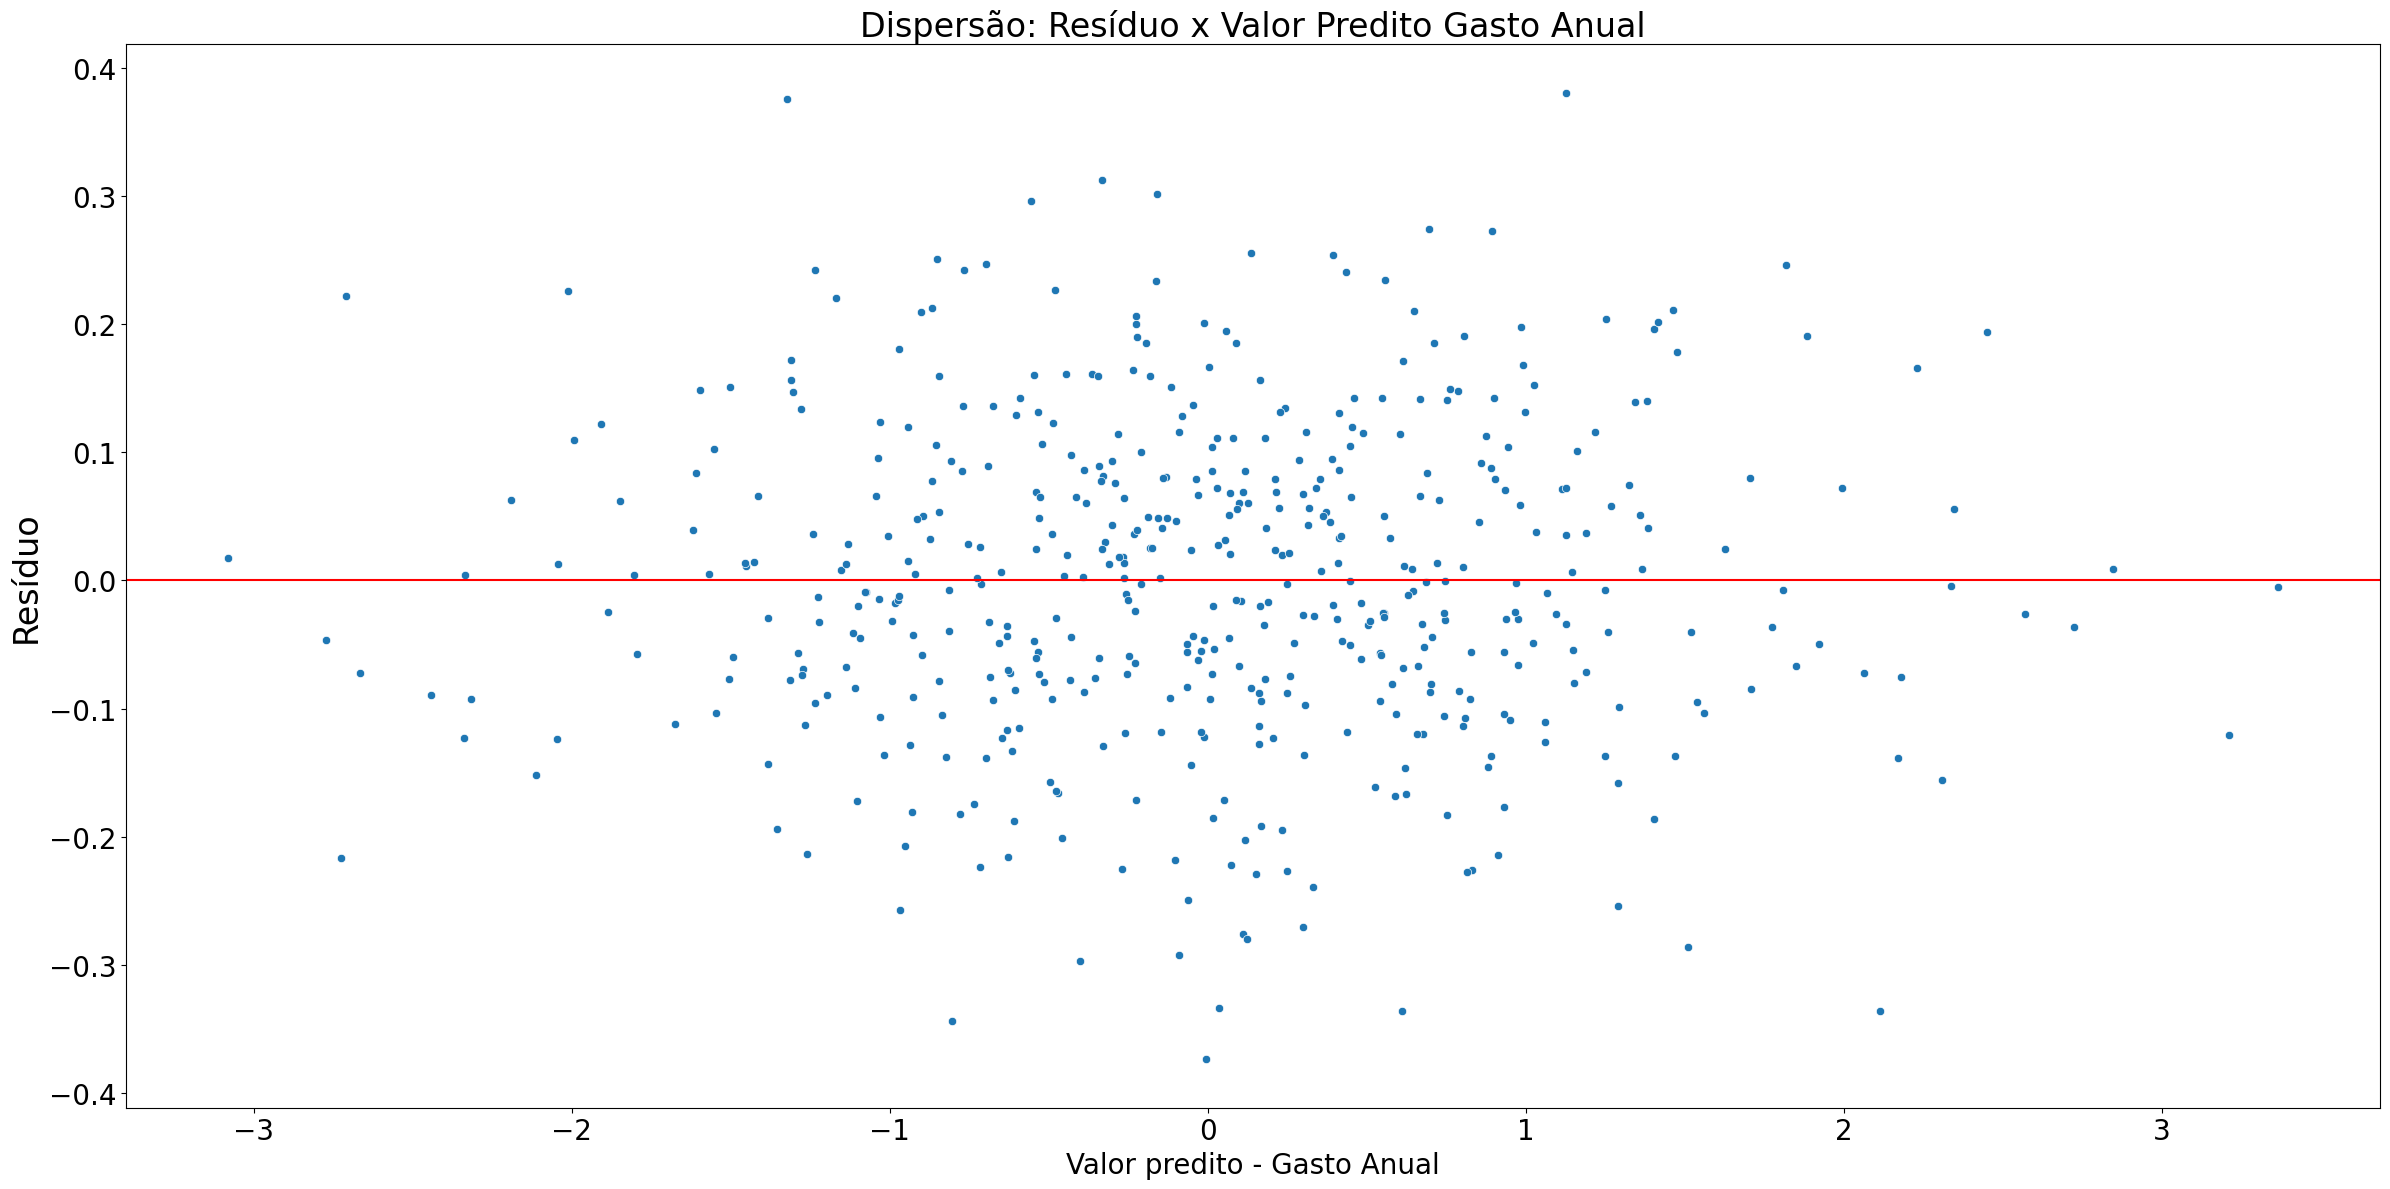

In [88]:
#Dispersao do residuo em funcao do valor predito do gasto anual do cliente
fig = plt.figure( figsize = (24,12) )
                
sns.scatterplot( x = 'valor_predito', y = 'residuo', data = df6 )
plt.axhline(y=0, color='r');

plt.title("Dispersão: Resíduo x Valor Predito Gasto Anual", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Valor predito - Gasto Anual',fontsize=20)
plt.ylabel('Resíduo',fontsize=24)
plt.tight_layout()
plt.show();

**Análise do gráfico de dispersão**

No gráfico , observa-se um padrão em forma de túnel o que indica comportamento de homocedasticidade.

### 9.2.3  Teste de Homocedasticidade - Breusch-Pagan

Testa se a variância do erro depende das variáveis explicativas e ocorre quando a variância dos erros não é constante.

Hipóteses:

H0: Homocedasticidade (variância constante dos erros) --> p-valor <0.05

H1: Heteroscedasticidade (variância não constante)

In [89]:
run_breuschpagan_test('com variáveis significativas', model, x) 


--- Teste de Breusch-Pagan para com variáveis significativas ---
Estatística de Teste: 5.7894
P-valor: 0.1223

F-Estatística: 1.9368
P-valor F: 0.1227

Conclusão: Não rejeitamos H0. Há evidências de homocedasticidade no modelo com variáveis significativas.


### 9.2.4 Histograma dos resíduos

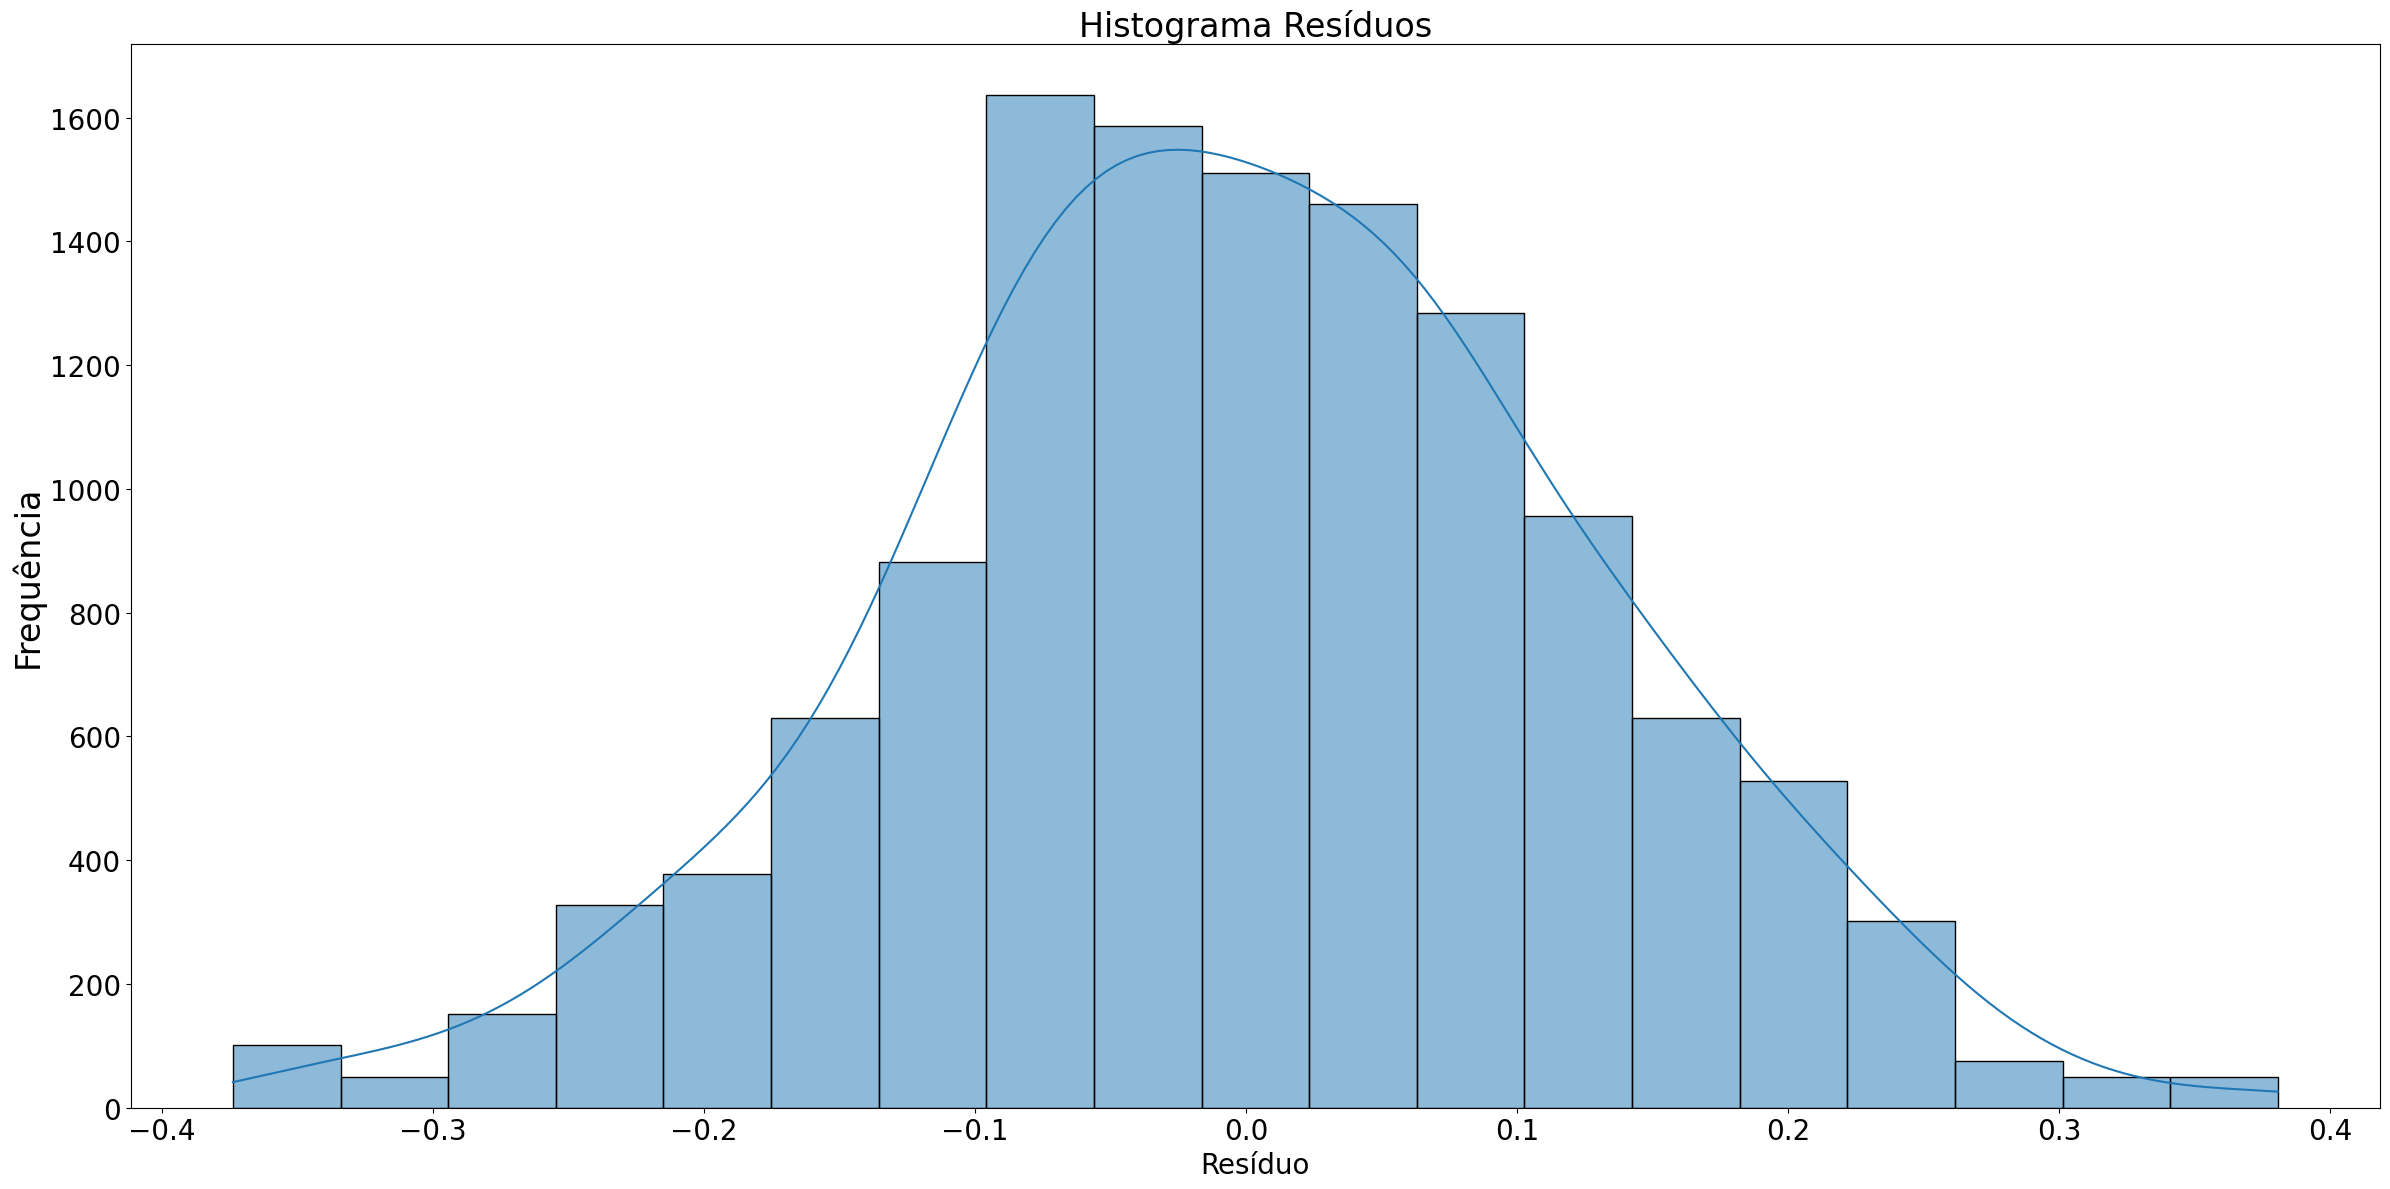

In [90]:
# histograma resíduos
fig = plt.figure( figsize = (24,12) )

sns.histplot( x = 'residuo', data = df6, stat = 'frequency', kde=True);

plt.title("Histograma Resíduos", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Resíduo',fontsize=20)
plt.ylabel('Frequência',fontsize=24)
plt.tight_layout()
plt.show();

**Após a análise do gráfico de histograma há evidencias que os resíduos do modelo seguem a distribuição normal.**

### 9.2.5 Teste de Normalidade dos Resíduos com Shapiro-Wilk

In [91]:
run_shapiro_wilk_test('com todas as variáveis', df6['residuo'])


--- Teste de Shapiro-Wilk para com todas as variáveis ---
Estatística de Teste: 0.9982
P-valor: 0.8791
Conclusão: Não rejeitamos H0. Os resíduos do modelo com todas as variáveis seguem uma distribuição normal.


**Conclusão sobre o teste de Normalidade de Shapiro-Wilk**

**Shapiro-Wilk: p-valor = 0.8791**

Hipóteses:

H0: Os dados seguem uma distribuição normal --> p-valor < 0.05

H1: Os dados não seguem uma distribuição normal

p-valor = 0.8791 > 0.05

Não Rejeitamos H0. Os resíduos do modelo Modelo seguem uma distribuição normal.

### 9.2.6 Análise de Normalidade


--- Análise Gráfica de Normalidade (Q-Q Plot) ---


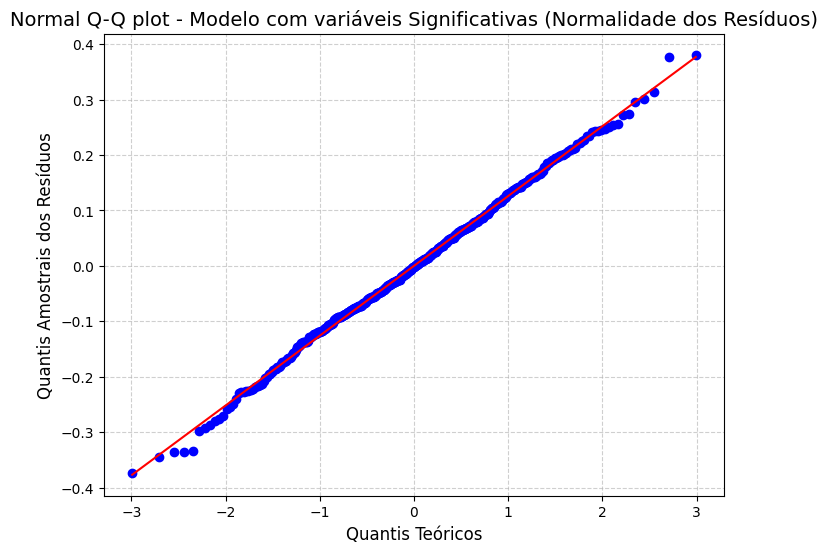

In [92]:
print("\n--- Análise Gráfica de Normalidade (Q-Q Plot) ---")
plot_qq('Modelo com variáveis Significativas',  df6['residuo'].values)

**Observa-se que os Q-Q plots do modelo indicam que não há pontos que se afastam da reta, indicando a mesma conclusão do teste de normalidade.**

### 9.2.7 Análise de Outliers

In [93]:
mean_resid = np.mean(df6['residuo'] )
std_resid  = np.std(df6['residuo'] )
df6['residuos_std'] = df6['residuo'].apply( lambda x: (x - mean_resid) / std_resid )

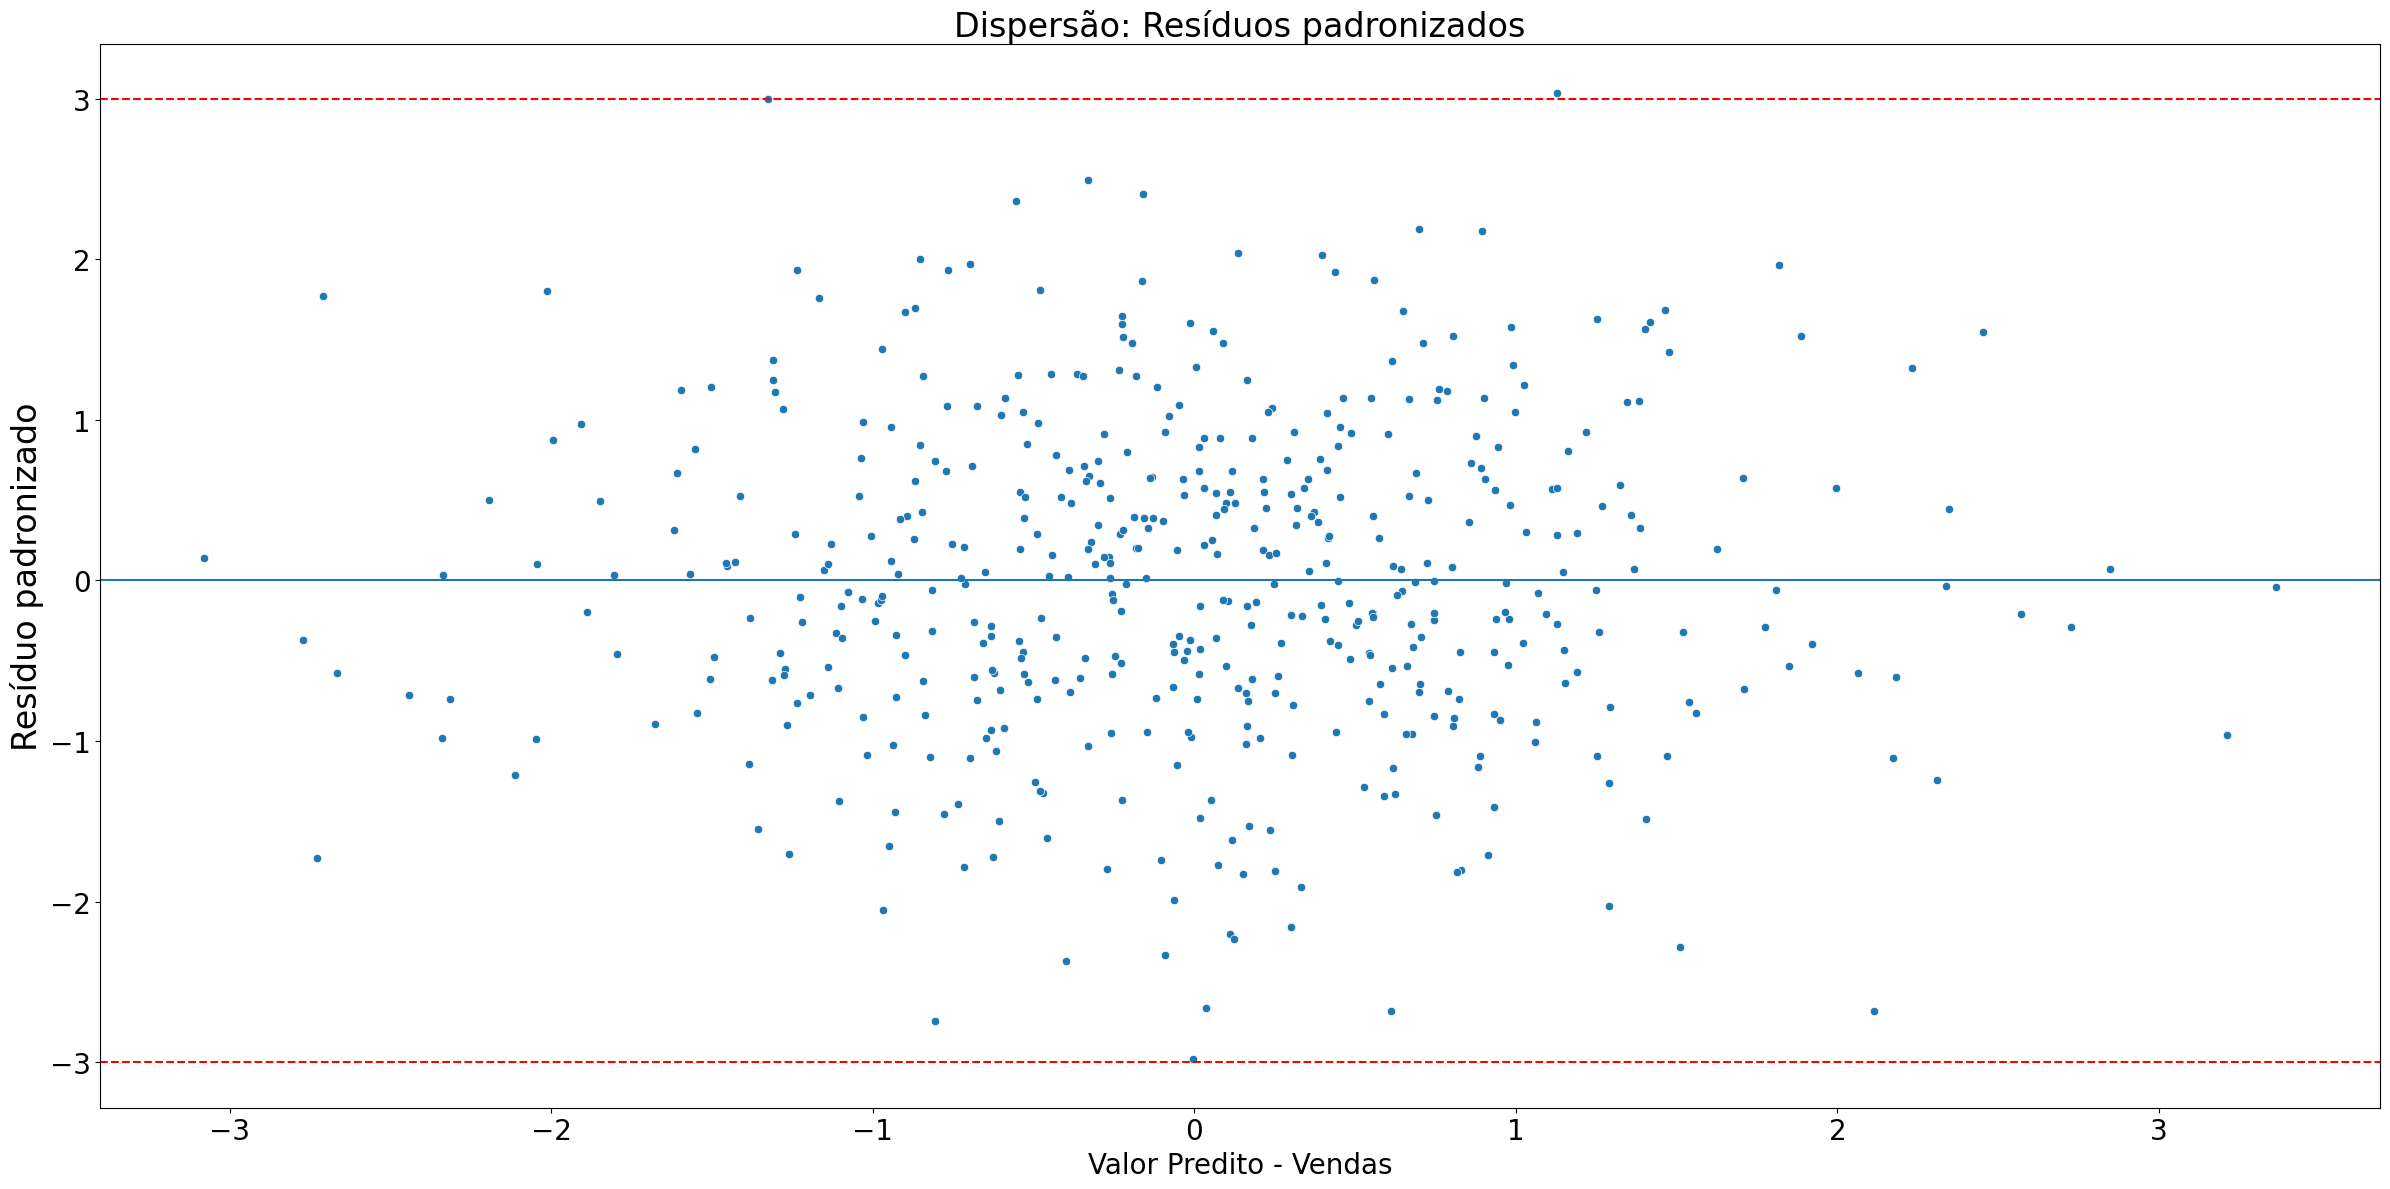

In [94]:
#Dispersao do residuo em funcao do valor predito do resultado vendas
fig = plt.figure( figsize = (24,12) )
sns.scatterplot( x = 'valor_predito', y = 'residuos_std', data = df6 )
plt.axhline(y=0);
plt.axhline(y=3,  linestyle='--', label='Limite Superior (+3)',color='r');
plt.axhline(y=-3, linestyle='--', label='Limite Inferior (-3)',color='r');

plt.title("Dispersão: Resíduos padronizados", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Valor Predito - Vendas',fontsize=20)
plt.ylabel('Resíduo padronizado',fontsize=24)
plt.tight_layout()
plt.show();


**No gráfico há indicativo de valores outliers que ultrapassam 3 desvios, porém estão bem próximos da região limite.**

### 9.2.8 Análise de Multicolinearidade

In [95]:
df7 = df6.copy()
df7.head()

,tempo_consultoria,tempo_app,tempo_website,tempo_membro,gasto_anual,valor_predito,residuo,residuos_std
0,1.456351,0.607280,2.493589,0.550107,1.118654,1.190342,-0.071689,-0.571861
1,-1.136502,-0.949464,0.206556,-0.870927,-1.351783,-1.502391,0.150608,1.201405
2,-0.052723,-0.727139,0.049681,0.572067,-0.148501,0.073529,-0.222030,-1.771142
3,1.263010,1.676390,-0.335978,-0.413996,1.041684,0.899662,0.142023,1.132919
4,0.279838,0.747770,0.471737,0.914422,1.263224,1.162421,0.100802,0.804104


In [96]:
# Selecionando as variáveis independentes
aux1 = df7[['tempo_consultoria', 'tempo_app', 'tempo_membro']].copy()

# lista das variáveis indenpendentes
features_2 = list(aux1.columns)

# variaveis auxiliares r2, tolerancia, FIV
r2  = []
tol = []
fiv=[]

# Calcule VIF para cada variável
for i in aux1.columns:
    
    y = aux1[[i]].copy()
    features_2.remove(i)
    x = aux1[features_2]
    features_2 = list(aux1.columns)

    # modelo
    x = sm.add_constant(x)
    model = sm.OLS(y,x).fit()
    predictions = model.predict(x)
                               
    # r2
    r2.append(model.rsquared)
             
    # calculo tolerância
    aux2 = 1- model.rsquared
    tol.append(aux2)
         
    # calculo FIV
    aux3=round(1/(1-model.rsquared),2)
    fiv.append(aux3)
    
tab_multicolinearidade = pd.DataFrame()
tab_multicolinearidade['var_indep'] = list(aux1.columns)
tab_multicolinearidade['r2']  = r2
tab_multicolinearidade['tol'] = tol  
tab_multicolinearidade['fiv'] = fiv  
tab_multicolinearidade

,var_indep,r2,tol,fiv
0,tempo_consultoria,0.004506,0.995494,1.0
1,tempo_app,0.001728,0.998272,1.0
2,tempo_membro,0.004580,0.995420,1.0


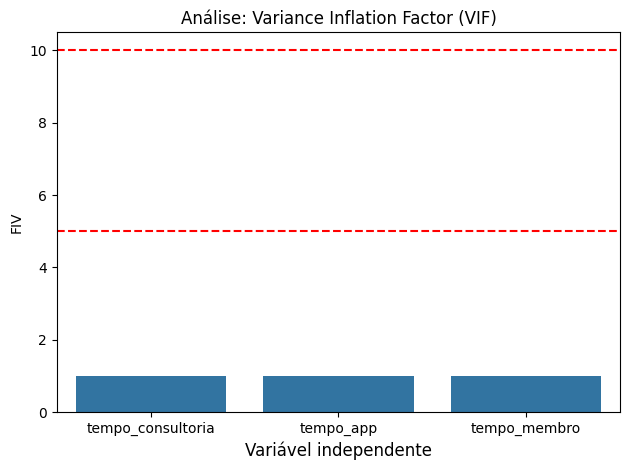

In [97]:
sns.barplot(data=tab_multicolinearidade,y='fiv',x='var_indep');

plt.axhline(y=10,  linestyle='--', label='Limite Superior (+10)',color='r');
plt.axhline(y=5, linestyle='--', label='Limite Inferior (+5)',color='r');

plt.title("Análise: Variance Inflation Factor (VIF)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Variável independente',fontsize=12)
plt.ylabel('FIV',fontsize=10)
plt.tight_layout()

plt.show();

### 9.2.9 Análise de autocorrelação dos resíduos

In [98]:
estatistica_dw = durbin_watson(df6['residuo'].values)
print('O valor calculado da estatística do teste de Durbin - Watson corresponde a: {:.4f} '.format(estatistica_dw))

O valor calculado da estatística do teste de Durbin - Watson corresponde a: 1.8885 


A estatística DW varia entre 0 e 4.

Interpretação:

1. DW ≈ 2	Sem autocorrelação (resíduos independentes)

2. DW < 2	Autocorrelação positiva (erros consecutivos tendem a ter o mesmo sinal)

3. DW > 2 Autocorrelação negativa (erros alternam sinal entre observações)

**Durbin-Watson = 1.8885 --> Baixa autocorrelação positiva, o que indica que os resíduos consecutivos tendem a ter o mesmo sinal**

### 9.2.10 Performance do modelo

In [99]:
r2_rf = r2_score(df6['gasto_anual'], df6['valor_predito'])
mse_rf = mean_squared_error(df6['gasto_anual'], df6['valor_predito'])
mae_rf = mean_absolute_error(df6['gasto_anual'], df6['valor_predito'])
rmse_rf = np.sqrt(mse_rf)

print("Regressão Linear lasso - Múltipla variáveis significativas:")
print(f"R²: {r2_rf}")
print(f"MSE: {mse_rf}")
print(f"MAE: {mae_rf}")
print(f"RMSE: {rmse_rf}")

Regressão Linear lasso - Múltipla variáveis significativas:
R²: 0.9842848920844948
MSE: 0.015715107915505205
MAE: 0.09957386522350374
RMSE: 0.125359913511079


### 9.2.11 Conclusão modelo com as variáveis significativas

**O modelo com as todas variáveis significativas, está corretamente especificado para representar a verdadeira relação com a variável resposta "gasto anual do cliente".**

1. Observa-se que o coeficiente de determinação do modelo foi de 0.984, o que corresponde que 98.4 % da variação na variável resposta são explicadas pelas variáveis independentes.
2. Após a análise de autocorrelação dos resíduos foi possível concluir que há evidencias de baixa autocorrelação positiva dos resíduos do modelo. Porém este resultado não invalida o modelo para realizar previsões.

## 9.3 Modelo - Variável mais correlacionada com a variavel resposta. (regressão simples)

### 9.3.1 Modelagem

In [100]:
y = df6[['gasto_anual']].copy()
x = df6[['tempo_membro']].copy()
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            gasto_anual   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     943.9
Date:                Sat, 13 Dec 2025   Prob (F-statistic):          4.81e-117
Time:                        17:21:24   Log-Likelihood:                -443.69
No. Observations:                 500   AIC:                             891.4
Df Residuals:                     498   BIC:                             899.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.318e-16      0.026  -5.01e-15   

In [101]:
# valores preditos e residuos e métricas
df6['valor_predito'] = model.fittedvalues
df6['residuo']= model.resid
mae = mean_absolute_error(df6['gasto_anual'], df6['valor_predito'])
mse = mean_squared_error(df6['gasto_anual'], df6['valor_predito'])
rmse = np.sqrt(mse)

In [102]:
# Criar DataFrame com Métricas
resultados_df_1 = pd.DataFrame({
    'modelo': ['modelo_1_var_correlacionada'],
    'Quantidade_de_variaveis_independentes': [x.shape[1] - 1],  # Excluindo a constante
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'AIC': [model.aic],
    'BIC': [model.bic],
    'R²':  [model.rsquared]
})

#### **Considerações sobre os coeficientes de determinação**

**Coeficiente de determinação - R quadrado**

O valor do R² = 0.655,  o que indica que o modelo é capaz de explicar a variabilidade do resultado das vendas em 65.5 % a partir das variáveis independentes utilizadas.

**Coeficiente de determinação ajustado - R² Ajustado**

O valor do Adj. R-squared = 0.654,  o que indica que o modelo é capaz de explicar a variabilidade do resultado das vendas em 65.4 % a partir das variáveis independentes utilizadas.


#### **Estatística F**

Teste dos coeficientes simultaneamente iguais a zero.

F-statistic: 943.9

Prob (F-statistic): 0.00

**Hipoteses:**

H0: Todos os coeficientes são simultaneamentes iguais a zero. --> p-valor < 0.05

H1: Pelo menos um dos coeficientes é diferente de zero.

p-valor = 0.00 < 0.05

Rejeita H0: Pelo menos um dos coeficientes é diferente de zero, o **Modelo é estaisticamente significativo.**

#### **Teste t-Student dos coeficientes**

**Estatística t-student - p-valor**

Verifica a significância estatística individual de cada coeficiente. 

Hipoteses:

H0: Coeficiente angular da variável é igual a zero. --> p-valor < 0.05

H1: Coeficiente angular é diferente de zero.

==================================================================================================

const  -- > t=  -5.01e-15--> p-valor= 1.000 > 0.05 --> **coeficiente não é estatisticamente significativo**

tempo_membro --> t= 30.723 --> p-valor= 0.000 < 0.05 --> **coeficiente é estatisticamente significativo**.


#### **Expectativas e pressupostos sobre os coeficientes**

**Expectativas de negócio** 

De acordo com as variáveis do problema tem-se as seguintes expectativas iniciais com relação aos gastos dos clientes na loja:

tempo_consultoria --> Se o tempo de consultoria para os clientes aumenta --> aumenta o gasto do cliente na loja.

tempo_app --> Se o tempo médio utilizando o APP aumenta --> aumenta o gasto do cliente na loja.

tempo_website --> Se o tempo médio utilizando o Website aumenta --> aumenta o gasto do cliente na loja.

tempo_membro --> Se o tempo como membro aumenta --> aumenta o gasto do cliente na loja.

===========================================================================================================

**Análise do sinal dos coeficientes do modelo.**

tempo_membro --> coef. = 0.8091 --> Se o tempo como membro aumenta --> aumenta o gasto do cliente na loja.


### 9.3.2 Análise dos resíduos

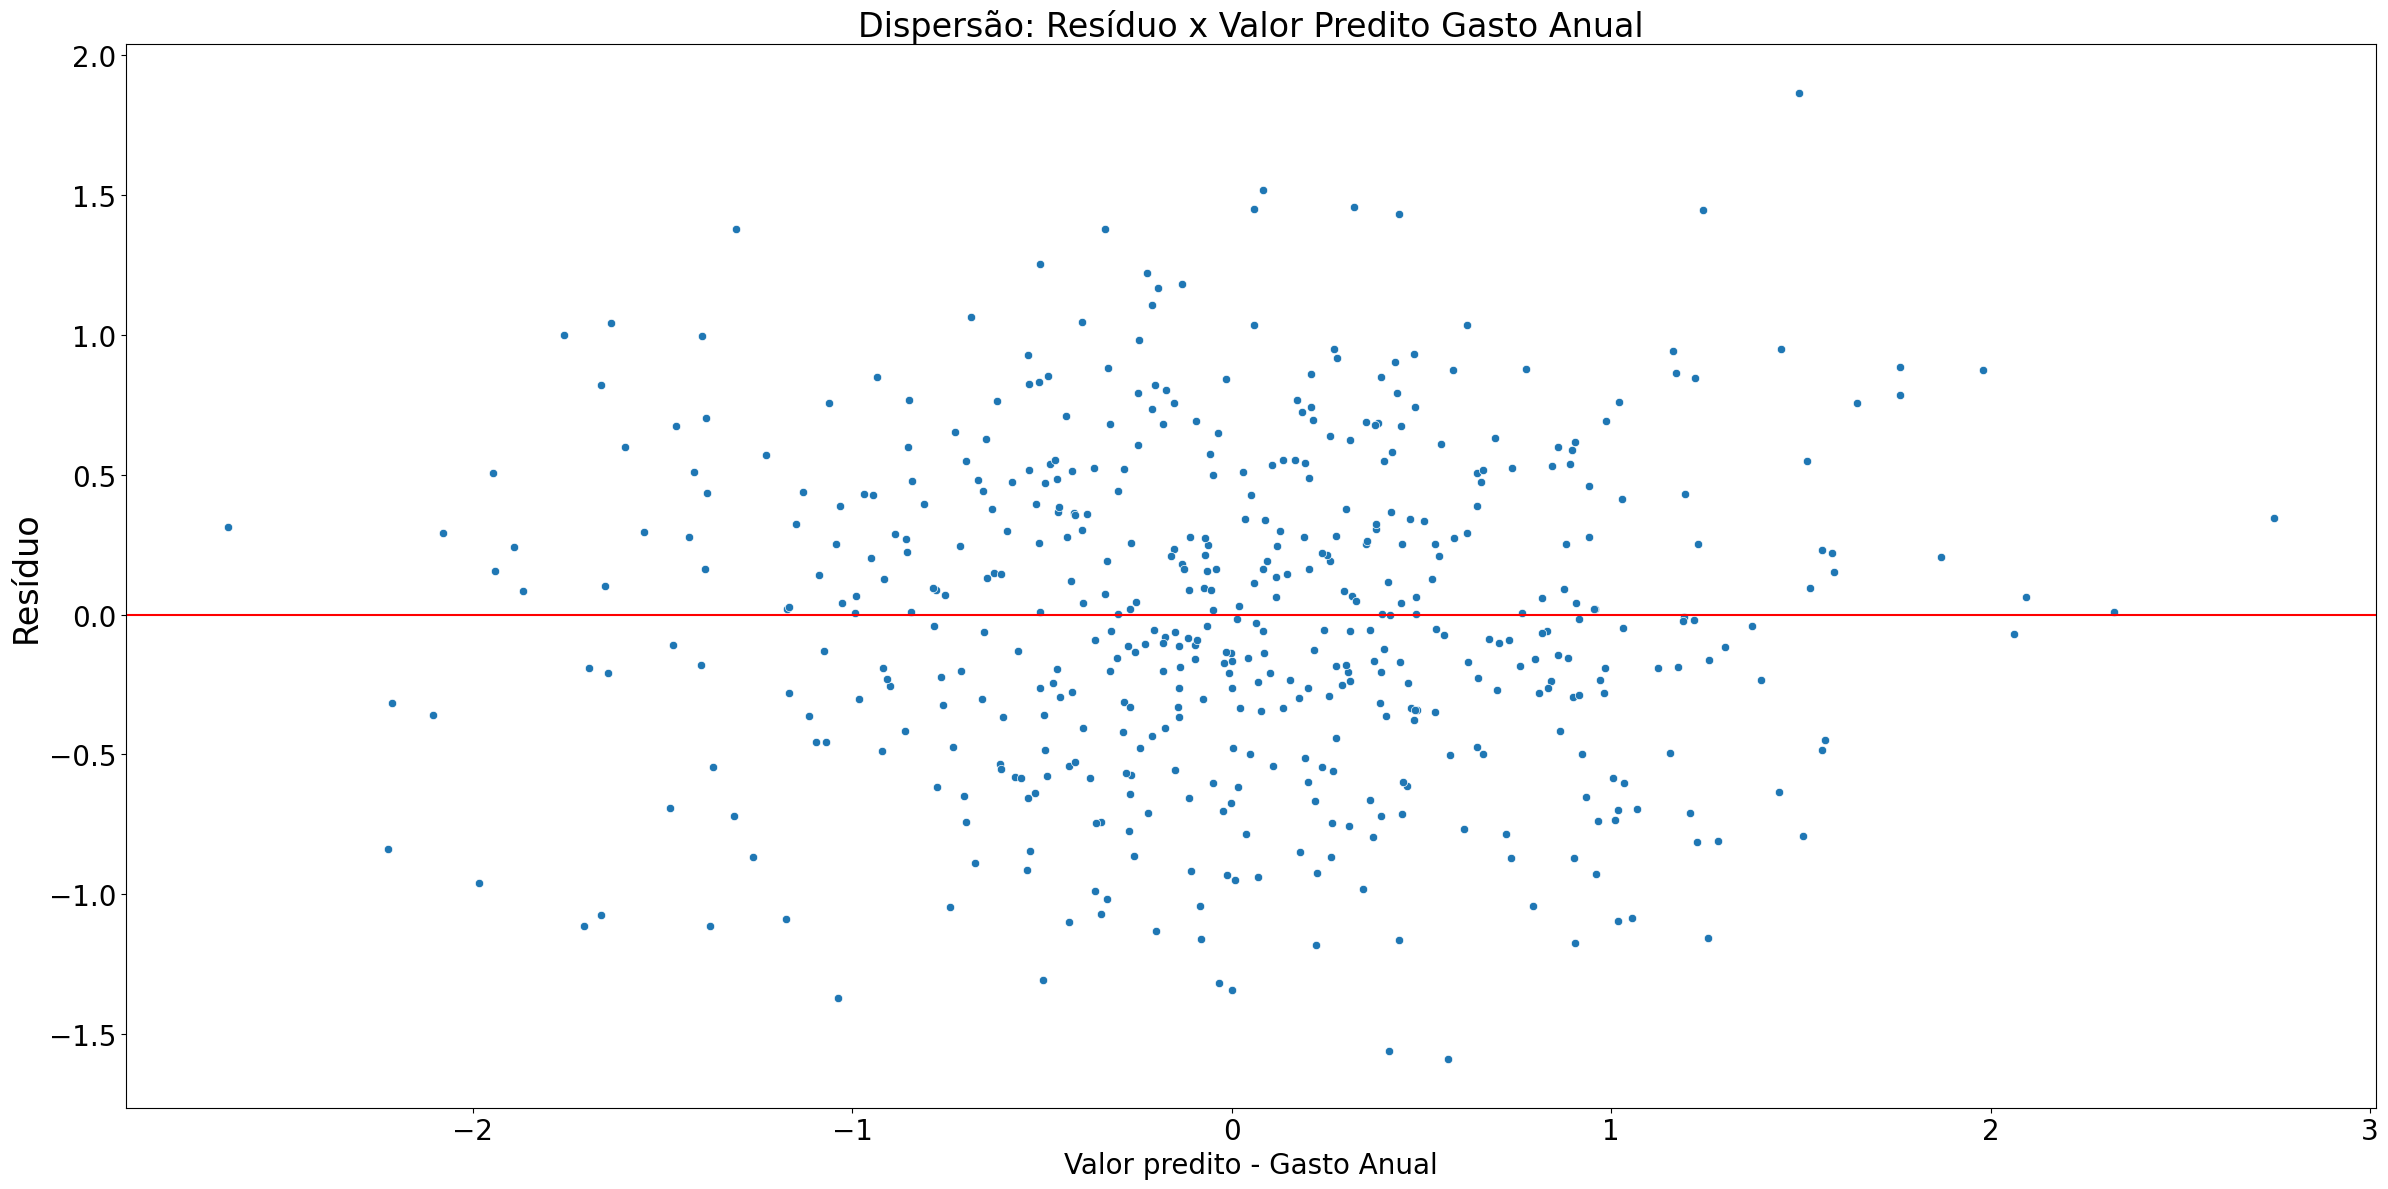

In [103]:
#Dispersao do residuo em funcao do valor predito do gasto anual do cliente
fig = plt.figure( figsize = (24,12) )
                
sns.scatterplot( x = 'valor_predito', y = 'residuo', data = df6 )
plt.axhline(y=0, color='r');

plt.title("Dispersão: Resíduo x Valor Predito Gasto Anual", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Valor predito - Gasto Anual',fontsize=20)
plt.ylabel('Resíduo',fontsize=24)
plt.tight_layout()
plt.show();

**Análise do gráfico de dispersão**

No gráfico , observa-se um padrão em forma de túnel o que indica comportamento de homocedasticidade. Porém comparativamente com o modelo com todas as variáveis significativas observa-se que a amplitude do erro aumentou.

### 9.3.3  Teste de Homocedasticidade - Breusch-Pagan

Testa se a variância do erro depende das variáveis explicativas e ocorre quando a variância dos erros não é constante.

Hipóteses:

H0: Homocedasticidade (variância constante dos erros) --> p-valor <0.05

H1: Heteroscedasticidade (variância não constante)

In [104]:
run_breuschpagan_test('com variável mais correlacionada', model, x) 


--- Teste de Breusch-Pagan para com variável mais correlacionada ---
Estatística de Teste: 0.0794
P-valor: 0.7782

F-Estatística: 0.0790
P-valor F: 0.7787

Conclusão: Não rejeitamos H0. Há evidências de homocedasticidade no modelo com variável mais correlacionada.


### 9.3.4 Histograma dos resíduos

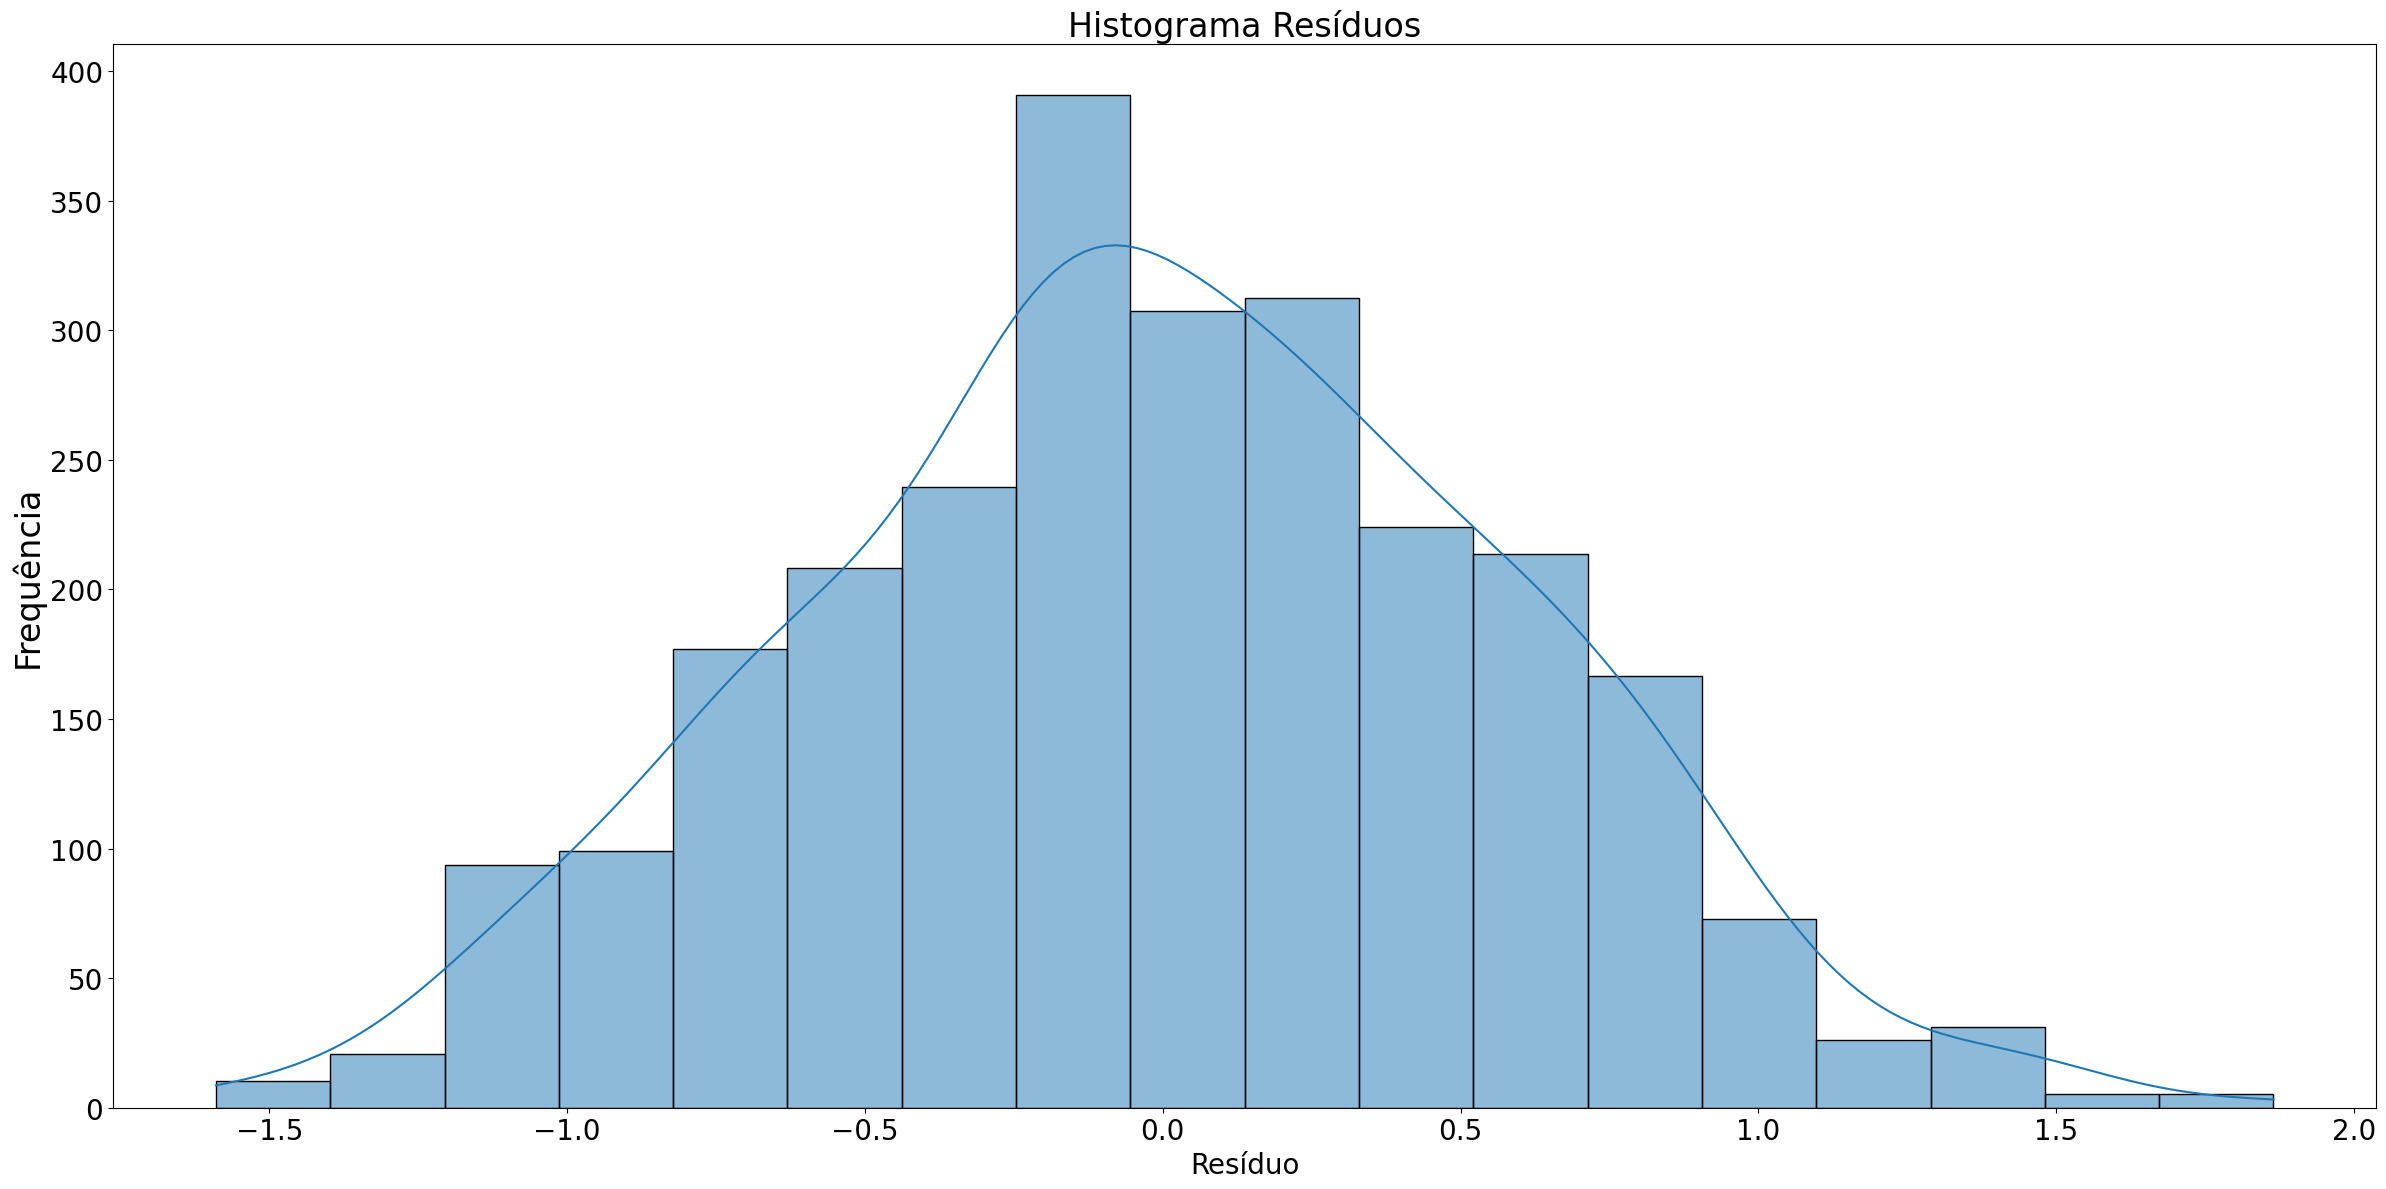

In [105]:
# histograma resíduos
fig = plt.figure( figsize = (24,12) )

sns.histplot( x = 'residuo', data = df6, stat = 'frequency', kde=True);

plt.title("Histograma Resíduos", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Resíduo',fontsize=20)
plt.ylabel('Frequência',fontsize=24)
plt.tight_layout()
plt.show();

**Após a análise do gráfico de histograma há evidencias que os resíduos do modelo seguem a distribuição normal.**

### 9.3.5 Teste de Normalidade dos Resíduos com Shapiro-Wilk

In [106]:
run_shapiro_wilk_test('com a variável mais correlacionada', df6['residuo'])


--- Teste de Shapiro-Wilk para com a variável mais correlacionada ---
Estatística de Teste: 0.9976
P-valor: 0.6837
Conclusão: Não rejeitamos H0. Os resíduos do modelo com a variável mais correlacionada seguem uma distribuição normal.


**Conclusão sobre o teste de Normalidade de Shapiro-Wilk**

**Shapiro-Wilk: p-valor = 0.6837**

Hipóteses:

H0: Os dados seguem uma distribuição normal --> p-valor < 0.05

H1: Os dados não seguem uma distribuição normal

p-valor = 0.6837 > 0.05

Não Rejeitamos H0. Os resíduos do modelo seguem uma distribuição normal.

### 9.3.6 Análise de Normalidade


--- Análise Gráfica de Normalidade (Q-Q Plot) ---


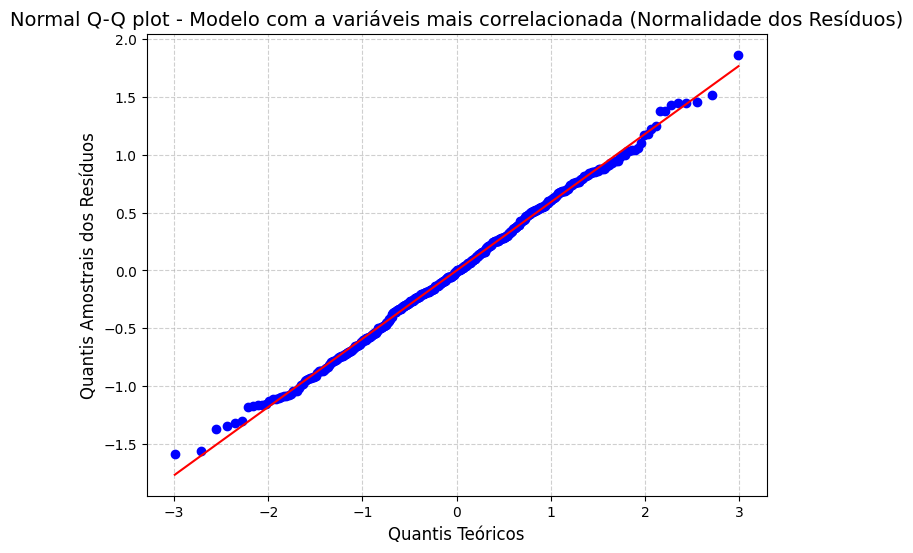

In [107]:
print("\n--- Análise Gráfica de Normalidade (Q-Q Plot) ---")
plot_qq('Modelo com a variáveis mais correlacionada',  df6['residuo'].values)

**Observa-se que os Q-Q plots do modelo indicam que não há pontos que se afastam da reta, indicando a mesma conclusão do teste de normalidade.**

### 9.3.7 Análise de Outliers

In [108]:
mean_resid = np.mean(df6['residuo'] )
std_resid  = np.std(df6['residuo'] )
df6['residuos_std'] = df6['residuo'].apply( lambda x: (x - mean_resid) / std_resid )

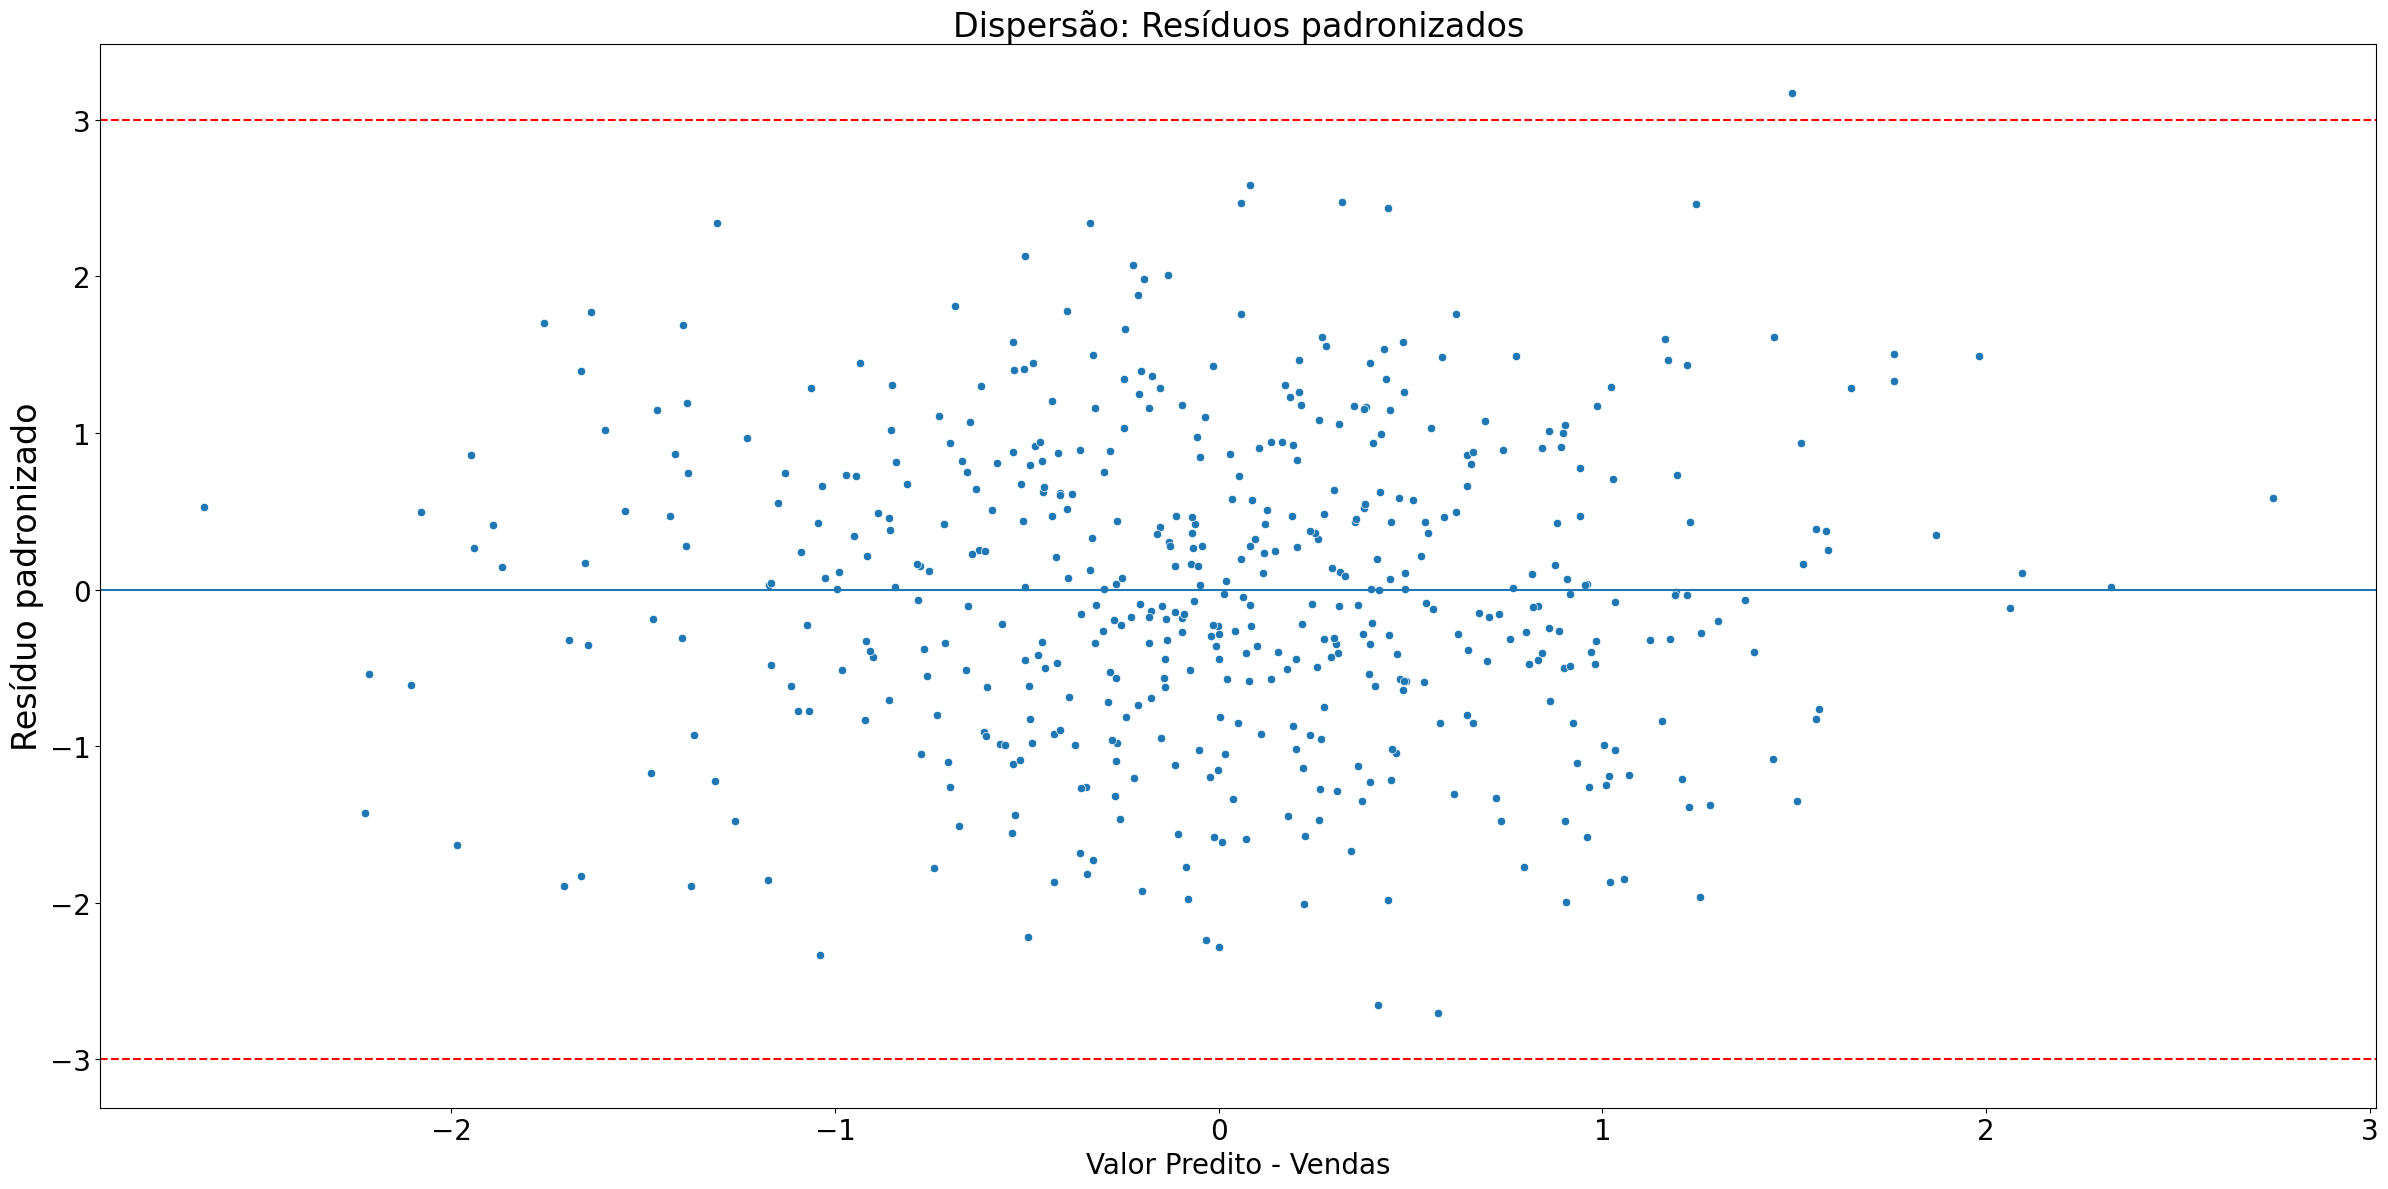

In [109]:
#Dispersao do residuo em funcao do valor predito do resultado vendas
fig = plt.figure( figsize = (24,12) )
sns.scatterplot( x = 'valor_predito', y = 'residuos_std', data = df6 )
plt.axhline(y=0);
plt.axhline(y=3,  linestyle='--', label='Limite Superior (+3)',color='r');
plt.axhline(y=-3, linestyle='--', label='Limite Inferior (-3)',color='r');

plt.title("Dispersão: Resíduos padronizados", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Valor Predito - Vendas',fontsize=20)
plt.ylabel('Resíduo padronizado',fontsize=24)
plt.tight_layout()
plt.show();


**No gráfico há indicativo de um valor outlier que ultrapassam 3 desvios, porém está bem próximos da região limite.**

### 9.3.8 Análise de autocorrelação dos resíduos

In [110]:
estatistica_dw = durbin_watson(df6['residuo'].values)
print('O valor calculado da estatística do teste de Durbin - Watson corresponde a: {:.4f} '.format(estatistica_dw))

O valor calculado da estatística do teste de Durbin - Watson corresponde a: 2.0654 


A estatística DW varia entre 0 e 4.

Interpretação:

1. DW ≈ 2	Sem autocorrelação (resíduos independentes)

2. DW < 2	Autocorrelação positiva (erros consecutivos tendem a ter o mesmo sinal)

3. DW > 2 Autocorrelação negativa (erros alternam sinal entre observações)

**Durbin-Watson = 2.0654 --> Sem autocorrelação serial**

### 9.3.9 Performance do modelo

In [111]:
r2_rf = r2_score(df6['gasto_anual'], df6['valor_predito'])
mse_rf = mean_squared_error(df6['gasto_anual'], df6['valor_predito'])
mae_rf = mean_absolute_error(df6['gasto_anual'], df6['valor_predito'])
rmse_rf = np.sqrt(mse_rf)

print("Regressão Linear lasso - Múltipla variáveis significativas:")
print(f"R²: {r2_rf}")
print(f"MSE: {mse_rf}")
print(f"MAE: {mae_rf}")
print(f"RMSE: {rmse_rf}")

Regressão Linear lasso - Múltipla variáveis significativas:
R²: 0.6546162204082381
MSE: 0.3453837795917618
MAE: 0.47189756994872045
RMSE: 0.5876936103036698


### 9.3.10 Conclusão modelo com a variável mais correlacionada

**O modelo com a variável mais correlacionada, está corretamente especificado para representar a verdadeira relação com a variável resposta "gasto anual do cliente".**

1. Observa-se que o coeficiente de determinação do modelo foi de 0.655, o que corresponde que 65.5 % da variação na variavel resposta é explicada pela variável tempo como membro da loja.
2. O modelo não apresentou autocorrelação serial dos residuos. 

## 9.4 Modelo - Duas variáveis mais correlacionadas

### 9.4.1 Modelagem

In [112]:
y = df6[['gasto_anual']].copy()
x = df6[['tempo_app', 'tempo_membro']].copy()
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            gasto_anual   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     1842.
Date:                Sat, 13 Dec 2025   Prob (F-statistic):          1.38e-230
Time:                        17:21:26   Log-Likelihood:                -177.00
No. Observations:                 500   AIC:                             360.0
Df Residuals:                     497   BIC:                             372.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.318e-16      0.015  -8.53e-15   

In [113]:
# valores preditos e residuos e métricas
df6['valor_predito'] = model.fittedvalues
df6['residuo']= model.resid
mae = mean_absolute_error(df6['gasto_anual'], df6['valor_predito'])
mse = mean_squared_error(df6['gasto_anual'], df6['valor_predito'])
rmse = np.sqrt(mse)

In [114]:
# Criar DataFrame com Métricas
resultados_df_2 = pd.DataFrame({
    'modelo': ['modelo_2_vars_correlacionadas'],
    'Quantidade_de_variaveis_independentes': [x.shape[1] - 1],  # Excluindo a constante
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse],
    'AIC': [model.aic],
    'BIC': [model.bic],
    'R²':  [model.rsquared]
})

#### **Considerações sobre os coeficientes de determinação**

**Coeficiente de determinação - R quadrado**

O valor do R² = 0.881,  o que indica que o modelo é capaz de explicar a variabilidade do resultado das vendas em 88.1 % a partir das variáveis independentes utilizadas.

**Coeficiente de determinação ajustado - R² Ajustado**

O valor do Adj. R-squared = 0.881,  o que indica que o modelo é capaz de explicar a variabilidade do resultado das vendas em  88.1 % a partir das variáveis independentes utilizadas.


#### **Estatística F**

Teste dos coeficientes simultaneamente iguais a zero.

F-statistic: 1842.

Prob (F-statistic): 0.00

**Hipoteses:**

H0: Todos os coeficientes são simultaneamentes iguais a zero. --> p-valor < 0.05

H1: Pelo menos um dos coeficientes é diferente de zero.

p-valor = 0.00 < 0.05

Rejeita H0: Pelo menos um dos coeficientes é diferente de zero, o **Modelo é estaisticamente significativo.**

#### **Teste t-Student dos coeficientes**

**Estatística t-student - p-valor**

Verifica a significância estatística individual de cada coeficiente. 

Hipoteses:

H0: Coeficiente angular da variável é igual a zero. --> p-valor < 0.05

H1: Coeficiente angular é diferente de zero.

==================================================================================================

const  -- > t=  -8.53e-15 --> p-valor= 1.000 > 0.05 --> **coeficiente não é estatisticamente significativo**

tempo_app --> t= 30.777 --> p-valor= 0.000 < 0.05--> **coeficiente é estatisticamente significativo**

tempo_membro --> t= 51.400 --> p-valor= 0.000 < 0.05 --> **coeficiente é estatisticamente significativo**.


#### **Expectativas e pressupostos sobre os coeficientes**

**Expectativas de negócio** 

De acordo com as variáveis do problema tem-se as seguintes expectativas iniciais com relação aos gastos dos clientes na loja:

tempo_consultoria --> Se o tempo de consultoria para os clientes aumenta --> aumenta o gasto do cliente na loja.

tempo_app --> Se o tempo médio utilizando o APP aumenta --> aumenta o gasto do cliente na loja.

tempo_website --> Se o tempo médio utilizando o Website aumenta --> aumenta o gasto do cliente na loja.

tempo_membro --> Se o tempo como membro aumenta --> aumenta o gasto do cliente na loja.

===========================================================================================================

**Análise do sinal dos coeficientes do modelo.**


tempo_app --> coef. = 0.4762 --> Se o tempo médio utilizando o APP aumenta --> aumenta o gasto do cliente na loja.

tempo_website -->  coef. = 0.0056 -->  Se o tempo médio utilizando o Website aumenta --> aumenta o gasto do cliente na loja.

tempo_membro --> coef. = 0.7952 --> Se o tempo como membro aumenta --> aumenta o gasto do cliente na loja.

**Análise de explicabilidade**

A variável que mais explica as variações da variavel resposta: Tempo como membro na loja. 

A Segunda variável que mais explica as variações da variavel resposta: Tempo gasto no aplicativo.


### 9.4.2 Análise dos resíduos

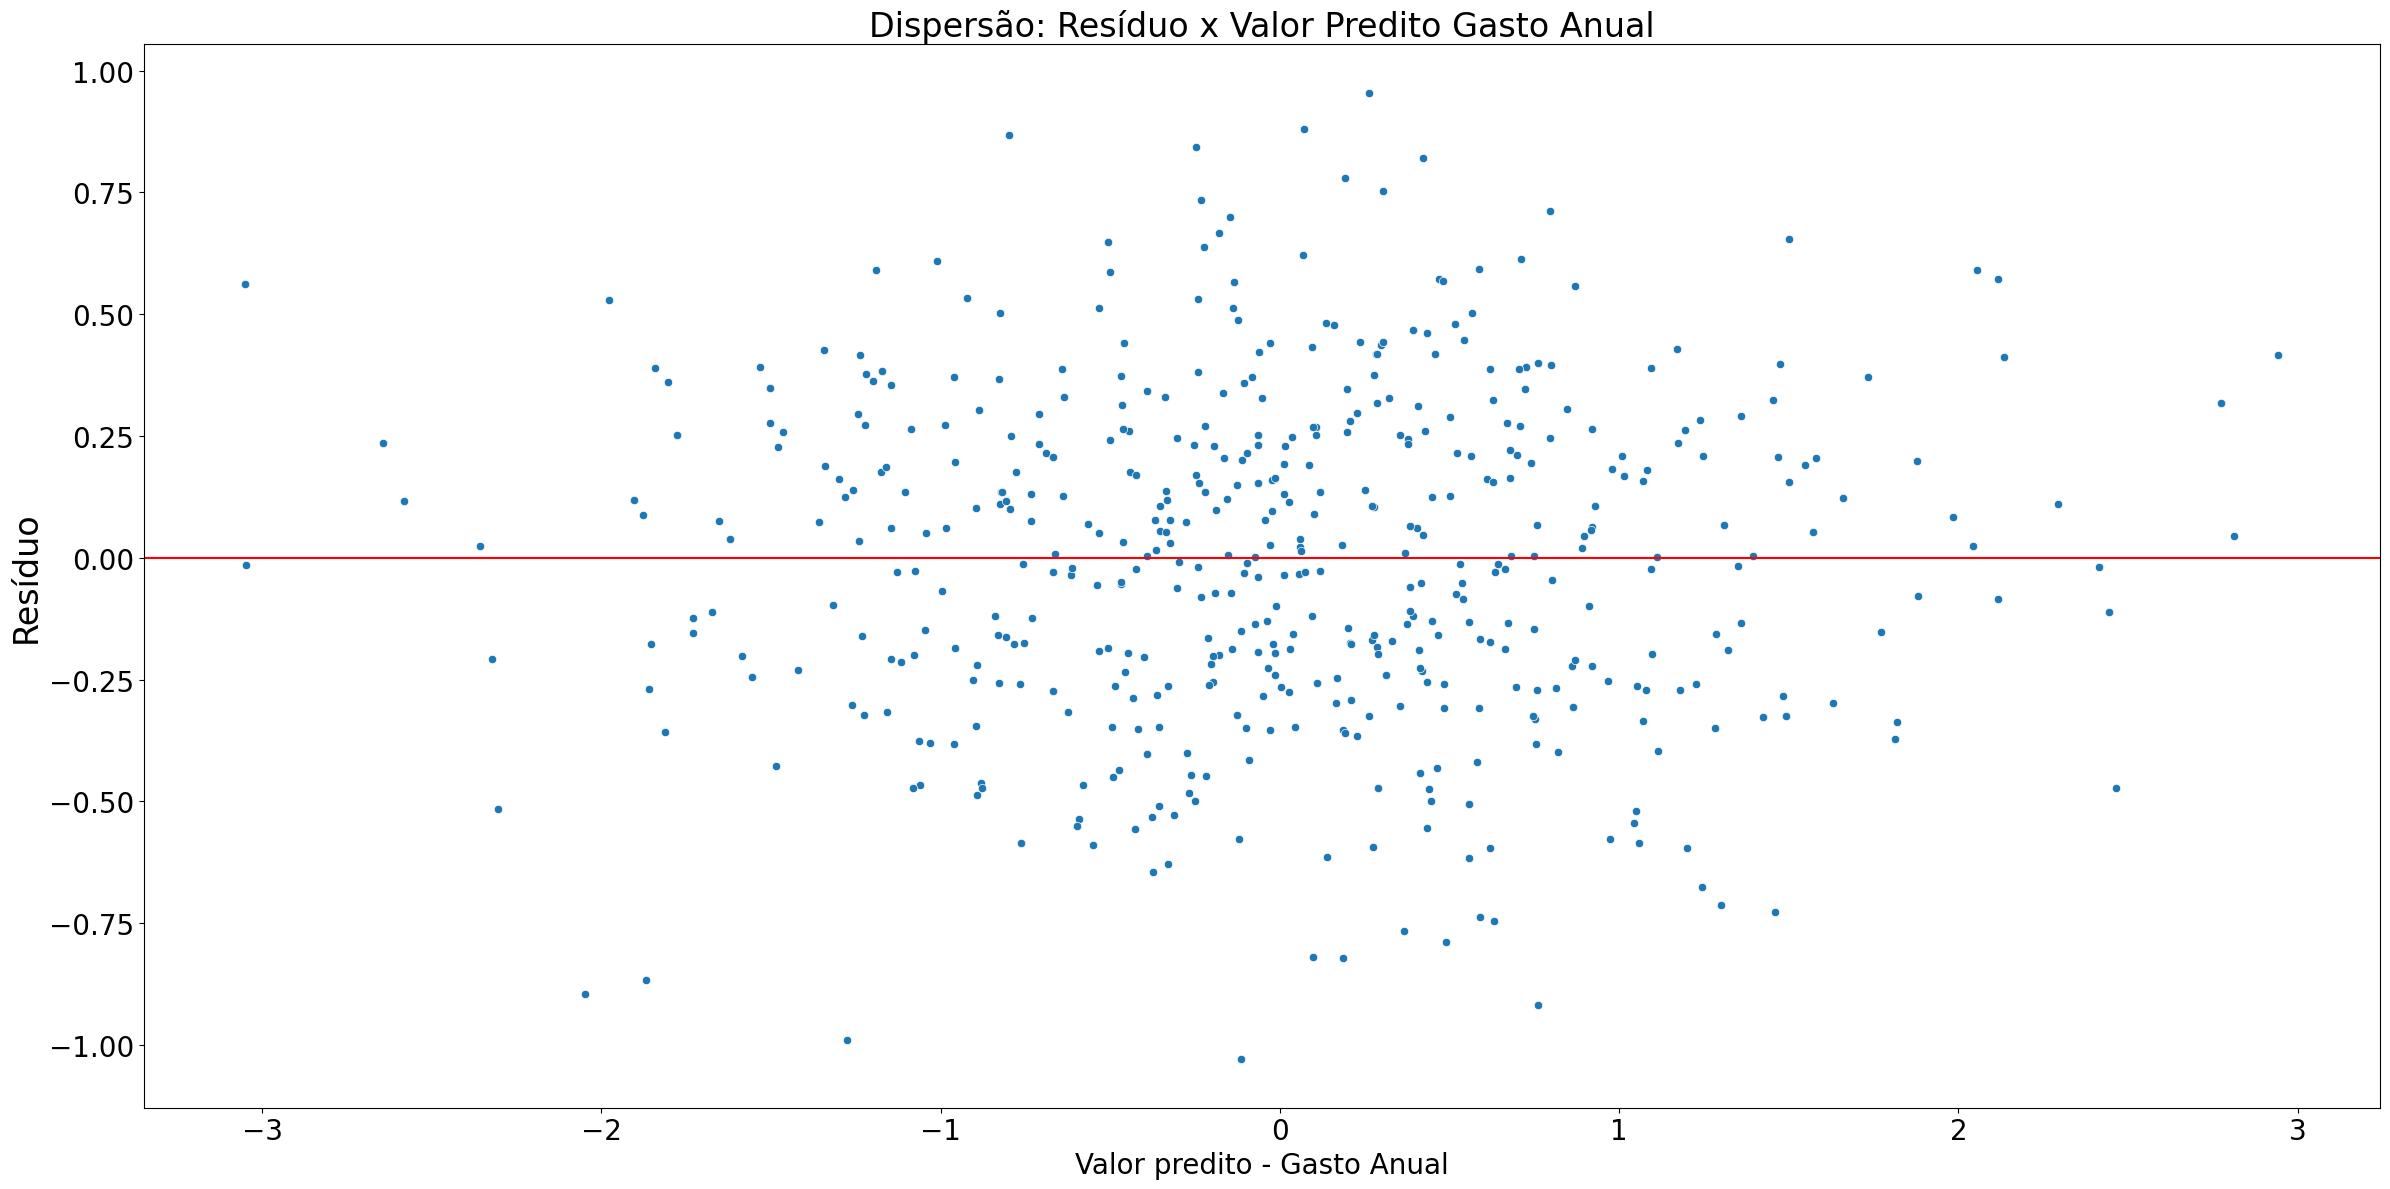

In [115]:
#Dispersao do residuo em funcao do valor predito do gasto anual do cliente
fig = plt.figure( figsize = (24,12) )
                
sns.scatterplot( x = 'valor_predito', y = 'residuo', data = df6 )
plt.axhline(y=0, color='r');

plt.title("Dispersão: Resíduo x Valor Predito Gasto Anual", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Valor predito - Gasto Anual',fontsize=20)
plt.ylabel('Resíduo',fontsize=24)
plt.tight_layout()
plt.show();

**Análise do gráfico de dispersão**

No gráfico , observa-se um padrão em forma de túnel o que indica comportamento de homocedasticidade.

### 9.4.3  Teste de Homocedasticidade - Breusch-Pagan

Testa se a variância do erro depende das variáveis explicativas e ocorre quando a variância dos erros não é constante.

Hipóteses:

H0: Homocedasticidade (variância constante dos erros) --> p-valor <0.05

H1: Heteroscedasticidade (variância não constante)

In [116]:
run_breuschpagan_test('com 2 variáveis mais correlacionadas', model, x) 


--- Teste de Breusch-Pagan para com 2 variáveis mais correlacionadas ---
Estatística de Teste: 0.0500
P-valor: 0.9753

F-Estatística: 0.0248
P-valor F: 0.9755

Conclusão: Não rejeitamos H0. Há evidências de homocedasticidade no modelo com 2 variáveis mais correlacionadas.


### 9.4.4 Histograma dos resíduos

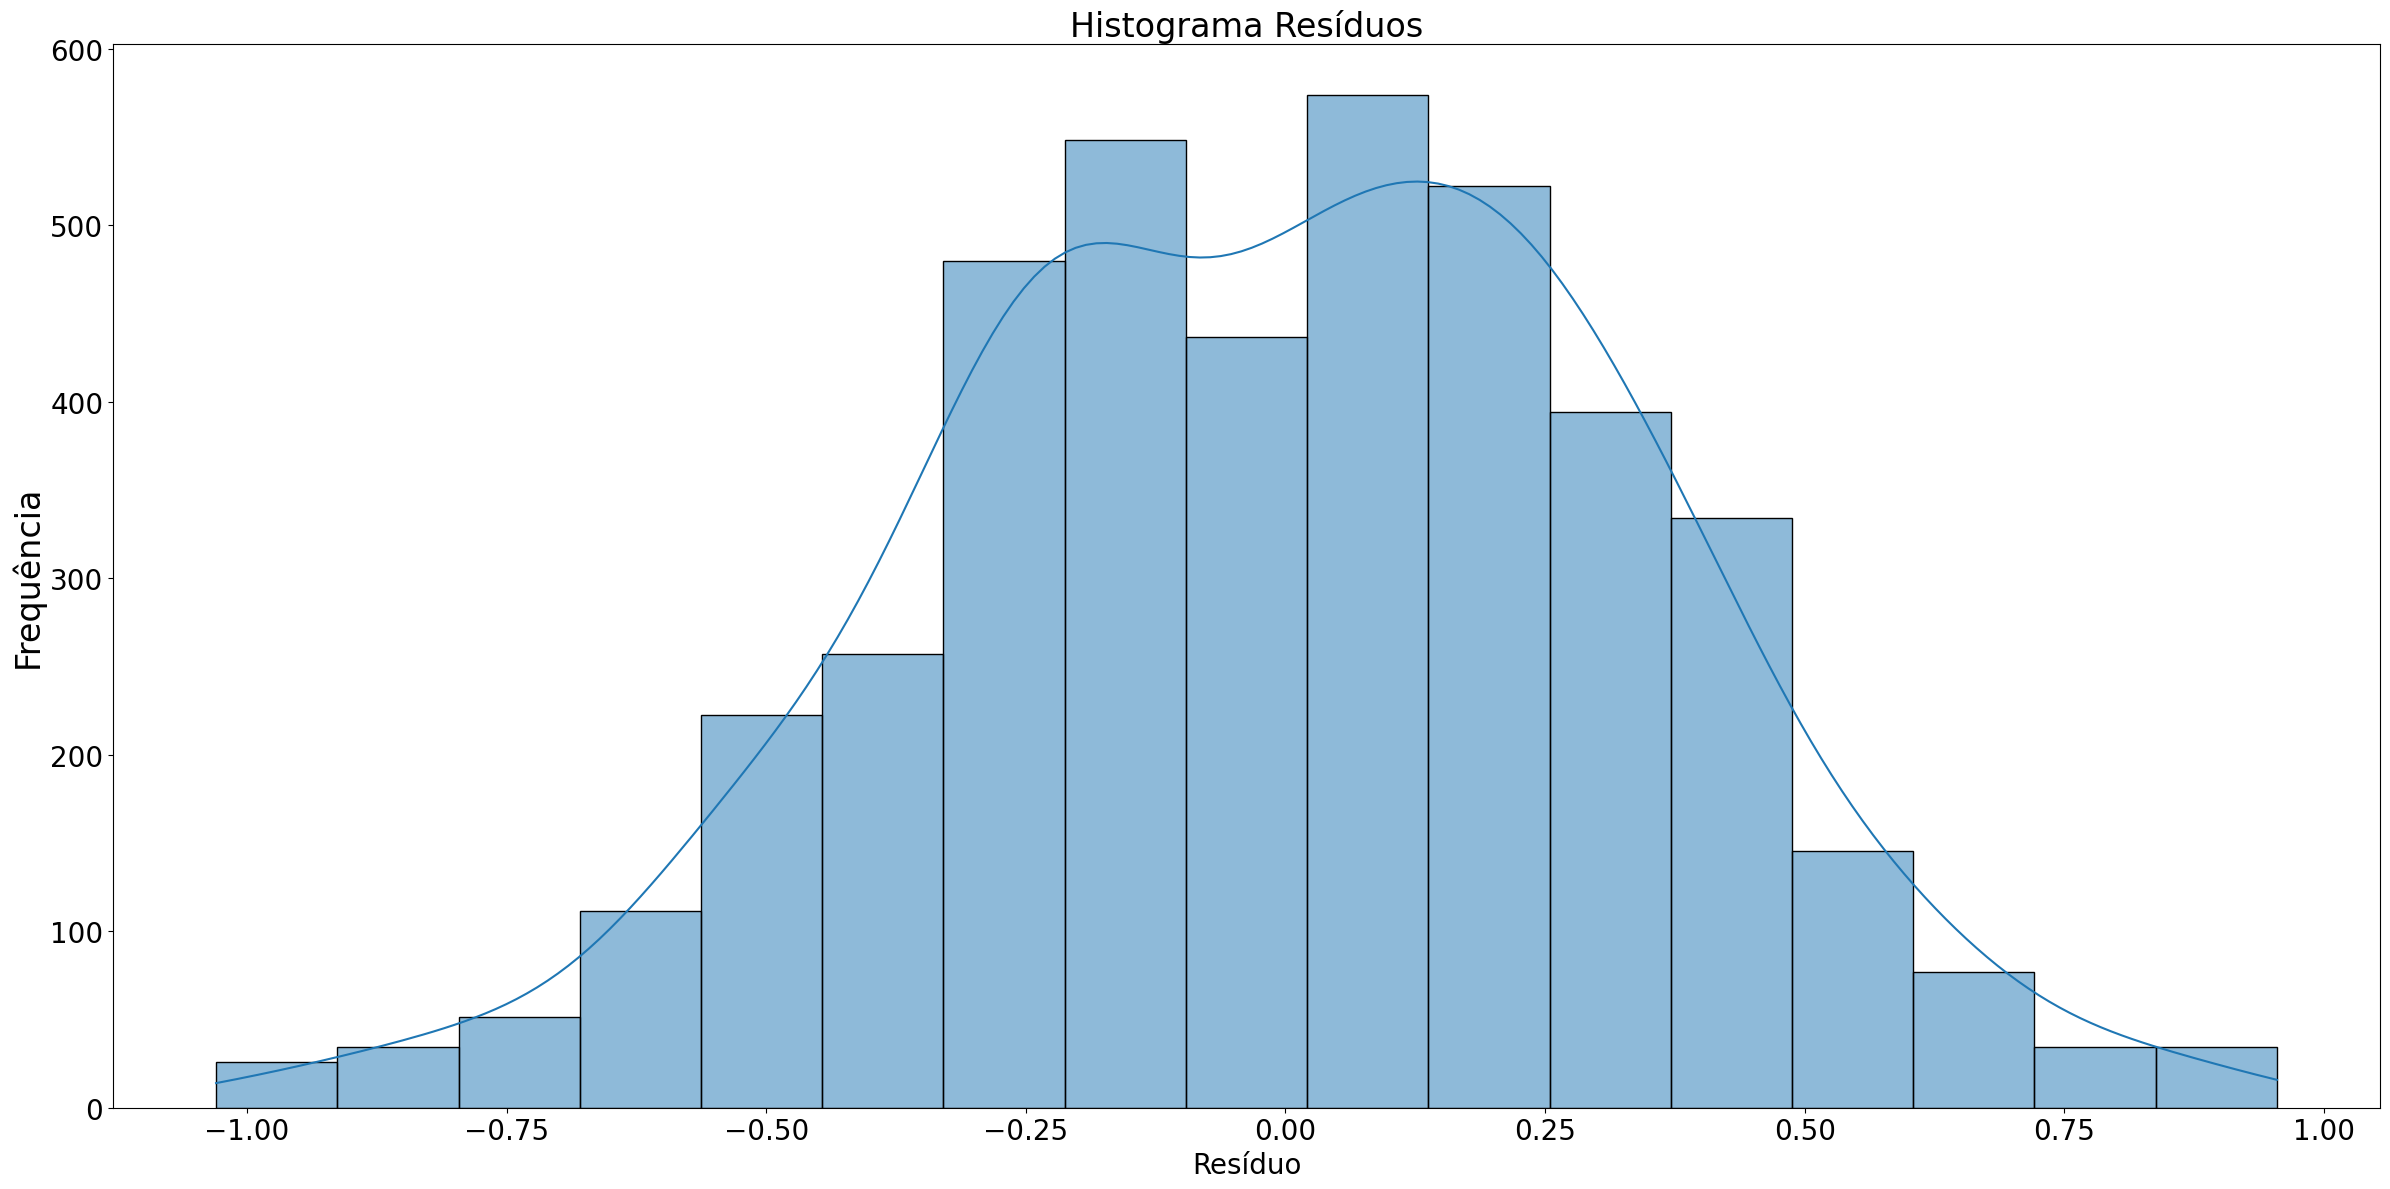

In [117]:
# histograma resíduos
fig = plt.figure( figsize = (24,12) )

sns.histplot( x = 'residuo', data = df6, stat = 'frequency', kde=True);

plt.title("Histograma Resíduos", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Resíduo',fontsize=20)
plt.ylabel('Frequência',fontsize=24)
plt.tight_layout()
plt.show();

**Após a análise do gráfico de histograma há evidencias que os resíduos do modelo seguem a distribuição normal.**

### 9.4.5 Teste de Normalidade dos Resíduos com Shapiro-Wilk

In [118]:
run_shapiro_wilk_test('com 2 variáveis mais correlacionadas', df6['residuo'])


--- Teste de Shapiro-Wilk para com 2 variáveis mais correlacionadas ---
Estatística de Teste: 0.9971
P-valor: 0.5269
Conclusão: Não rejeitamos H0. Os resíduos do modelo com 2 variáveis mais correlacionadas seguem uma distribuição normal.


**Conclusão sobre o teste de Normalidade de Shapiro-Wilk**

**Shapiro-Wilk: p-valor = 0.5269**

Hipóteses:

H0: Os dados seguem uma distribuição normal --> p-valor < 0.05

H1: Os dados não seguem uma distribuição normal

p-valor = 0.5269 > 0.05

Não Rejeitamos H0. Os resíduos do modelo Modelo seguem uma distribuição normal.

### 9.4.6 Análise de Normalidade


--- Análise Gráfica de Normalidade (Q-Q Plot) ---


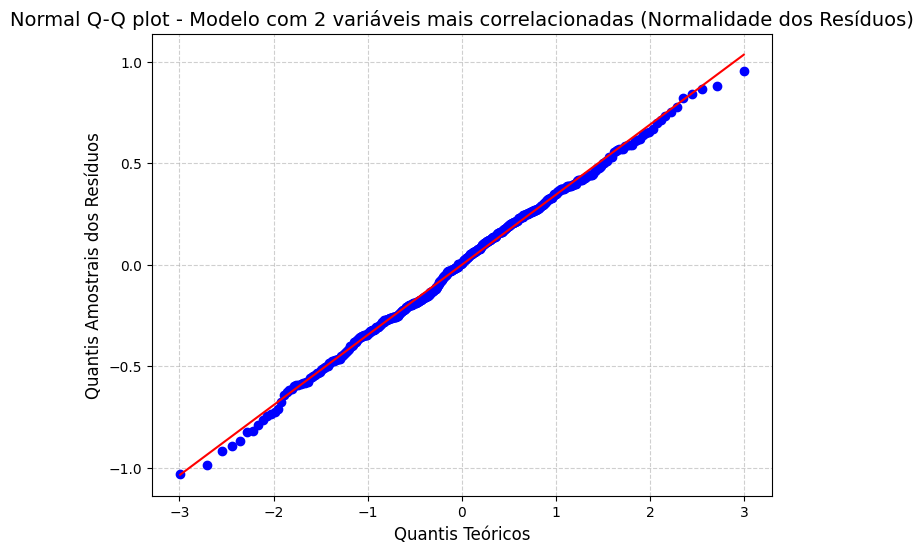

In [119]:
print("\n--- Análise Gráfica de Normalidade (Q-Q Plot) ---")
plot_qq('Modelo com 2 variáveis mais correlacionadas',  df6['residuo'].values)

**Observa-se que os Q-Q plots do modelo indicam que não há pontos que se afastam da reta, indicando a mesma conclusão do teste de normalidade.**

### 9.4.7 Análise de Outliers

In [120]:
mean_resid = np.mean(df6['residuo'] )
std_resid  = np.std(df6['residuo'] )
df6['residuos_std'] = df6['residuo'].apply( lambda x: (x - mean_resid) / std_resid )

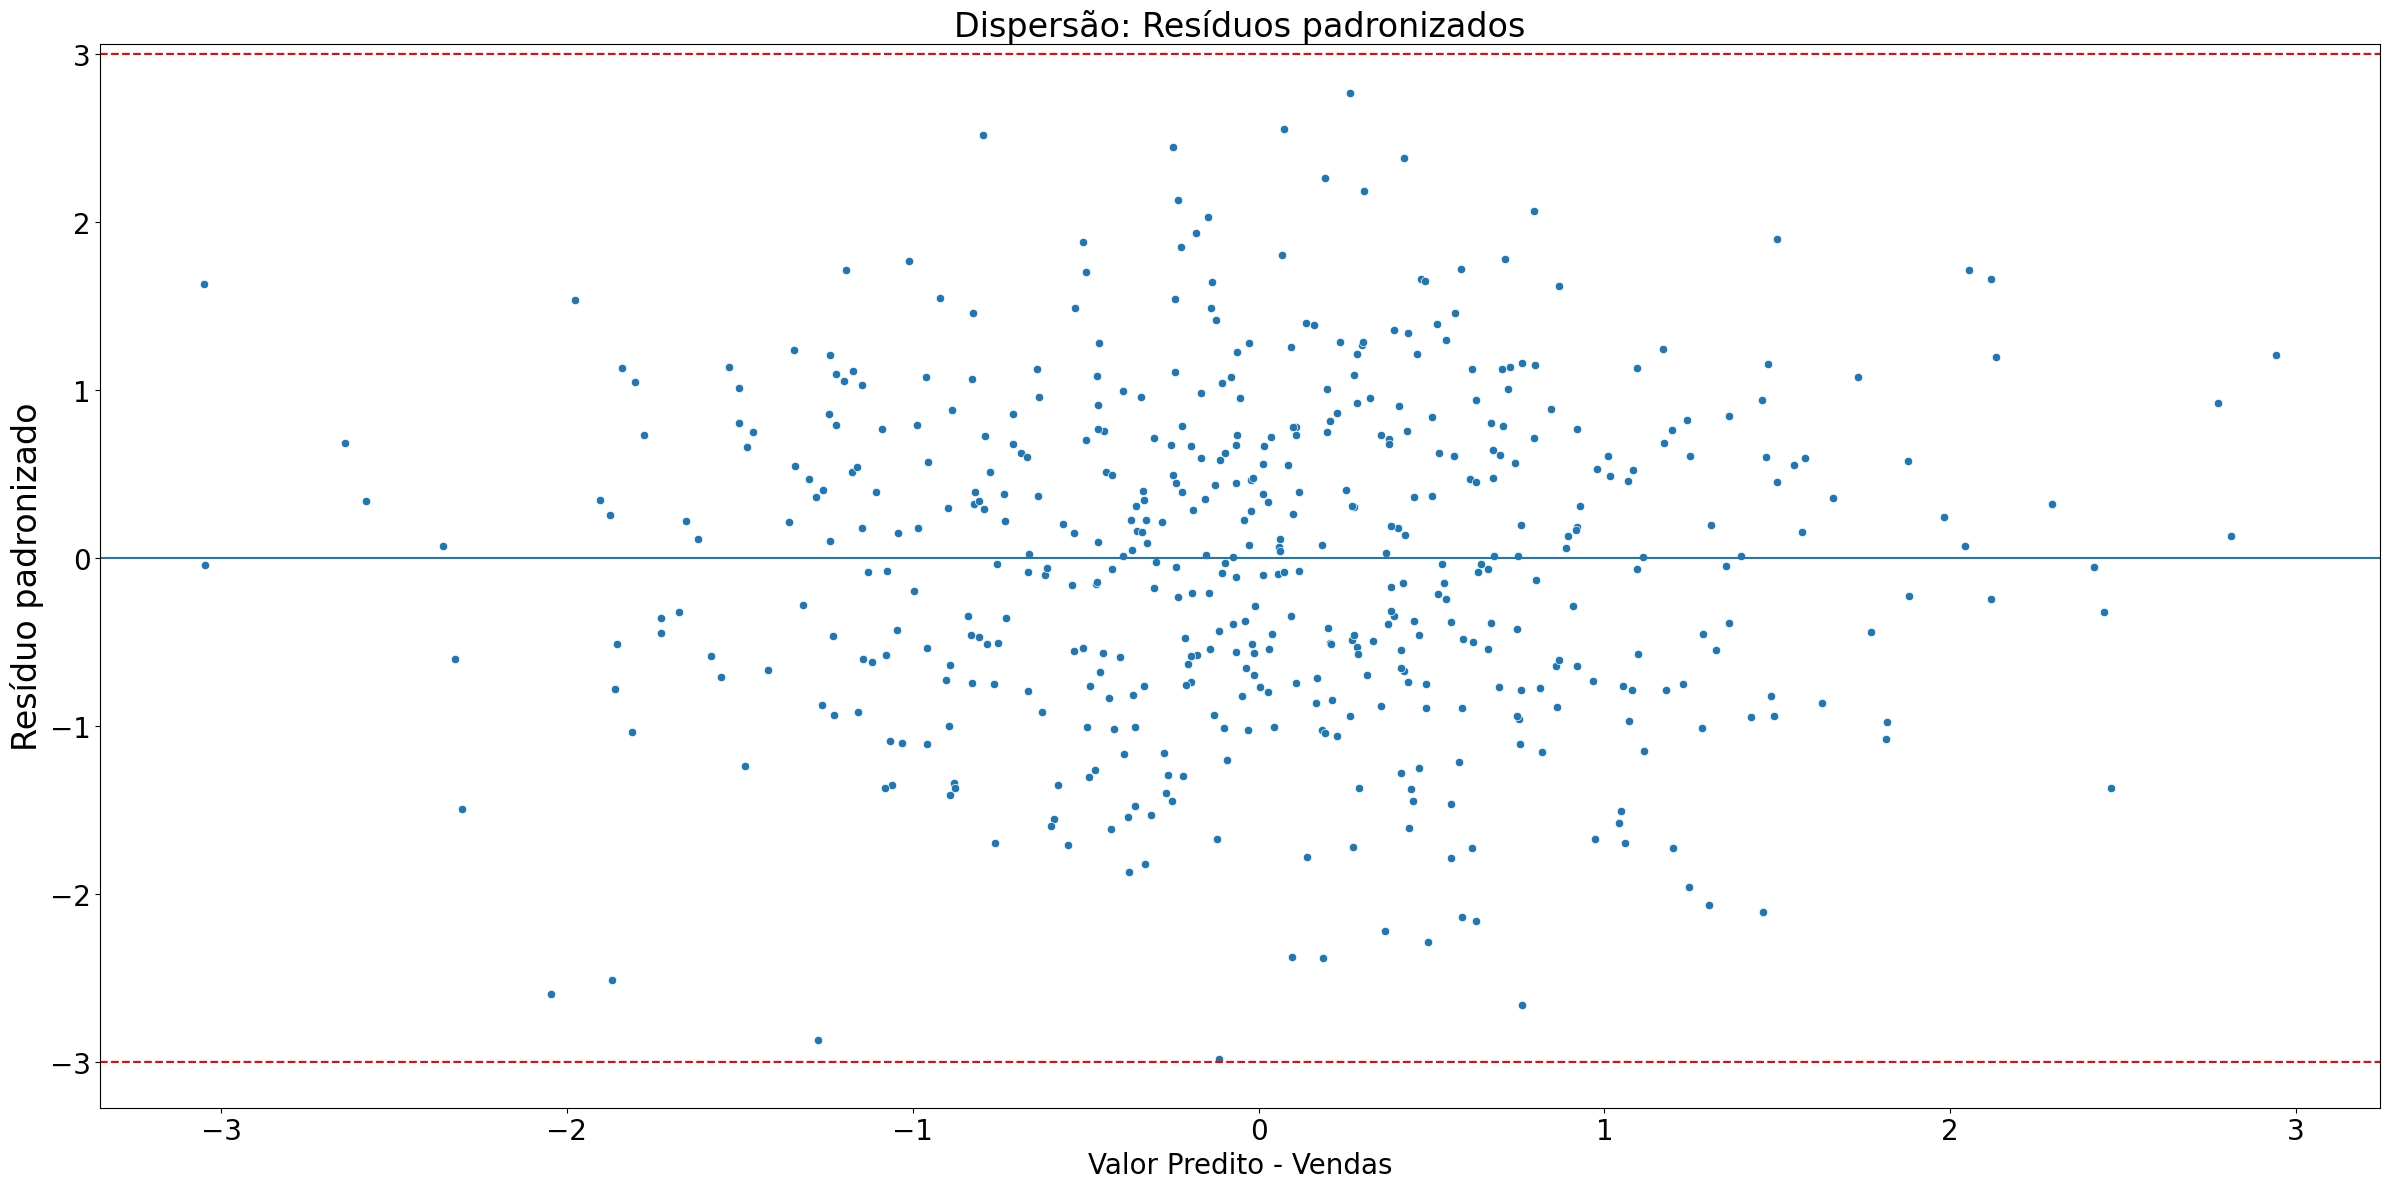

In [121]:
#Dispersao do residuo em funcao do valor predito do resultado vendas
fig = plt.figure( figsize = (24,12) )
sns.scatterplot( x = 'valor_predito', y = 'residuos_std', data = df6 )
plt.axhline(y=0);
plt.axhline(y=3,  linestyle='--', label='Limite Superior (+3)',color='r');
plt.axhline(y=-3, linestyle='--', label='Limite Inferior (-3)',color='r');

plt.title("Dispersão: Resíduos padronizados", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Valor Predito - Vendas',fontsize=20)
plt.ylabel('Resíduo padronizado',fontsize=24)
plt.tight_layout()
plt.show();


**No gráfico não há indicativo de valores outliers que ultrapassam 3 desvios.**

### 9.4.8 Análise de Multicolinearidade

In [122]:
df7 = df6.copy()
df7.head()

,tempo_consultoria,tempo_app,tempo_website,tempo_membro,gasto_anual,valor_predito,residuo,residuos_std
0,1.456351,0.607280,2.493589,0.550107,1.118654,0.726607,0.392047,1.137183
1,-1.136502,-0.949464,0.206556,-0.870927,-1.351783,-1.144658,-0.207125,-0.600793
2,-0.052723,-0.727139,0.049681,0.572067,-0.148501,0.108682,-0.257183,-0.745993
3,1.263010,1.676390,-0.335978,-0.413996,1.041684,0.469006,0.572678,1.661128
4,0.279838,0.747770,0.471737,0.914422,1.263224,1.083208,0.180016,0.522159


In [123]:
# Selecionando as variáveis independentes
aux1 = df7[['tempo_app', 'tempo_membro']].copy()

# lista das variáveis indenpendentes
features_2 = list(aux1.columns)

# variaveis auxiliares r2, tolerancia, FIV
r2  = []
tol = []
fiv=[]

# Calcule VIF para cada variável
for i in aux1.columns:
    
    y = aux1[[i]].copy()
    features_2.remove(i)
    x = aux1[features_2]
    features_2 = list(aux1.columns)

    # modelo
    x = sm.add_constant(x)
    model = sm.OLS(y,x).fit()
    predictions = model.predict(x)
                               
    # r2
    r2.append(model.rsquared)
             
    # calculo tolerância
    aux2 = 1- model.rsquared
    tol.append(aux2)
         
    # calculo FIV
    aux3=round(1/(1-model.rsquared),2)
    fiv.append(aux3)
    
tab_multicolinearidade = pd.DataFrame()
tab_multicolinearidade['var_indep'] = list(aux1.columns)
tab_multicolinearidade['r2']  = r2
tab_multicolinearidade['tol'] = tol  
tab_multicolinearidade['fiv'] = fiv  
tab_multicolinearidade

,var_indep,r2,tol,fiv
0,tempo_app,0.000849,0.999151,1.0
1,tempo_membro,0.000849,0.999151,1.0


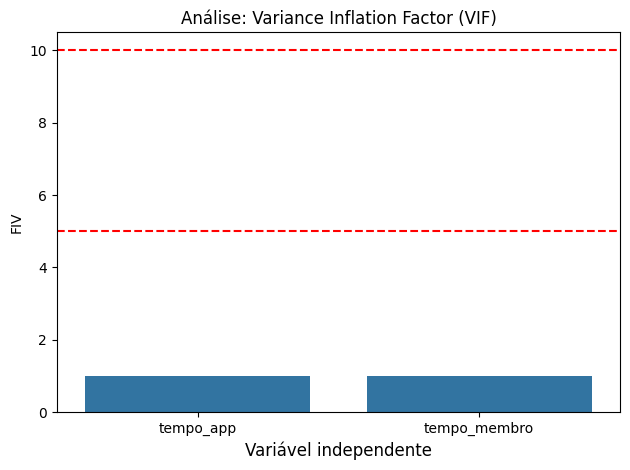

In [124]:
sns.barplot(data=tab_multicolinearidade,y='fiv',x='var_indep');

plt.axhline(y=10,  linestyle='--', label='Limite Superior (+10)',color='r');
plt.axhline(y=5, linestyle='--', label='Limite Inferior (+5)',color='r');

plt.title("Análise: Variance Inflation Factor (VIF)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Variável independente',fontsize=12)
plt.ylabel('FIV',fontsize=10)
plt.tight_layout()

plt.show();

### 9.4.9 Análise de autocorrelação dos resíduos

In [125]:
estatistica_dw = durbin_watson(df6['residuo'].values)
print('O valor calculado da estatística do teste de Durbin - Watson corresponde a: {:.4f} '.format(estatistica_dw))

O valor calculado da estatística do teste de Durbin - Watson corresponde a: 2.0747 


A estatística DW varia entre 0 e 4.

Interpretação:

1. DW ≈ 2	Sem autocorrelação (resíduos independentes)

2. DW < 2	Autocorrelação positiva (erros consecutivos tendem a ter o mesmo sinal)

3. DW > 2 Autocorrelação negativa (erros alternam sinal entre observações)

**Durbin-Watson = 2.0747 --> Sem autocorrelação serial e resíduos são independentes.**

### 9.4.10 Performance do modelo

In [126]:
r2_rf = r2_score(df6['gasto_anual'], df6['valor_predito'])
mse_rf = mean_squared_error(df6['gasto_anual'], df6['valor_predito'])
mae_rf = mean_absolute_error(df6['gasto_anual'], df6['valor_predito'])
rmse_rf = np.sqrt(mse_rf)

print("Regressão Linear lasso - Múltipla variáveis significativas:")
print(f"R²: {r2_rf}")
print(f"MSE: {mse_rf}")
print(f"MAE: {mae_rf}")
print(f"RMSE: {rmse_rf}")

Regressão Linear lasso - Múltipla variáveis significativas:
R²: 0.8811457214503315
MSE: 0.11885427854966847
MAE: 0.28008313954616004
RMSE: 0.34475248882302284


### 9.4.11 Conclusão modelo com 2 variáveis mais correlacionadas

**O modelo com 2 variáveis mais correlacionadas, está corretamente especificado para representar a verdadeira relação com a variável resposta "gasto anual do cliente".**

1. Observa-se que o coeficiente de determinação do modelo foi de 0.881, o que corresponde que 88.1 % da variação na variavel resposta é explicada pelas variáveis tempo como membro da loja e tempo gasto no APP.
2. O modelo não apresentou autocorrelação serial dos residuos. 

# 10.0 Comparação geral modelos

In [127]:
df_aic_bic = pd.concat([resultados_df_4,resultados_df_3, resultados_df_2, resultados_df_1], axis=0). reset_index(drop=True)

df_aic_bic

,modelo,Quantidade_de_variaveis_independentes,MAE,MSE,RMSE,AIC,BIC,R²
0,modelo_todas_variáveis,4,0.099415,0.015684,0.125238,-648.603805,-627.530764,0.984316
1,modelo_variaiveis_significativas,3,0.099574,0.015715,0.125360,-649.627838,-632.769405,0.984285
2,modelo_2_vars_correlacionadas,2,0.280083,0.118854,0.344752,360.009990,372.653814,0.881146
3,modelo_1_var_correlacionada,1,0.471898,0.345384,0.587694,891.388995,899.818212,0.654616


Dos modelos corretamente específicados, o modelo com todas as variáveis significativas apresentou o melhor coeficiente de determinação, menores erros médios e critérios de informação.

Sendo, assim a melhor opção para prever o gasto anual do cliente.     

# 11.0 Conclusão geral tendo em vista os objetivos

<font color = 'red'>**Objetivo de negócio**</f>

A empresa busca decidir se deve concentrar seus esforços em aplicativos móveis, no site institucional, na consultoria personalizada ou em um programa de fidelidade.

Após a análise dos dados, conclui-se que a **estratégia mais adequada é investir em um programa de fidelidade**, de modo que os clientes permaneçam associados à loja pelo maior tempo possível. Essa variável mostrou-se a mais relevante para explicar o nível de gastos dos clientes.

Como segunda opção de investimento, recomenda-se priorizar o aplicativo da loja, uma vez que essa variável também apresentou influência significativa nos gastos dos clientes.

Embora o tempo de consultoria na loja tenha se mostrado estatisticamente significativo, sua influência não foi determinante no comportamento de compra dos clientes.

Por fim, a variável tempo médio gasto no site mostrou-se irrelevante para explicar os gastos dos clientes na loja, não sendo recomendável o investimento nesse canal com o objetivo de aumentar o faturamento.